# Plots for the Teachable Robot Project

# Useful Functions

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pathlib
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = [15, 5]

In [236]:
data_dirs = [
    pathlib.Path('meta-mb-internal/data'),
    pathlib.Path('meta-mb-internal/eval_runs'),
    pathlib.Path('meta-mb-internal/old_data'),
    pathlib.Path('meta-mb-internal/old_eval_runs'),
    pathlib.Path('meta-mb-internal'),
]

def get_filenames(name):
    name = str(name)
    name_paths = []
    for data_dir in data_dirs:
        for exp_dir in data_dir.iterdir():
            if name in exp_dir.name:
                name_paths.append(exp_dir)
    return name_paths

def plot_curriculum(data_names, x_type, use_min_len=True, y='Curriculum Percent', smooth=1,
                   level_start=0, level_end=float('inf'), title=None, error_bars=False, y_lower=0,
                   y_upper=1.01, plot_advancement=False, y_label="default", y_transform=lambda x: x):
    
    if not type(y) is list:
        y = [y]
        
    color = iter(cm.rainbow(np.linspace(0, 1, len(data_names) * len(y))))
    plots = []
        
    for y_str in y:
        df_y_key = y_str
        df_level_key = 'Curriculum Step'
        if x_type == 'samples':
            x_label = 'Samples'
            df_x_key = 'Itr'
            title = 'Sample Efficiency' if title is None else title
        elif x_type == 'feedback':
            x_label = 'Num Feedback'
            df_x_key = 'Train/NumFeedbackTotal'
            title = 'Feedback Efficiency' if title is None else title

        for run_names, legend_name in data_names:
            if len(y) > 1:
                legend_name = legend_name + ' - ' + y_str
            try:
                c = next(color)
                data = [d for run_name in run_names for d in load_data(run_name)]
                cols = [df[df_y_key].ewm(span=smooth).mean().to_numpy() for df in data]
                
                print("LENGTHS", [len(d) for d in data])
                shared_good_indices = np.arange(len(data[0]))
                for i, run in enumerate(cols):
                    run = y_transform(run)
                    x_val = data[i][df_x_key].to_numpy()
                    non_null_indices = ~np.isnan(x_val)
                    levels = data[i][df_level_key].to_numpy()
                    above_min_level = levels >= level_start
                    below_max_level = levels <= level_end
                    in_range = np.logical_and(above_min_level, below_max_level)
                    good_indices = np.logical_and(in_range, non_null_indices)
                    good_indices = np.argwhere(good_indices)[:, 0]
                    if error_bars:
                        shared_good_indices = [x for x in shared_good_indices if x in good_indices]
                    else:
                        plt.plot(x_val[good_indices], run[good_indices], c=c)
                if plot_advancement:
                    level_advancement = data[i][df_level_key].diff().to_numpy()
                    advancement_indices = np.argwhere(level_advancement > 0)[:, 0]
                    for advancement_index in advancement_indices:
                        plt.axvline(x=advancement_index, c=c)
                if error_bars:
                    run_data = np.stack(y_transform(run[shared_good_indices]) for run in cols)
                    mean_run_data = np.mean(run_data, axis=0)
                    std_run_data = np.std(run_data, axis=0)
                    x_val = data[0][df_x_key].to_numpy()[shared_good_indices]
                    plt.plot(x_val, mean_run_data, c=c)
                    plt.fill_between(x_val, mean_run_data - std_run_data, mean_run_data + std_run_data, color=c, alpha=0.2)
                legend_line = mlines.Line2D([], [], color=c, label=legend_name)
                plots.append(legend_line)
            except Exception as e:
                print(e)
                print("couldn't plot " + legend_name)

    plt.title(title, fontsize=20)
    if y_label == 'default':
        y_label = y_str if len(y) else ''
    plt.ylabel(y_label, fontsize=20)
    plt.ylim(y_lower, y_upper)
    plt.xlabel(x_label, fontsize=20)
    plt.legend(handles=plots, fontsize=20)
    plt.show()


def load_data(name, file_name='progress.csv'):
    if type(name) is pathlib.PosixPath:
        name_paths = [name]
    else:
        name_paths = get_filenames(name)
    assert len(name_paths) > 0, "No files found with name " + name
    # check that they're all the same except the seed
    csv_datas = []
    for path in name_paths:
#         assert path.name[:-1] == name_paths[0].name[:-1], f"Found multiple files with name {name}: {[path.name for path in name_paths]}"
        try:
            csv_name = path.joinpath(file_name)
            data = pd.read_csv(csv_name)
        except Exception as e:
            print(e)
            csv_name = path.joinpath('new_progress.csv')
            data = pd.read_csv(csv_name)
            
        # There used to be a bug where reward wasn't computed correctly
        if 'T1638_' == name:
            data['Train/NumFeedbackTotal'] = data['Train/NumFeedbackTotal'] * 6 / 7
        if 'T1640_' == name:
            num_advice = data['Train/num_feedback_advice']
            reward = data['Train/num_feedback_reward']
            curriculum_step = data['Curriculum Step']
            pa_only_levels = curriculum_step < 3
            pa_and_pa3_levels = (curriculum_step >= 3) * (curriculum_step < 13)
            pa3_only_levels = curriculum_step >= 13
            pa_only_feedback = num_advice * pa_only_levels * 3 / 4
            pa_and_pa3_feedback = num_advice * pa_and_pa3_levels
            pa3_only_feedback = num_advice * pa3_only_levels / 4
            num_advice = pa_only_feedback + pa_and_pa3_feedback + pa3_only_feedback
            num_feedback = num_advice + reward
            data['Train/NumFeedbackTotal'] = np.cumsum(num_feedback)
            data['Train/NumFeedbackAdvice'] = np.cumsum(num_advice)
        # Remove whitespace in col names
        data.columns = [c.strip() for c in data.columns]
        csv_datas.append(data)
    return csv_datas
        
def plot_final_generalization(runs, title, metric='success_rate', all_run_names=None):
    env_dict = {}
    for run_names, legend_name in runs:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            success = [df[metric].to_numpy() for df in data]
            env_names = data[0]['env'].to_numpy()
            for i, env_name, in enumerate(env_names):
                if all_run_names is not None and not env_name in all_run_names:
                    continue
                if not env_name in env_dict:
                    env_dict[env_name] = ([], [], [])
                mean_list, std_list, legend_list = env_dict[env_name]
                mean_list.append(np.mean([s[i].item() for s in success]))
                std_list.append(np.std([s[i].item() for s in success]))
                legend_list.append(legend_name)
        except Exception as e:
            print("Error on ", run_names, e)
    print("ENV DICT", env_dict.keys())
    for env_name, (mean_list, std_list, legend_list) in env_dict.items():
        plt.title(title + ' - ' + env_name + '; ' + metric, fontsize=20)
        color = 'green' if 'accuracy' in metric else None
        plt.bar(legend_list, mean_list, yerr=std_list, capsize=5, color=color)
        plt.xticks(rotation=80, fontsize=20)
        plt.ylim(0, 1)
        plt.show()
        
        

def plot_curriculum_generalization(runs, title, metric='success_rate'):
    for run_names, legend_name in runs:  # Currently plotting each one separately.
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name, file_name='results.csv')
            levels = sorted(np.unique(data[0]['policy']))
            print("LEVELS", levels)
            for level in levels:
                relevant_data = [df[df['policy'] == level] for df in data]
                x = relevant_data[0]['env']
                y_data = [df[metric].to_numpy() for df in relevant_data]
                y_mean = y_data[0]
                y_err = np.zeros_like(y_mean)
                y_mean = [np.mean([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                y_err = [np.std([y[i] for y in y_data]) for i in range(len(y_data[0]))]
                plt.title(title + ' - ' + level)
                color = 'green' if 'accuracy' in metric else None
                plt.bar(x, y_mean, yerr=y_err, capsize=5, color=color)
                plt.xticks(rotation=90)
                plt.show()
        except Exception as e:
            print("Error on ", run_names, e)

        
def plot_leaderboard(methods):
    plot_values = []
    error_bars = []
    plot_names = []
    num_feedback_key = 'Train/NumFeedbackTotal'
    for run_names, legend_name, _ in methods:
        try:
            data = []
            for run_name in run_names:
                data += load_data(run_name)
            if run_name in ['0577', '0578']:  # TODO: delete this later now that we've fixed how we count feedback
                pure_feedback_list = [df['Train/NumFeedbackAdvice'].to_numpy()[-2].item() for df in data]
                reward_list = [df['Train/NumFeedbackReward'].to_numpy()[-2].item() for df in data]
                path_length_list = [df['Train/PathLength'].to_numpy()[-2].item() for df in data]
                success_list = [df['Train/Success'].to_numpy()[-2].item() for df in data]
                num_feedback_list = [pure_feedback + reward_feedback / path_length * success_rate for reward_feedback, path_length, success_rate, pure_feedback in zip(reward_list, path_length_list, success_list, pure_feedback_list)]
            else:
                num_feedback_list = [df[num_feedback_key].to_numpy()[-2].item() for df in data]
            plot_values.append(np.mean(num_feedback_list))
            error_bars.append(np.std(num_feedback_list))
            plot_names.append(f'{run_name} - {legend_name}')
        except Exception as e:
            print(e)
            print("couldn't plot " + legend_name)
    plt.bar(plot_names, plot_values, yerr=error_bars, capsize=5)
    plt.xticks(rotation=45)
    plt.show()

# NOTE: this is just here temporarily to make the csvs parsable b/c of a bug.
# The bug is fixed now, so once the current runs become unnecessary (or have all been fixed) we can delete this
def fix_csv(filename):
    data_folder = get_filenames(filename)[0]
    correct_data = []
    csv = data_folder.joinpath('progress.csv')
    new_csv = data_folder.joinpath('new_progress.csv')
    print(csv)
    with open(csv, 'r') as f:
        for line in f.readlines():
            if 'BufferSize' in line:
                correct_data = []
            correct_data.append(line)
    with open(new_csv, 'w') as f:
        f.writelines(correct_data)

def plot_finetune_generalization(runs, title, metric='success_rate', smooth=1, 
                                 x_label='Itrs',
                                 all_run_names=None, y_label='default', 
                                 y_transform=lambda x: x):
    env_names = None
    env_dict = {}
    for run_info in runs:
        if len(run_info) == 3:
            run_names, legend_name, feedback_per_timestep = run_info
        else:
            run_names, legend_name = run_info
            feedback_per_timestep = 1
        try:
            data = []
            env_data = {}
            for run_name in run_names:
                name_paths = get_filenames(run_name)
                assert len(name_paths) == 1, ("Didn't find exactly 1 run name", name_paths)
                name_path = name_paths[0]
                for sub_path in name_path.iterdir():
                    if not 'checkpoint' in sub_path.name:
                        continue
                    data = load_data(sub_path, file_name='results.csv')[0]
                    env_name = data.iloc[0]['env']
                    success = data[metric].ewm(span=smooth).mean().to_numpy() 
                    if all_run_names is not None and not env_name in all_run_names:
                        continue
                    if not env_name in env_data:
                        env_data[env_name] = ([], [])
                    feedback_list, data_list = env_data[env_name]
                    data_list.append(success)
                    if x_label == 'Itrs' or not 'num_feedback' in data.columns:
                        feedback_list.append(np.arange(len(success)).astype(np.float32) * feedback_per_timestep)
                    if 'num_feedback' in data.columns:
                        x = data['num_feedback'].to_numpy() * feedback_per_timestep
                        print("X", x[:5] / data['itr'].to_numpy()[:5] / 800)
                        feedback_list.append(x)
            for env_name, (env_x_list, env_y_list) in env_data.items():
                if not env_name in env_dict:
                        env_dict[env_name] = ([], [], [], [])
                policy_list, x_list, y_list, y_std_list = env_dict[env_name]
                policy_list.append(legend_name)
                shortest_len = min([x[-1] for x in env_x_list])
                x = np.arange(shortest_len)
                run_data = np.stack([np.interp(x, run_x, run_y) for run_x, run_y in zip(env_x_list, env_y_list)])
                mean_run_data = np.mean(run_data, axis=0)
                std_run_data = np.std(run_data, axis=0)
                y_list.append(mean_run_data)
                y_std_list.append(std_run_data)
                x_list.append(x)
        except Exception as e:
            print("Error on ", run_names, e)
    for env_name, (policy_list, x_list, y_list, y_std_list) in env_dict.items():
        plt.title(title + ' - ' + env_name, fontsize=20)
        for x_data, y_data, y_std_data in zip(x_list, y_list, y_std_list):
            plt.plot(x_data, y_transform(y_data))
            plt.fill_between(x_data, y_data - y_std_data, y_data + y_std_data, alpha=0.2)
        plt.legend(policy_list, fontsize=20)
        y_label = metric if y_label == 'default' else y_label
        plt.ylabel(y_label, fontsize=20)
        plt.xlabel(x_label, fontsize=20)
        plt.ylim(0, 1.01)
        plt.show() # peacock

# <font color='blue'> Claim 1: Feedback helps the agent learn more quickly (distillation) </font>
## <font color='blue'> [Status: hard teachers get stuck, and no teachers outperform PA yet!] </font>



## <font color='blue'>[STATUS] - Need to work on sample-efficiency.</font>


If this isn't true for certain higher-level teachers that's fine, so long as we are able to show that the problem is grounding, but once grounded it does work better.

### GOOD NEWS: All agents trained with feedback outperform no teacher.

### BAD NEWS: Agents trained with complex teachers have a hard time completing the curriculum.

## <font color='blue'> PA -> PA3 </font>

In [ ]:
# BEST SO FAR
# TODO:!


# VERSION 3
data_names = [  # TODO: re-run these 
    (['T1797'], 'PA -> None'),
    (['T1798'], 'PA -> (PA3, None)'),
    (['T1799'], 'PA -> (PA3, None) easy_swap_harder'),
#     (['T1800'], 'PA -> (PA3, None) easy_swap_harder_each_time'),
    (['T1801'], 'PA -> (PA3, None) easy_swap_harder_reward_drop'),
#     (['T1802'], 'PA -> (PA3, None) easy_swap_harder_each_time reward_drop'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

# VERSION 2
data_names = [
    (['T1647'], 'RL'),
#     (['T1639'], '1639'),
    (['T1640_'], 'PA swap PA3 on level 13'),
#     (['T1640'], 'PA swap PA3 on level 13'),
    (['T1692_PA_to_PA3_1'], 'PA swap PA3 each level'),
#     (['T1641'], '1641'),
#     (['T1642'], '1642'),
#     (['T1643'], '1643'),
#     (['T1638'], 'PA only'),
    (['T1638_'], 'PA only'),
#     (['T1646'], 'RL 1'),
#     (['T1693_PA_to_PA3_1'], 'easy_swap_harder_each_time 2'),
#     (['T1728_PA_to_PA3_1'], 'remove reward partially'),
]
# plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

# VERSION 1
data_names = [
    (['T1637'], 'PA -> PA3, dense rew'),
    (['T1672'], 'PA -> PA3, sparse rew'),
    (['T1675'], 'PA -> PA3, dropout rew'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

## <font color='blue'> PA2 -> PA4 </font>

In [ ]:
data_names = [  # TODO: re-run these 
    (['T1803'], 'PA2 -> None'),
    (['T1805'], 'PA2 -> (PA4, None) easy_swap_harder'),
    (['T1806'], 'PA2 -> (PA4, None) easy_swap_harder_each_time'),
    (['T1801'], 'PA -> (PA3, None) easy_swap_harder_reward_drop'),
    (['T1802'], 'PA -> (PA3, None) easy_swap_harder_each_time reward_drop'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

## <font color='blue'> CC1 -> CC3 </font>

In [ ]:
data_names = [  # TODO: re-run these 
    (['T1809'], 'CC1 -> None'),
    (['T1810'], 'CC1 -> (CC3, None)'),
    (['T1811'], 'CC1 -> (CC3, None) easy_swap_harder'),
#     (['T1812'], 'CC1 -> (CC3, None) easy_swap_harder_each_time'),
    (['T1813'], 'CC1 -> (CC3, None) easy_swap_harder_reward_drop'),
#     (['T1814'], 'CC1 -> (CC3, None) easy_swap_harder_each_time reward_drop'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

# <font color='purple'> Claim 2: Policies conditioned on feedback can generalize zero-shot to performing new tasks (no distillation). </font> <font color='red'>  </font>

## <font color='purple'> [Status: Easy teachers generalize zero-shot, but hard teachers don't.] </font>

## <font color='purple'>[STATUS] - Easy teachers generalize zero-shot, but hard teachers don't. </font>

(The new levels should not have any new feedback vocabulary.)

### GOOD NEWS: all the teachers outperform not having a teacher
### BAD NEWS: the higher-level teachers are way worse than the easy teacher... we should find a way to learn those better.


## <font color='purple'>[MAIN] Feedback Efficiency of Different Teachers </font>

## Finetune

### <font color='magenta'> 0-shot PA accuracy </font>

CONLUSION: PA acc/success are GREAT when instrs are present, less good when instrs are hidden.

In [ ]:
runs = [
    
    # New levels
    (['T1833'], '1637 Instr'),
    (['T1834'], '1798 Instr'),
    (['T1835'], '1820 Instr'),
    
#     # PA -> PA, PA3, None
#     (['T1682'], '1637 Instr'),
#     (['T1683'], '1637 No Instr'),
    
#     # PA -> PA3, None, no dropout
#     (['T1689'], '1667 Instr'),
    
#     # PA -> PA3, remove reward sometimes
#     (['T1703'], '1675 No Instr'),
    
]

plot_final_generalization(runs, 'Eval with Teacher - PA')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - PA', 'stoch_accuracy')


### <font color='magenta'> 0-shot PA3 accuracy </font>

CONCLUSION: We can ground PA3 well from oracle (.9+ acc OOD, perfect success). From PA, we get .6 OOD and .85 ID, not enough to reliably succeed OOD.

In [ ]:
# New levels
runs = [
    (['T1836'], '1637 Instr'),
    (['T1837'], '1798 Instr'),
    (['T1838'], '1820 Instr'),
]
plot_final_generalization(runs, 'Eval with Teacher - PA3')
plot_final_generalization(runs, 'Eval with Teacher - PA3', 'stoch_accuracy')
print("=" * 100)

runs = [
    (['T1760'], '1637 Instr Finetuned'), # PA3 finetuned
    (['T1781'], '1637 Instr Finetuned again'), # PA3 finetuned
    (['T1685'], '1637 Instr'), # PA -> PA, PA3, None
]

plot_final_generalization(runs, 'Eval with Teacher - PA3')
plot_final_generalization(runs, 'Eval with Teacher - PA3', 'stoch_accuracy')

print("=" * 100)

runs = [
    (['T1761'], '1637 Instr Finetuned'), # PA3 finetuned
    (['T1685'], '1637 Instr'), # PA -> PA, PA3, None
]

plot_final_generalization(runs, 'Eval with Teacher - PA3')
plot_final_generalization(runs, 'Eval with Teacher - PA3', 'stoch_accuracy')

print("=" * 100)

runs = [
    (['T1762'], '1637 Instr Finetuned'), # PA3 finetuned
    (['T1685'], '1637 Instr'), # PA -> PA, PA3, None
]

plot_final_generalization(runs, 'Eval with Teacher - PA3')
plot_final_generalization(runs, 'Eval with Teacher - PA3', 'stoch_accuracy')

print("=" * 100)

# ====================

### <font color='magenta'> 0-shot None accuracy </font>

CONLCUSION: Really bad, as expected. Instrs help.

In [ ]:
# New levels
runs = [
    (['T1839'], '1637 Instr'),
    (['T1840'], '1798 Instr'),
    (['T1841'], '1820 Instr'),

#     (['T1684'], '1637 Instrs'),
]
plot_final_generalization(runs, 'Level Heldout')
print("=" * 100)
plot_final_generalization(runs, 'Level Heldout', 'stoch_accuracy')

### <font color='orange'> Finetune PA3 accuracy </font>
CONLCUSION: Finetuning doesn't seem to help much in distilling from oracle. In PA -> PA3, it seems to help, but maybe only the first itr?

RL training PA3 seems bad, possibly b/c we've never done it before.

In [ ]:
runs = [
    (['T1548'], '1534 Finetuned10 Oracle -> (PA, PA3) No Instrs'),
    (['T1560'], '1534 Finetuned1 Oracle -> (PA, PA3) No Instrs'),
    (['T1542'], '1534 Oracle -> (PA, PA3) No Instrs'),
    (['T1549'], '1535 Finetuned10 PA -> PA3 No Instrs'),
    (['T1561'], '1535 Finetuned1 PA -> PA3 No Instrs'),
    (['T1543'], '1535 PA -> PA3 No Instrs'),
]
plot_final_generalization(runs, 'Eval with Teacher - PA3')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - PA3', ' stoch_accuracy')


runs = [
    (['T1548'], '1534 Oracle -> (PA, PA3) No Instrs'),
    (['T1549'], '1535 Finetuned10 PA -> PA3 No Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA3')
print("=" * 100)
plot_finetune_generalization(runs, 'Eval with Teacher - PA3', ' stoch_accuracy')


### <font color='orange'> 0-shot PA, distill to None </font>
CONCLUSION: Hard to say b/c this model was never trained with None. At the moment, it seems to do better than no finetuning, but doesn't improve past the first few itrs.

In [ ]:
runs = [
    (['T1591'], '1535 Unlock', 1 * 10 * 800),
    (['T1599'], '1534 GoToObjMaze Oracle distill', 1 * 10 * 800),
    (['T1600'], '1535 GoToObjMaze PA distill', 1 * 10 * 800),
    (['T1601'], '1535 GoToObjMaze PA3 distill', 1 / 3 * 10 * 800),
    (['T1619'], '1535 Open - Distill from PA', 1 * 800),
#     (['T1622'], '1535 GoToObjMaze PA again', 1 * 800),
]
plot_finetune_generalization(runs, 'Finetune run 1535')
# print("=" * 100)
# plot_finetune_generalization(runs, 'Finetune run 1535', 'stoch_accuracy')

In [ ]:
runs = [
    (['T1569'], 'RL Train', 1 * 800),
    (['T1576'], 'Distill from PA', 1 * 10 * 800),
#     (['T1571'], 'Distill from PA OG', 1),
#     (['T1577'], 'Distill from PA3', .33),
    (['T1581'], 'Distill from PA3', 1 / 3 * 10 * 800),
#     (['T1591'], 'Distill from PA better?', 1 * 10 * 800),
]
plot_finetune_generalization(runs, 'Finetune run 1535')
print("=" * 100)
plot_finetune_generalization(runs, 'Finetune run 1535', 'stoch_accuracy')

In [ ]:
# ALL 1535
runs = [
#     (['T1568'], 'DEBUG'),
    (['T1574'], 'PA3 -> None'),
    (['T1582'], 'Zero-shot None'),
]
plot_final_generalization(runs, 'Eval with Teacher - PA -> None')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - PA -> None', 'stoch_accuracy')

In [ ]:
# ALL 1467
runs = [
    (['T1571'], 'Distill from PA'),
    (['T1572'], 'Distill from PA3'),
    (['T1569'], 'RL Train'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA -> None')
print("=" * 100)
plot_finetune_generalization(runs, 'Eval with Teacher - PA -> None', 'stoch_accuracy')

In [ ]:
runs = [
    (['T1520'], '1467 PA -> PA3 Instrs'),
    (['T1521'], '1467 PA -> PA3 No Instrs'),
    (['T1559'], '1467 PA -> PA3 No Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA -> None')
print("=" * 100)
plot_finetune_generalization(runs, 'Eval with Teacher - PA -> None', ' stoch_accuracy')

### <font color='orange'> 0-shot PA3, distill to None </font>
CONCLUSION: Hard to say b/c this model was never trained with None. At the moment, it seems to do better than no finetuning, but doesn't improve past the first few itrs.

In [ ]:
runs = [
    (['T1524'], '1467 PA -> PA3 Instrs'),
    (['T1525'], '1467 PA -> PA3 No Instrs'),
    (['T1559'], '1467 PA -> PA3 No Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA3 -> None')
plot_finetune_generalization(runs, 'Eval with Teacher - PA3 -> None', ' stoch_accuracy')

### <font color='orange'> Finetune PA3, distill to None </font>
CONCLUSION: Hard to say b/c this model was never trained with None. No improvement, it seems?

In [ ]:
runs = [
    (['T1528'], '1467 PA -> PA3 Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - PA3 -> None')
plot_finetune_generalization(runs, 'Eval with Teacher - PA3 -> None', ' stoch_accuracy')

### <font color='orange'> Oracle, distill to None </font>
CONCLUSION: Hard to say b/c this model was never trained with None. No improvement, it seems?

In [ ]:
runs = [
    (['T1550'], '1534 Oracle -> None Instrs'),
    (['T1567'], '1567 Oracle -> None Instrs Easy'),
    (['T1564'], '1534 Oracle -> None Instrs'),
]
plot_final_generalization(runs, 'Eval with Teacher - None')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - None', 'stoch_accuracy')



runs = [
#     (['T1530'], '1419 Oracle -> None Instrs'),
#     (['T1531'], '1419 Oracle -> None No Instrs'),
    (['T1550'], '1534 Oracle -> None No Instrs'),
    (['T1564'], '1534 Oracle -> None Instrs'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - Oracle -> None')
plot_finetune_generalization(runs, 'Eval with Teacher - Oracle -> None', 'stoch_accuracy')

### <font color='red'> 0-shot CC3 accuracy </font>

ISSUE: accuracies are all .4ish, way worse than we saw in the TB rollouts.

CONCLUSION: [INSERT]

In [ ]:
# runs = [
# ]
# plot_curriculum_generalization(runs, 'Eval with Teacher')
# plot_curriculum_generalization(runs, 'Eval with Teacher', ' stoch_accuracy')

# Finetuning

## All Runs, 0-shot

## GoToGreenBox

In [ ]:
# COMPARE rollouts with None after distilling from different teachers 

runs = [
    (['T1845'], '1798 None Finetuned from PA'),
    (['T1849'], '1798 None Finetuned from Finetuned PA3'),
    (['T1846'], '1798 None Finetuned from PA3'),
    (['T1847'], '1798 None Finetuned with RL'),
    (['T1840'], '1798 None 0-shot'),
]
plot_final_generalization(runs, 'Comparing Different Finetuning Strategies', all_run_names=['Level_GoToGreenBox'])
plot_final_generalization(runs, 'Comparing Different Finetuning Strategies', 'stoch_accuracy', all_run_names=['Level_GoToGreenBox'])
print("=" * 100)

# COMPARE rollouts with different teachers

runs = [
    (['T1834'], '1798 PA'),
    (['T1848'], '1798 PA3 Finetuned'),
    (['T1837'], '1798 PA3'),
]
plot_final_generalization(runs, 'Comparing Different Collection Teachers', all_run_names=['Level_GoToGreenBox'])
plot_final_generalization(runs, 'Comparing Different Collection Teachers', 'stoch_accuracy', all_run_names=['Level_GoToGreenBox'])
print("=" * 100)

# COMPARE finetuning curves

runs = [
    (['T1845'], '1798 Distill from PA', 5 * 1),
    (['T1846'], '1798 Distill from PA3', 5 * 1/3),
    (['T1847'], '1798 RL', 5 * 1),
    (['T1849'], '1798 Distill from Finetuned PA3', 5 * 1/3),
]
plot_finetune_generalization(runs, '')
plot_finetune_generalization(runs, '', 'stoch_accuracy')


# RATE of PA3 finetuning

runs = [
    (['T1850'], '1798 Distill PA3 from PA', 1),
]
plot_finetune_generalization(runs, '')
plot_finetune_generalization(runs, '', 'stoch_accuracy')

In [ ]:
levels = [
    'Level_GoToHeldout',
    'Level_PutNextSameColor',
    'Level_Unlock',
    'Level_GoToImpUnlock',
]

for level in levels:
    # COMPARE rollouts with None after distilling from different teachers 

#     runs = [
#         (['T1851'], '1798 None Finetuned from PA'),
#         (['T1855'], '1798 None Finetuned from Finetuned PA3'),
#         (['T1856'], '1798 None Finetuned from Finetuned PA3'),
#         (['T1853'], '1798 None Finetuned from PA3'),
#         (['T1854'], '1798 None Finetuned from PA3'),
#         (['T1852'], '1798 None Finetuned with RL'),
#         (['T1840'], '1798 None 0-shot'),
#     ]
#     plot_final_generalization(runs, 'Comparing Different Finetuning Strategies', all_run_names=[level])
#     plot_final_generalization(runs, 'Comparing Different Finetuning Strategies', 'stoch_accuracy', all_run_names=[level])

#     # COMPARE rollouts with different teachers

#     runs = [
#         (['T1834'], '1798 PA'),
#         (['T1837'], '1798 PA3'),
#     ]
#     plot_final_generalization(runs, 'Comparing Different Collection Teachers', all_run_names=[level])
#     plot_final_generalization(runs, 'Comparing Different Collection Teachers', 'stoch_accuracy', all_run_names=[level])
#     print("=" * 100)

    # COMPARE finetuning curves

    runs = [
        (['T1851'], '1798 Distill from PA', 5 * 1),
        (['T1853'], '1798 Distill from PA3', 5 * 1/3),
        (['T1854'], '1798 Distill from PA3', 5 * 1/3),
        (['T1852'], '1798 RL', 5 * 1),
        (['T1855'], '1798 Distill from Finetuned PA3', 5 * 1/3),
        (['T1856'], '1798 Distill from Finetuned PA3', 5 * 1/3),
    ]
    plot_finetune_generalization(runs, '', all_run_names=[level])
    plot_finetune_generalization(runs, '', 'stoch_accuracy', all_run_names=[level])
    print("=" * 1000)

## Distill to None, sample efficiency, best so far.
CONCLUSION: [INSERT]

In [ ]:
# # Fake new levels
runs = [
    (['T1656'], '1630 PA Instr'),
    (['T1657'], '1630 PA No Instr'),
    (['T1659'], '1630 PA3 Instr'),
    (['T1660'], '1630 PA3 No Instr'),
    (['T1658'], '1630 None Instr'),
]
# plot_final_generalization(runs, 'Eval New Levels')
# plot_final_generalization(runs, 'Eval New Levels', 'stoch_accuracy')


# runs = [
#     (['T1550'], '1534 Oracle -> None Instrs'),
#     (['T1567'], '1567 Oracle -> None Instrs Easy'),
#     (['T1564'], '1534 Oracle -> None Instrs'),
# ]
plot_final_generalization(runs, 'Eval with Teacher - None')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - None', 'stoch_accuracy')



In [ ]:

runs = [
    (['T1764'], 'PA3 distill from finetuned', 1/3),
    (['T1765'], 'PA3 distill from finetuned', 1/3),
    (['T1766'], 'PA3 distill from finetuned', 1/3),
#     (['T1691'], '0 - shot'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - None', smooth=5)
print("=" * 100)
plot_finetune_generalization(runs, 'Eval with Teacher - None', 'stoch_accuracy', smooth=5)


In [ ]:
# Unlock
runs = [
    (['T1694'], 'PA distill'),
    (['T1695'], 'PA3 distill'),
    (['T1691'], '0 - shot'),
]
plot_final_generalization(runs, 'Eval with Teacher - None')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - None', 'stoch_accuracy')

runs = [
#     (['T1694'], 'PA distill', 1),
    (['T1695'], 'PA3 distill', 1/3),
#     (['T1696'], 'PA distill', 1),
    (['T1697'], 'PA3 distill', 1/3),
    (['T1700'], 'PA distill', 1),
    (['T1701'], 'PA3 distill', 1/3),
    (['T1720'], 'PA3 finetune + distill', 1/3),
    (['T1721'], 'PA3 finetune + distill', 1/3),
    (['T1722'], 'PA3 finetune + distill', 1/3),
    (['T1763'], 'PA longer', 1),
    (['T1767'], 'PA longer', 1),
#     (['T1764'], 'PA3 distill from finetuned', 1/3),
#     (['T1765'], 'PA3 distill from finetuned', 1/3),
#     (['T1766'], 'PA3 distill from finetuned', 1/3),
    (['T1794'], 'PA3 distill from finetuned ', 1/3),
    (['T1795'], 'PA3 distill from finetuned', 1/3),
    (['T1796'], 'PA3 distill from finetuned', 1/3),
#     (['T1691'], '0 - shot'),
]
plot_finetune_generalization(runs, 'Eval with Teacher - None', smooth=10)
print("=" * 100)
plot_finetune_generalization(runs, 'Eval with Teacher - None', 'stoch_accuracy', smooth=10)


## <font color='green'> Comparing the Feedback Efficiency of Bootstrapping vs not (NO distillation) </font>
### (a) Train on higher-level teacher directly
### (b) Train with easy teacher, distill to higher-level teacher
### (c) Start training on easy teacher, then distill from easy to higher-level teacher, than train with higher-level teacher

In all cases, the agent advances to the next curriculum level when it can perform well on the highest-level teacher currently provided.

In [ ]:
data_names = [
    (['0540'], 'Train PA Directly'),
#     (['0539', '0540'], 'Train PA Directly'),
    (['0543', '0544'], 'Train CC2 Directly'),
    (['0557', '0558'], 'Train PA, Distill CC2'),
    (['637', '638'], 'Train PA, Distill CC2, Train CC2'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0540'], 'Train PA Directly'),
    (['0545', '0546'], 'Train CC3 Directly'),
    (['682', '683'], 'Train CC3 Directly + Self-Distill'),
    (['0559', '0560'], 'Train PA, Distill CC3'),
    (['639', '640'], 'Train PA, Distill CC3, Train CC3'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0540'], 'Train PA Directly'),
    (['0547', '0548'], 'Train SUB Directly'),
    (['684', '685'], 'Train SUB Directly + Self-Distill'),
    (['0561', '0562'], 'Train PA, Distill SUB'),
    (['641'], 'Train PA, Distill SUB, Train SUB'),
]
plot_curriculum(data_names, 'feedback')


## <font color='green'> Comparing the Feedback Efficiency of Bootstrapping vs not (YES distillation) </font>

In [ ]:
data_names = [
    (['0631', '0632'], 'CC2'),
    (['T0729_PRE_to_CC2', '728'], 'PA->CC2'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0633', '0634'], 'CC3'),
    (['0666', '0667'], 'PA->CC3'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0635', '0636'], 'SUB'),
    (['0668', '0669'], 'PA->SUB'),
]
plot_curriculum(data_names, 'feedback')

# NEW Finetuning

## 0-shot

In [ ]:
# runs = [
#     (['2286'], 'OFF3 from oracle S=1'),
#     (['2301'], 'OFF3 from oracle S=2'),
#     (['2302'], 'OFF3 from oracle S=3'),
#     (['2305'], 'RL OFF3, S=1'),
#     (['2306'], 'RL OFF3, S=2'),
#     (['2307'], 'RL OFF3, S=3'),
#     (['2311'], 'OFF3 from PA S=1'),
#     (['2312'], 'OFF3 from PA S=2'),
#     (['2313'], 'OFF3 from PA S=3'),
#     (['2319'], 'OFF3 from PA S=1'),
#     (['2320'], 'OFF3 from PA S=2'),
#     (['2321'], 'OFF3 from PA S=3'),
# ]
# plot_final_generalization(runs, 'OFF3 - No instrs')
# plot_final_generalization(runs, 'OFF3 - No instrs', 'stoch_accuracy')


# runs = [
#     (['2290'], 'OFF5 from oracle S=1'),
#     (['2303'], 'OFF5 from oracle S=2'),
#     (['2304'], 'OFF5 from oracle S=3'),
#     (['2308'], 'RL OFF5, S=1'),
#     (['2309'], 'RL OFF5, S=2'),
#     (['2310'], 'RL OFF5, S=3'),
#     (['2314'], 'OFF5 from PA S=1'),
#     (['2315'], 'OFF5 from PA S=2'),
#     (['2316'], 'OFF5 from PA S=3'),
#     (['2322'], 'OFF5 from PA S=1'),
#     (['2323'], 'OFF5 from PA S=2'),
#     (['2324'], 'OFF5 from PA S=3'),
# ]
# plot_final_generalization(runs, 'OFF5 - No instrs')
# plot_final_generalization(runs, 'OFF5 - No instrs', 'stoch_accuracy')


runs = [
    (['2286', '2301', '2302'], 'OFF3 from oracle'),
    (['2305', '2306', '2307'], 'RL OFF3'),
    (['2311', '2312', '2313'], 'OFF3 from PA'),
    (['2319', '2320', '2321'], 'OFF3 from PA'),
]
plot_final_generalization(runs, 'OFF3 - No instrs')
plot_final_generalization(runs, 'OFF3 - No instrs', 'stoch_accuracy')


runs = [
    (['2290', '2303', '2304'], 'OFF5 from oracle'),
    (['2308', '2309', '2310'], 'RL OFF5'),
    (['2314', '2315', '2316'], 'OFF5 from PA'),
    (['2322', '2323', '2324'], 'OFF5 from PA'),
]
plot_final_generalization(runs, 'OFF5 - No instrs')
plot_final_generalization(runs, 'OFF5 - No instrs', 'stoch_accuracy')



In [ ]:

runs = [
    (['2290', '2303', '2304'], 'OFF10 from oracle'),
    (['2349', '2350', '2351'], 'OFF10 from PA'),
    (['2355', '2356', '2357'], 'OFF10 from PA 5 levels'),
]
plot_final_generalization(runs, 'OFF10 - No instrs', 
                          all_run_names=['Level_PutNextSameColor', 'Level_Unlock'])
plot_final_generalization(runs, 'OFF10 - No instrs', 'stoch_accuracy',
                          all_run_names=['Level_PutNextSameColor', 'Level_Unlock'])



runs = [
    (['2287'], 'SUB From Oracle'),
    (['2346', '2347', '2348'], 'SUB From PA', ),
    (['2352', '2353', '2354'], 'SUB From PA 5 levels '),
]
plot_final_generalization(runs, 'SUB',
                         all_run_names=['Level_PutNextSameColor', 'Level_Unlock'])
plot_final_generalization(runs, 'SUB', 'stoch_accuracy', 
     all_run_names=['Level_PutNextSameColor', 'Level_Unlock'])

In [ ]:
# runs = [
#     (['T2018'], '2046 PA'),
#     (['T2019'], '2046 PA3'),
#     (['T2020'], '2046 None'),
# ]
# plot_final_generalization(runs, 'Trained on PutNext - PA3')
# plot_final_generalization(runs, 'Trained on PutNext - PA3', 'stoch_accuracy')


# runs = [
#     (['T2067'], '2048 PA'),
#     (['T2068'], '2048 PA3'),
#     (['T2069'], '2048 None'),
# ]
# plot_final_generalization(runs, 'Trained on PutNext - PA3')
# plot_final_generalization(runs, 'Trained on PutNext - PA3', 'stoch_accuracy')


# runs = [
#     (['2202'], 'None'),
#     (['2203'], 'PA'),
#     (['2204'], 'PA3'),
#     (['2205'], 'CC3'),
#     (['2206'], 'OFF3'),
#     (['2207'], 'SUB'),
#     (['2208'], 'OFFS3'),
#     (['2209'], 'OFFSR3'),
#     (['2210'], 'PA5'),
#     (['2265'], 'PA5 No Instrs'),
#     (['2211'], 'CC5'),
#     (['2212'], 'OFF5'),
#     (['2213'], 'OFFS5'),
#     (['2214'], 'OFFSR5'),
#     (['2215'], 'PA10'),
#     (['2216'], 'CC10'),
#     (['2217'], 'OFF10'),
#     (['2218'], 'OFFS10'),
#     (['2219'], 'OFFSR10'),
# ]
# plot_final_generalization(runs, 'Trained from oracle on 4')
# plot_final_generalization(runs, 'Trained from oracle on 4', 'stoch_accuracy')



runs = [
#     (['2283'], 'None'),
#     (['2284'], 'PA'),
#     (['2284'], 'PA3'),
    (['2286'], 'OFF3'),
#     (['2287'], 'SUB'),
#     (['2288'], 'OFFS3'),
#     (['2289'], 'OFFSR3'),
#     (['2265'], 'PA5'),
    (['2290'], 'OFF5'),
#     (['2291'], 'OFFS5'),
#     (['2292'], 'OFFSR5'),
]
plot_final_generalization(runs, 'No instrs')
plot_final_generalization(runs, 'No instrs', 'stoch_accuracy')




runs = [
    (['2207'], 'SUB Instrs'),
    (['2287'], 'SUB No Instrs'),
]
plot_final_generalization(runs, 'SUB')
plot_final_generalization(runs, 'SUB', 'stoch_accuracy')

## Finetune Smaller Subgoals

ENV DICT dict_keys(['Level_GoToGreenBoxLocal', 'Level_PutNextSameColorLocal', 'Level_UnlockLocal', 'Level_GoToImpUnlockLocal', 'Level_SeekLocal'])


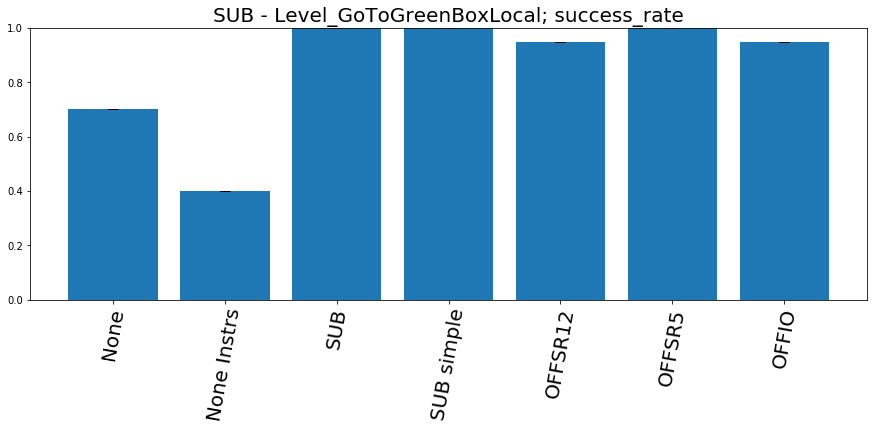

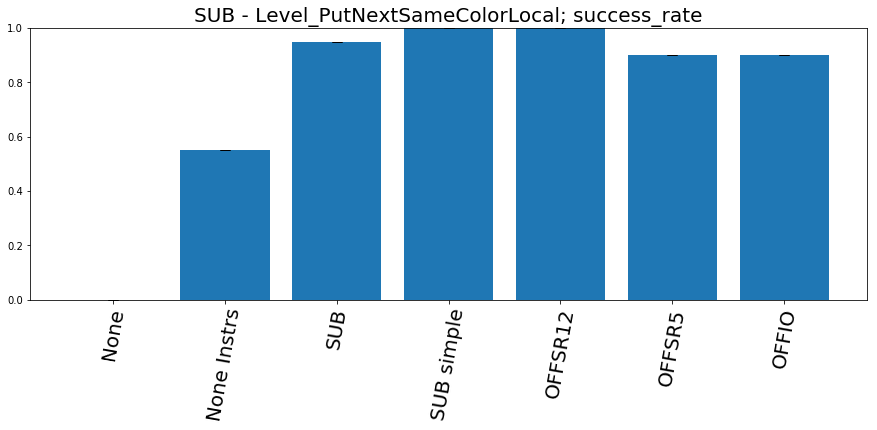

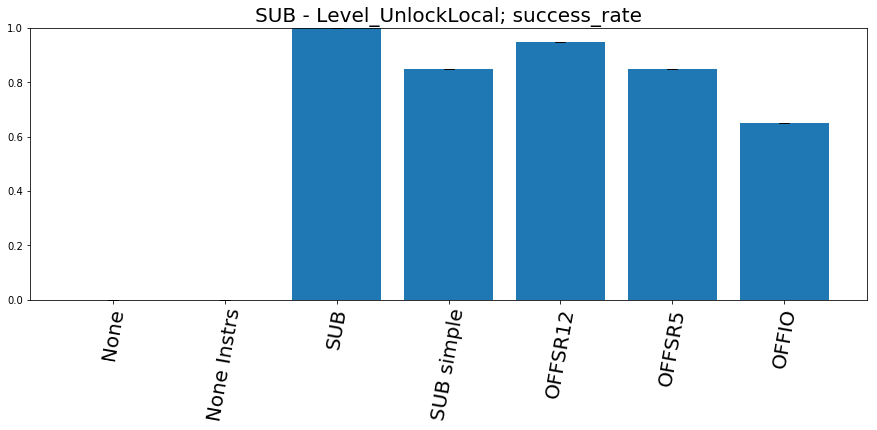

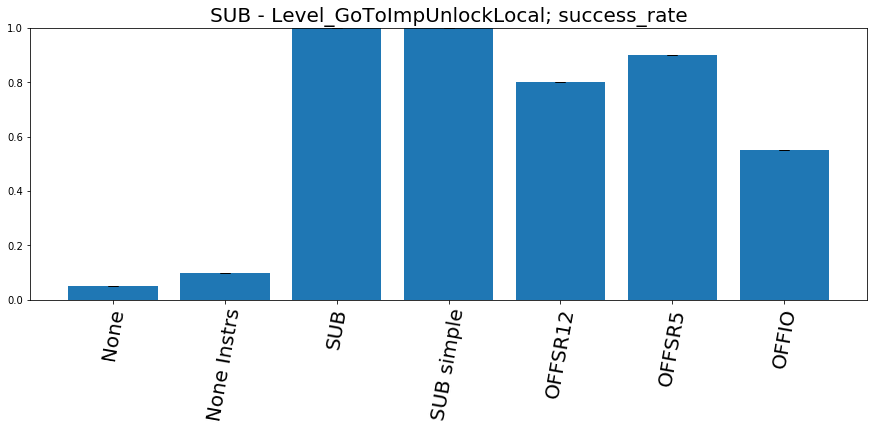

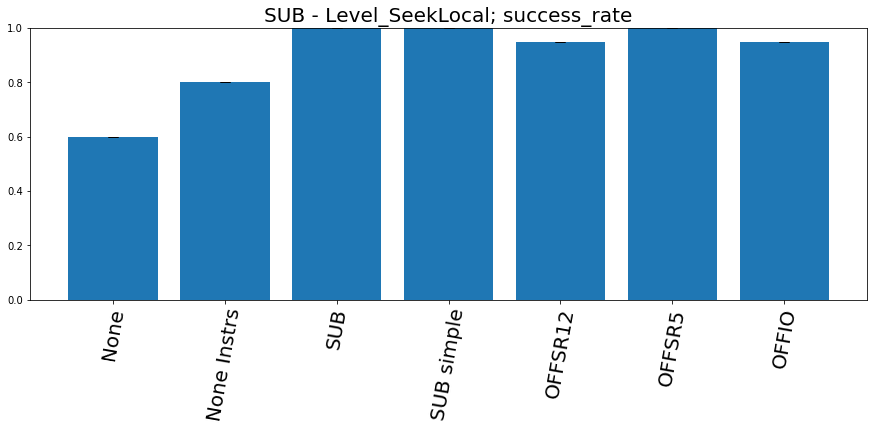

ENV DICT dict_keys(['Level_GoToGreenBoxLocal', 'Level_PutNextSameColorLocal', 'Level_UnlockLocal', 'Level_GoToImpUnlockLocal', 'Level_SeekLocal'])


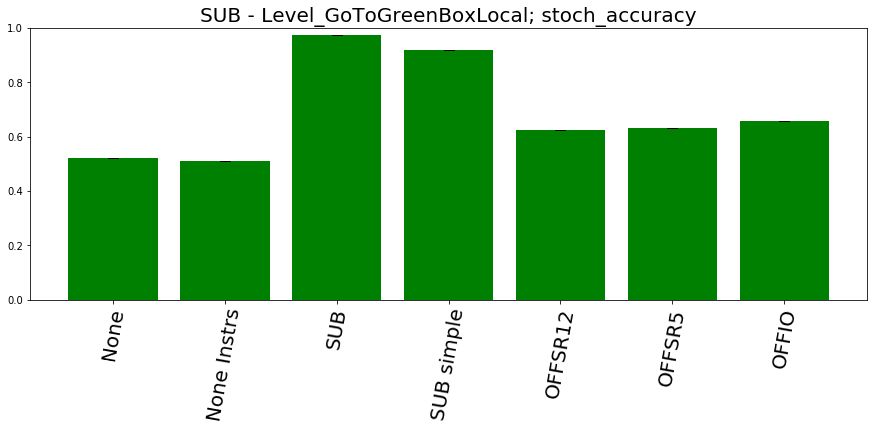

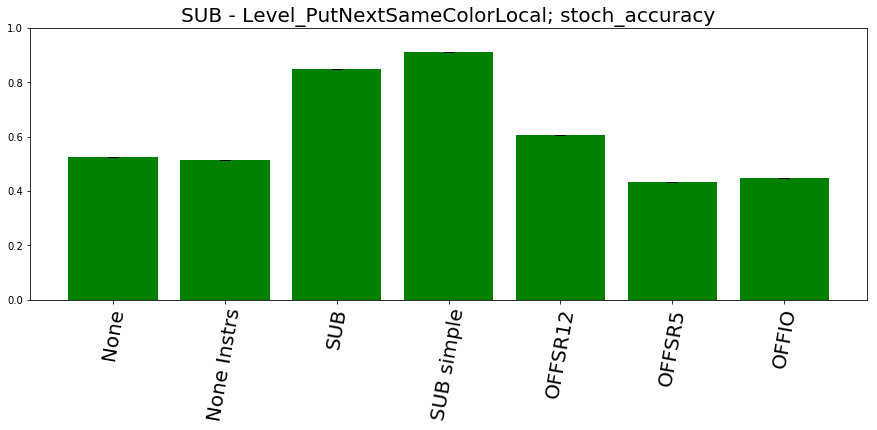

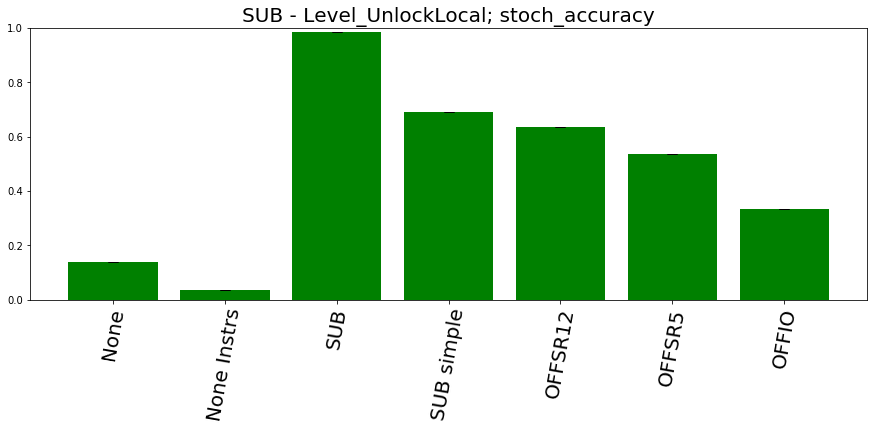

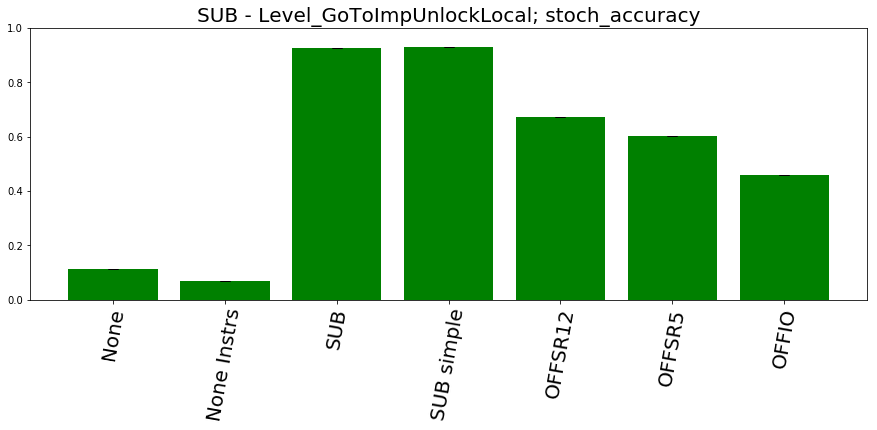

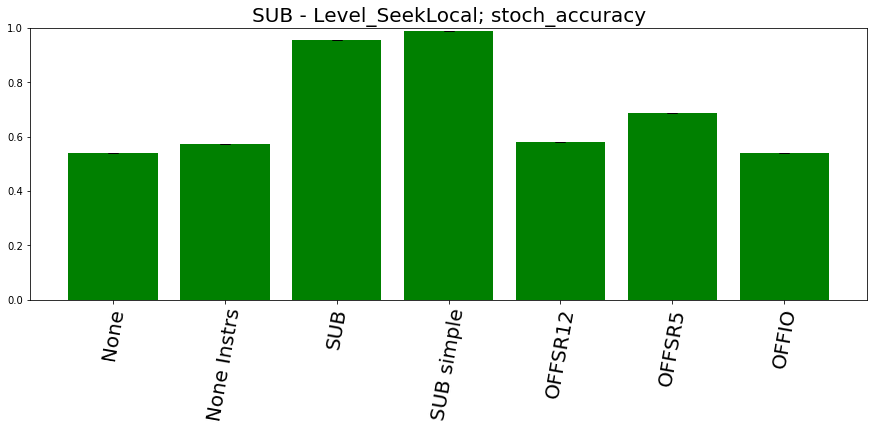

In [251]:
# Smaller 

runs = [
    (['2479'], 'None'),
    (['2481'], 'None Instrs'),
    (['2480'], 'SUB'),
    (['2514'], 'SUB simple'),
    (['2513'], 'OFFSR12'),
    (['2515'], 'OFFSR5'),
    (['2516'], 'OFFIO'),
]
plot_final_generalization(runs, 'SUB',)
plot_final_generalization(runs, 'SUB', 'stoch_accuracy',)


X [ 0. 10.]


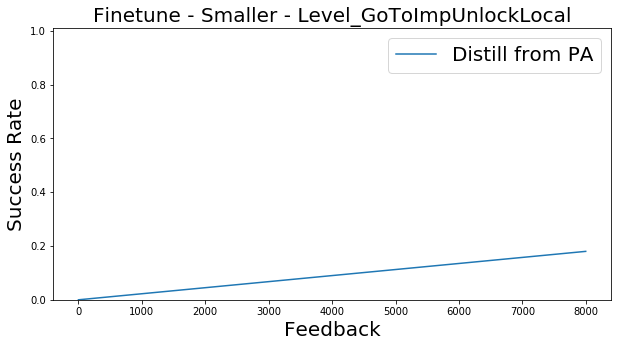

X [ 0. 10.]


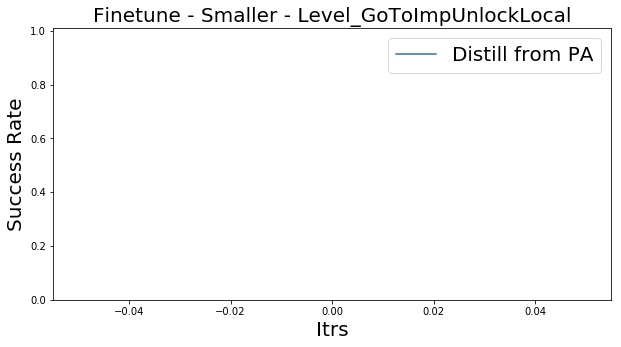

In [200]:
runs = [
    (['T2493'], 'Distill from PA', 1),
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=5, x_label='Feedback', 
                             y_label="Success Rate")
print("=" * 100)
plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=5, x_label='Itrs', 
                             y_label="Success Rate")
print("=====================================")

X [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
X [ 0.  5. 10. 15.]
X [ 0.  5. 10. 15.]
X [ 0. 10.]
X [ 0.       4.205    8.085   12.1125  16.0075  20.04125 24.02625 27.965
 31.70875 35.85375]
X [0.      0.245   0.455   0.6375  0.83125 1.05    1.24625 1.45625 1.66375
 1.855  ]
X [0.      0.31125 0.5725  0.83    1.07    1.35125 1.62125 1.9     2.13125
 2.3975 ]
X [0.      0.11625 0.21375 0.3     0.4125  0.56125 0.64875 0.71625 0.815
 0.96125]


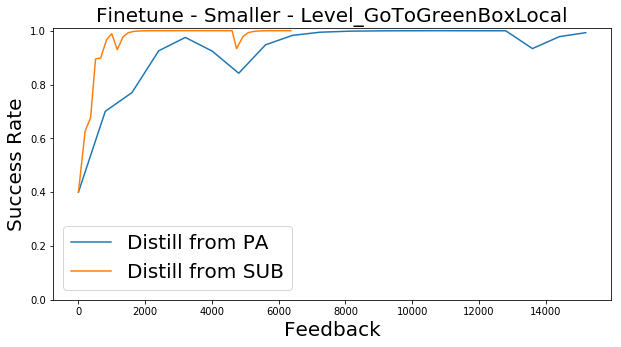

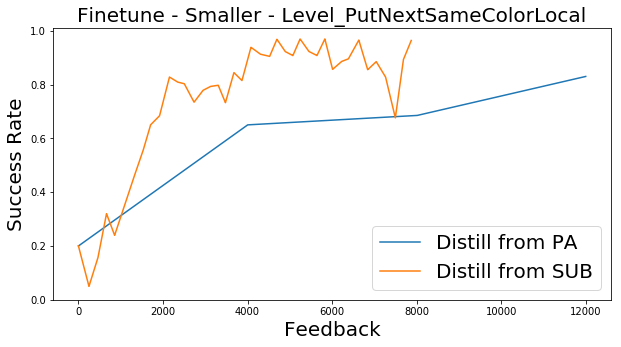

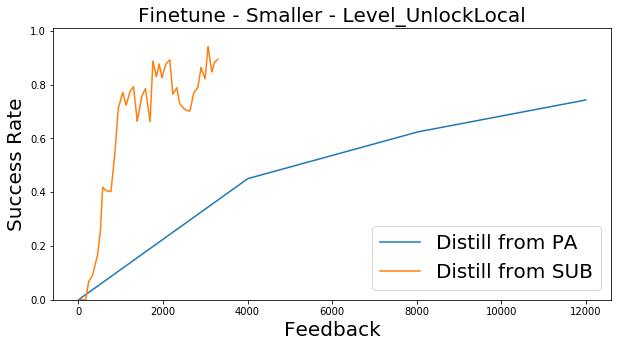

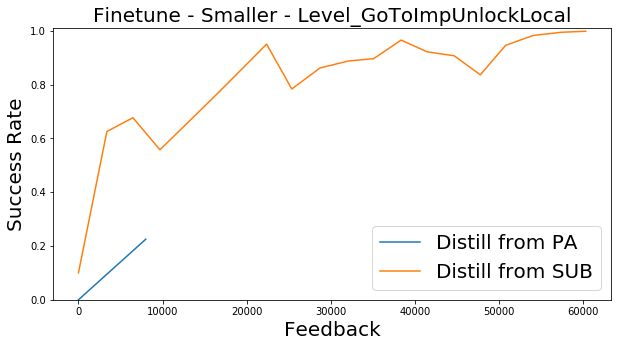

X [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
X [ 0.  5. 10. 15.]
X [ 0.  5. 10. 15.]
X [ 0. 10.]
X [ 0.       4.205    8.085   12.1125  16.0075  20.04125 24.02625 27.965
 31.70875 35.85375]
X [0.      0.245   0.455   0.6375  0.83125 1.05    1.24625 1.45625 1.66375
 1.855  ]
X [0.      0.31125 0.5725  0.83    1.07    1.35125 1.62125 1.9     2.13125
 2.3975 ]
X [0.      0.11625 0.21375 0.3     0.4125  0.56125 0.64875 0.71625 0.815
 0.96125]


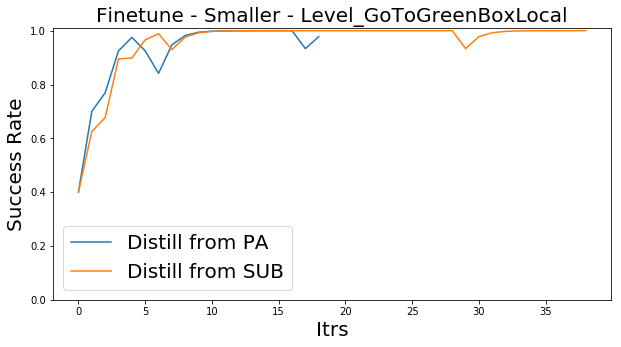

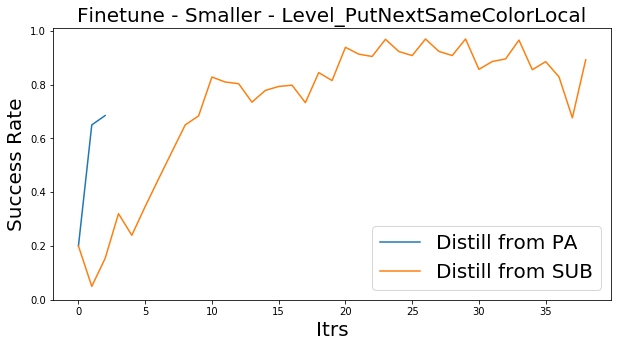

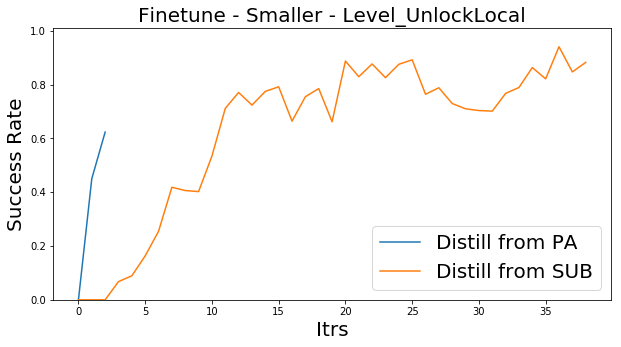

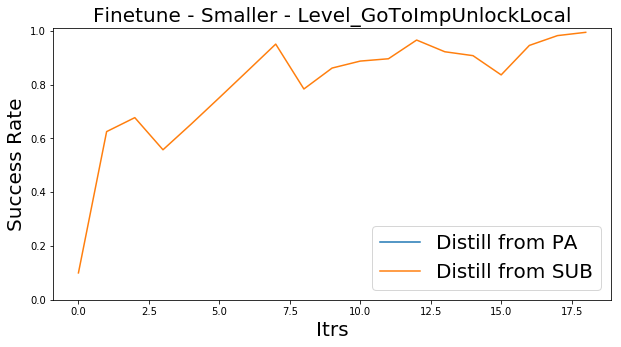

In [206]:
runs = [
    (['T2490', 'T2491', 'T2492', 'T2493'], 'Distill from PA', 1),
    (['T2497', 'T2494', 'T2495', 'T2496'], 'Distill from SUB', 1),
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=2, x_label='Feedback', 
                             y_label="Success Rate")
print("=" * 100)
plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=2, x_label='Itrs', 
                             y_label="Success Rate")
print("=====================================")

/home/olivia/miniconda3/envs/babyai/lib/python3.7/site-packages/ipykernel_launcher.py:267: RuntimeWarning: invalid value encountered in true_divide


X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [      nan 0.4205    0.40425   0.40375   0.4001875]
X [      nan 0.245     0.2275    0.2125    0.2078125]
X [      nan 0.27      0.267125  0.26075   0.2603125]
X [       nan 0.1185     0.112      0.11033333 0.1105625 ]
X [       nan 0.27       0.251875   0.24916667 0.2453125 ]
X [       nan 0.2785     0.282125   0.27466667 0.2741875 ]
X [       nan 0.1185     0.127375   0.12808333 0.12925   ]
X [       nan 0.4735     0.471875   0.46608333 0.465375  ]
X [      nan 0.2725    0.25125   0.245     0.2459375]
X [   nan 0.1625 0.14   0.135  0.13  ]
X [       nan 0.09375    0.08125    0.07333333 0.0696875 ]
X [       nan 0.05375    0.046875   0.04208333 0.040625  ]
X [       nan 0.03625    0.026875   0.02541667 0.0234375 ]


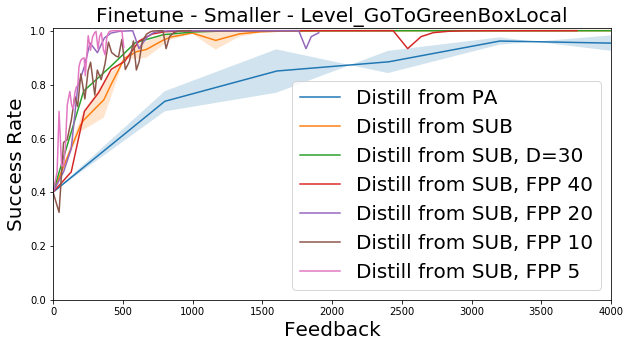

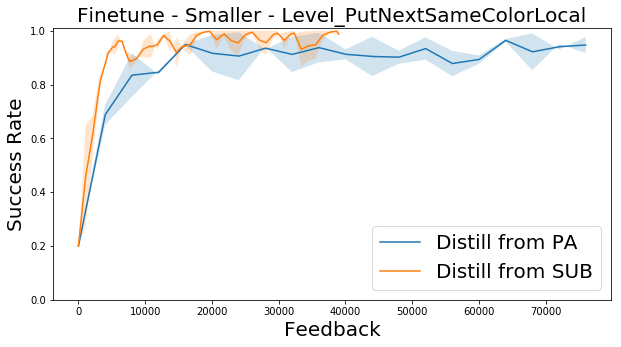

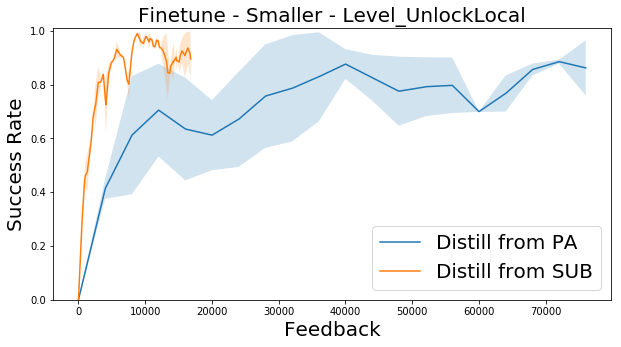

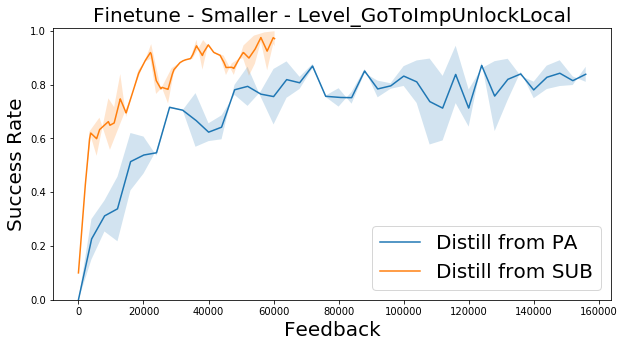

X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [nan  1.  1.  1.  1.]
X [      nan 0.4205    0.40425   0.40375   0.4001875]
X [      nan 0.245     0.2275    0.2125    0.2078125]
X [      nan 0.27      0.267125  0.26075   0.2603125]
X [       nan 0.1185     0.112      0.11033333 0.1105625 ]
X [       nan 0.27       0.251875   0.24916667 0.2453125 ]
X [       nan 0.2785     0.282125   0.27466667 0.2741875 ]
X [       nan 0.1185     0.127375   0.12808333 0.12925   ]
X [       nan 0.4735     0.471875   0.46608333 0.465375  ]
Error on  ['T2497', 'T2494', 'T2508', 'T2509', 'T2502', 'T2503', 'T2504', 'T2505'] fp and xp are not of the same length.
X [      nan 0.2725    0.25125   0.245     0.2459375]
X [   nan 0.1625 0.14   0.135  0.13  ]
X [       nan 0.09375    0.08125    0.07333333 0.0696875 ]
X [       nan 0.05375    0.046875   0.04208333 0.040625  ]
X [       nan 0.036

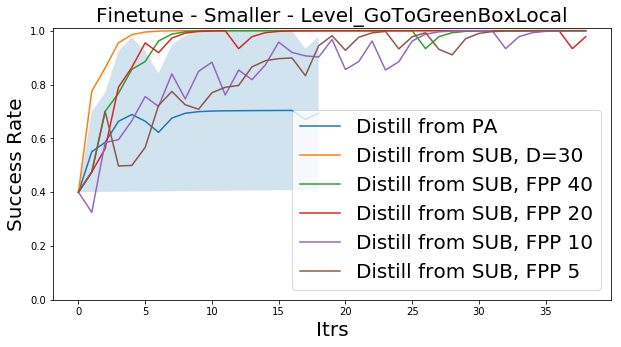

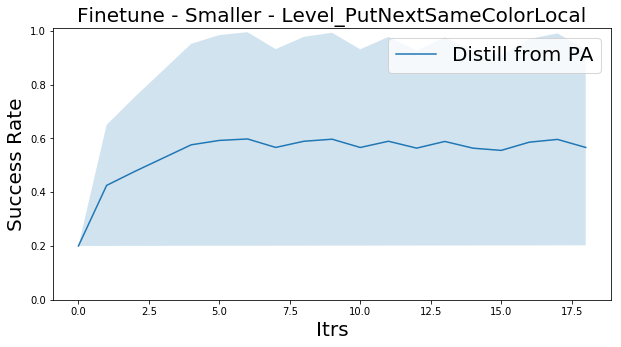

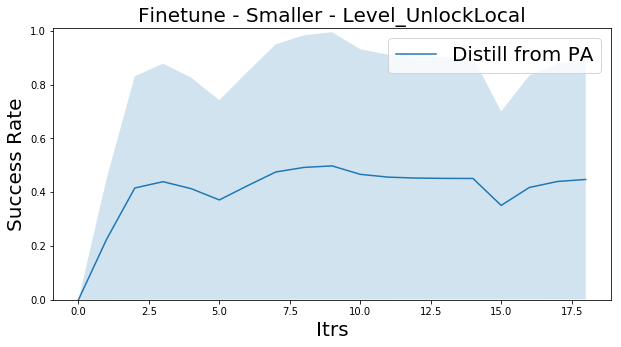

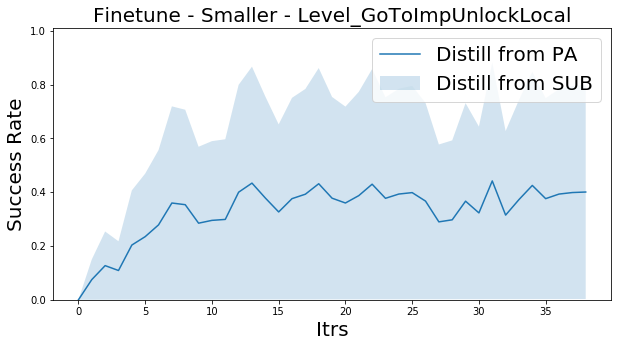

In [266]:
runs = [
    (['T2490', 'T2506', 'T2507', 'T2510', 'T2498', 'T2499', 'T2500', 'T2501'], 'Distill from PA', 1),
    (['T2497', 'T2494', 'T2508', 'T2509', 'T2502', 'T2503', 'T2504', 'T2505'], 'Distill from SUB', 1),
#     (['T2495', 'T2496', 'T2497'], 'Distill from SUB', 1),
    (['T2519'], 'Distill from SUB, D=30', 1),
    (['T2517'], 'Distill from SUB, FPP 40', 1),
    (['T2518'], 'Distill from SUB, FPP 20', 1),
    (['T2520'], 'Distill from SUB, FPP 10', 1),
    (['T2521'], 'Distill from SUB, FPP 5', 1),
]
plt.xlim(0, 4000)
plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=2, x_label='Feedback', 
                             y_label="Success Rate")
print("=" * 100)
plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=2, x_label='Itrs', 
                             y_label="Success Rate")
print("=====================================")

X [ 0.       4.205    8.085   12.1125  16.0075  20.04125 24.02625 27.965
 31.70875 35.85375]


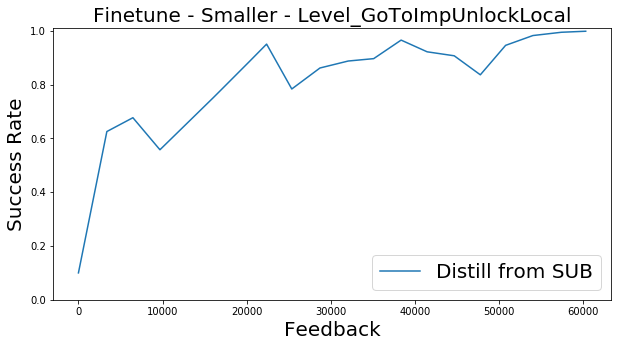

In [231]:
runs = [
    (['T2497'], 'Distill from SUB', 1),
]

plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=2, x_label='Feedback', 
                             y_label="Success Rate")

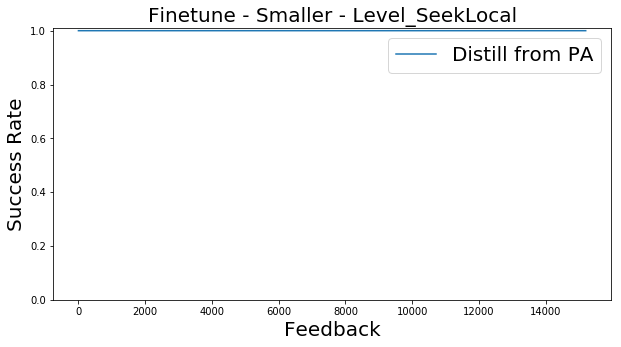

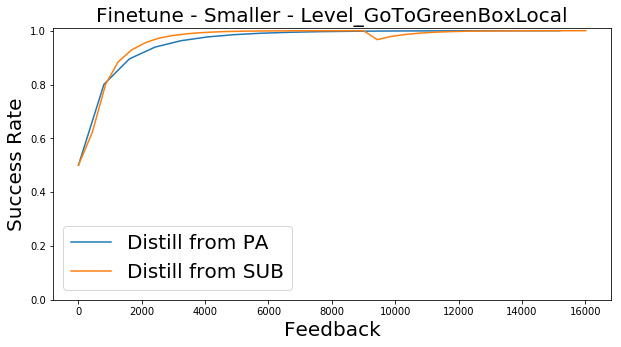

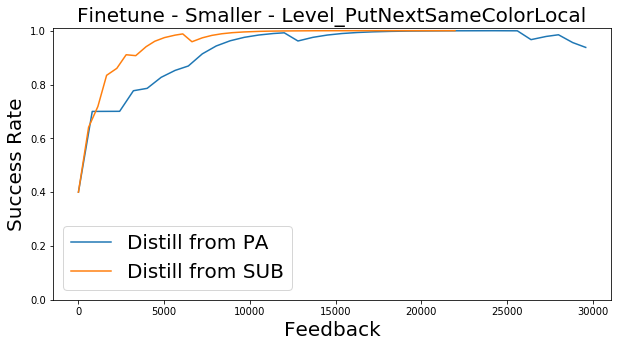

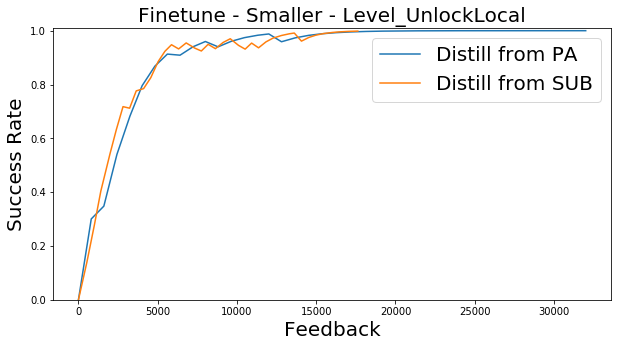

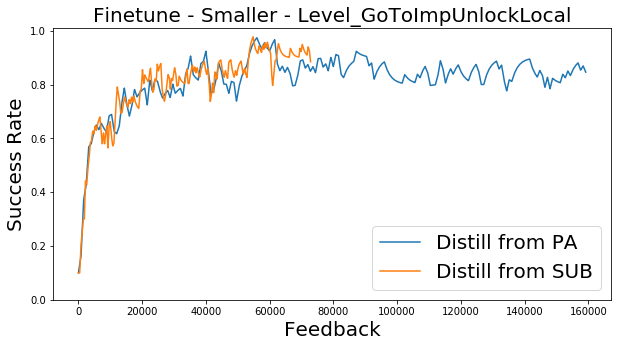

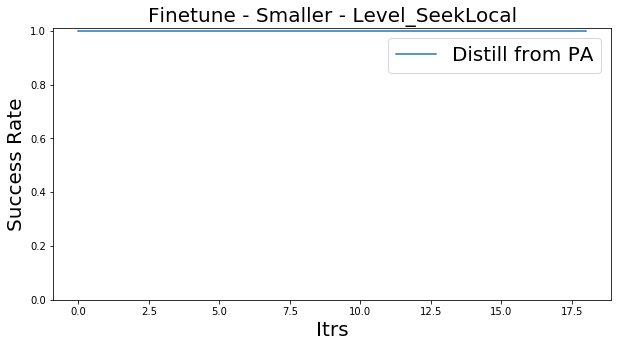

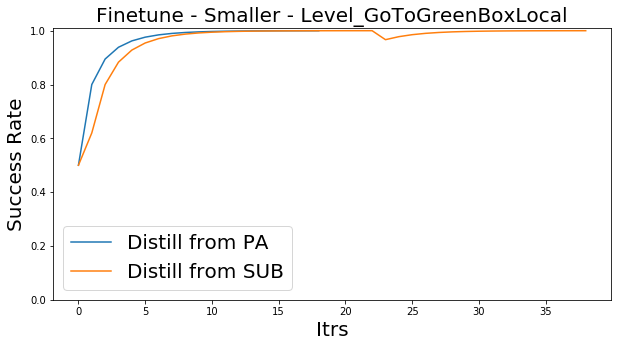

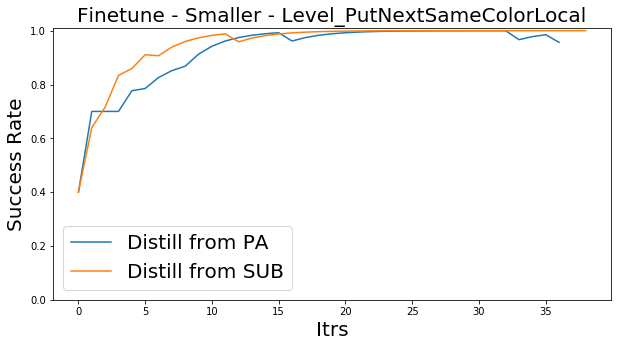

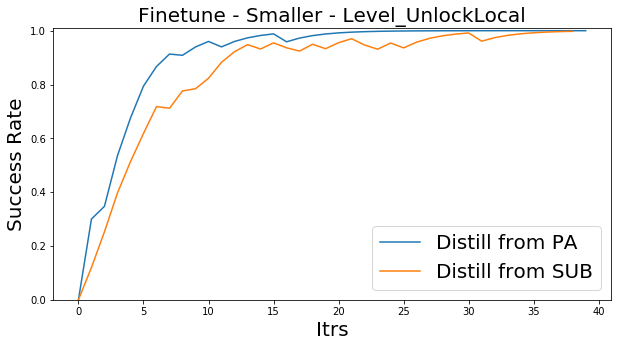

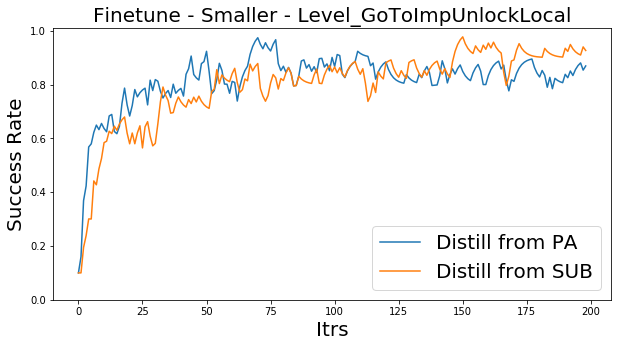

In [222]:
runs = [
    (['T2482', 'T2483', 'T2484', 'T2485'], 'Distill from PA', 1),
    (['T2486', 'T2487', 'T2488', 'T2489'], 'Distill from SUB', 1),
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=5, x_label='Feedback', 
                             y_label="Success Rate")
print("=" * 100)
plot_finetune_generalization(runs, 'Finetune - Smaller', smooth=5, x_label='Itrs', 
                             y_label="Success Rate")
print("=====================================")

## Finetune Bigger Subgoals

ENV DICT dict_keys(['Level_PutNextSameColor', 'Level_Unlock', 'Level_GoToHeldout', 'Level_GoToGreenBox', 'Level_GoToImpUnlock', 'Level_UnblockPickup', 'Level_Seek', 'Level_PutNextLocal', 'Level_Open', 'Level_GoTo', 'Level_Pickup', 'Level_PutNext'])


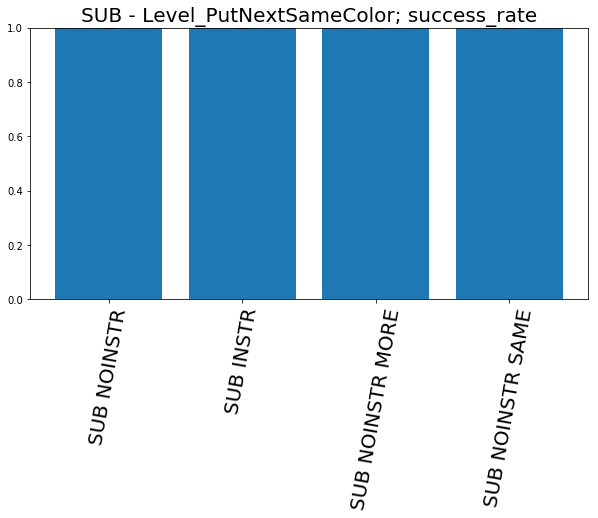

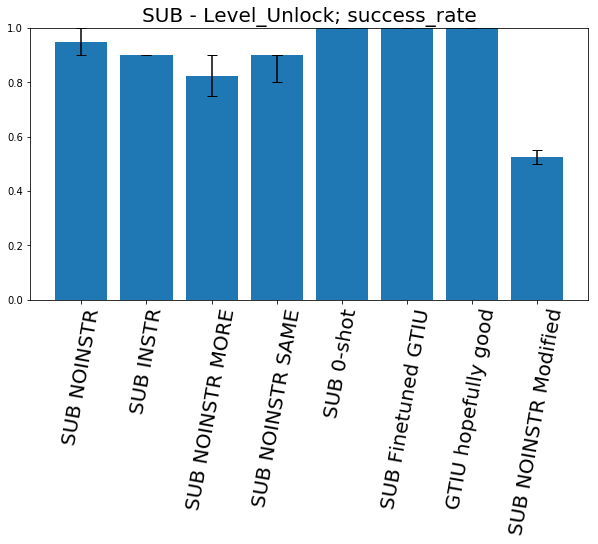

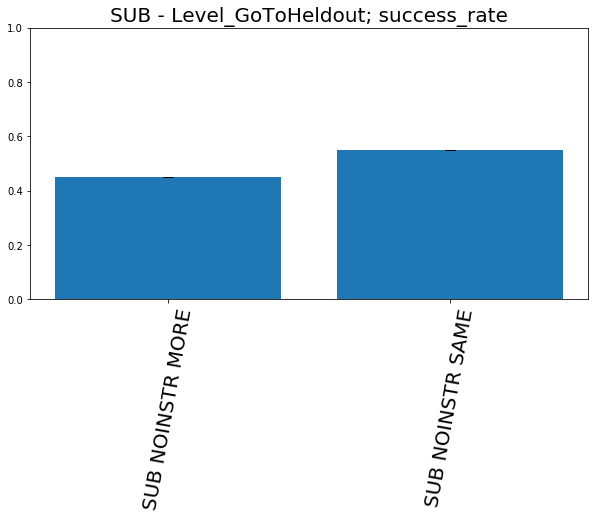

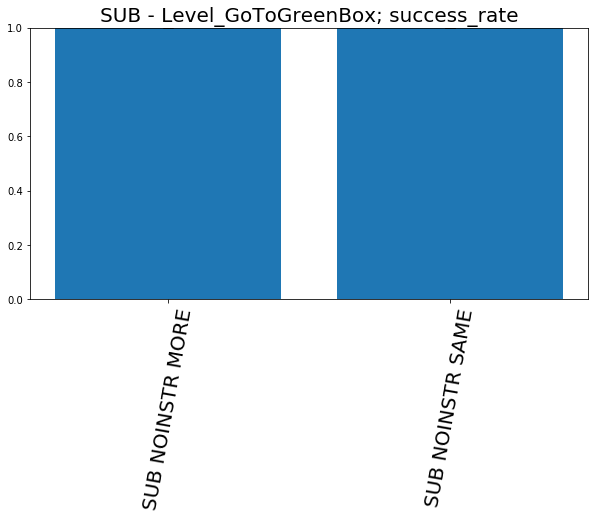

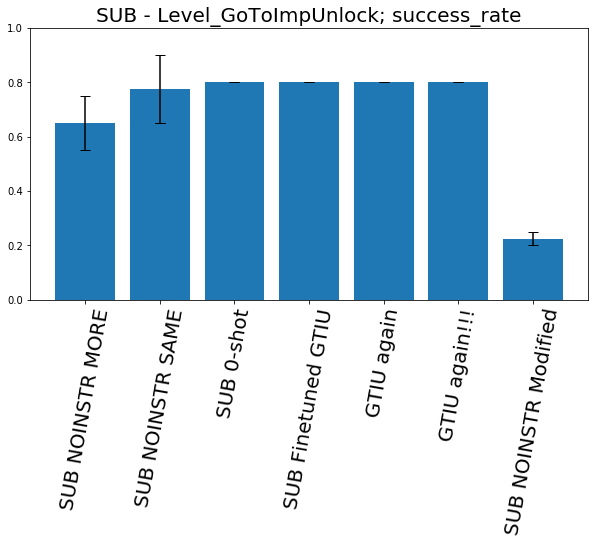

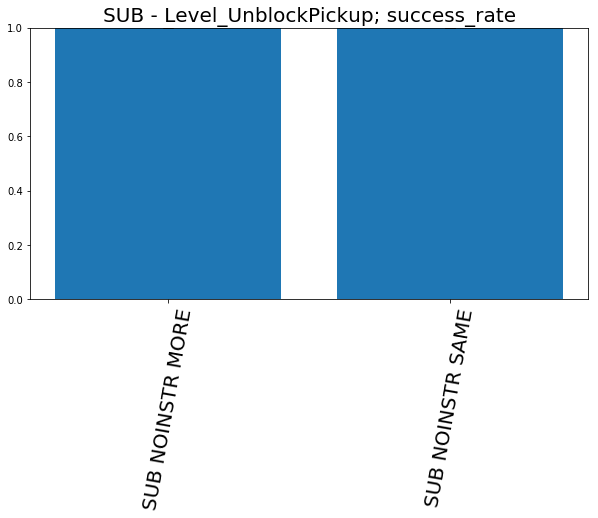

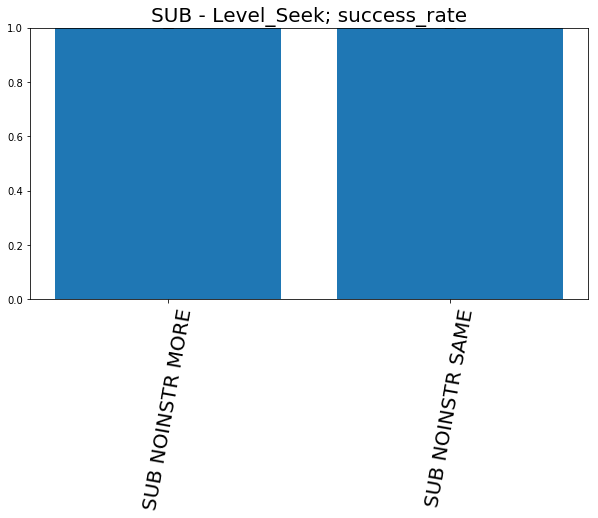

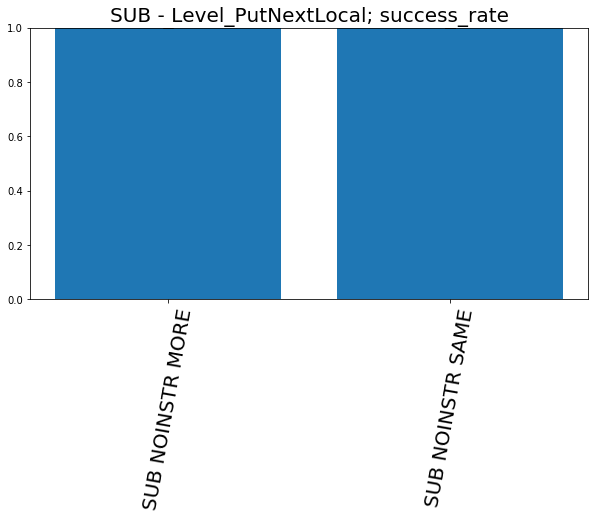

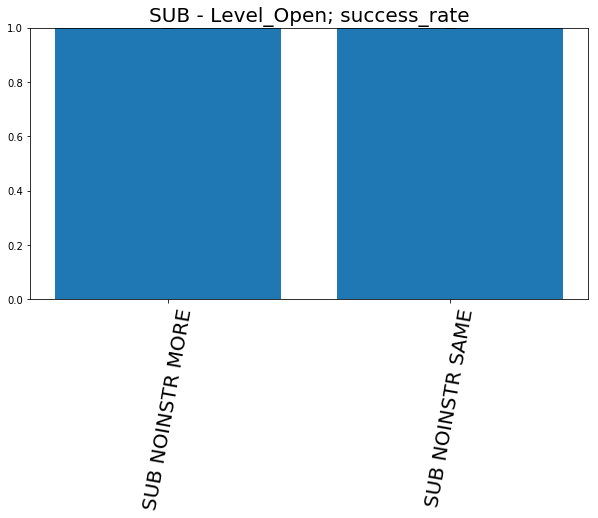

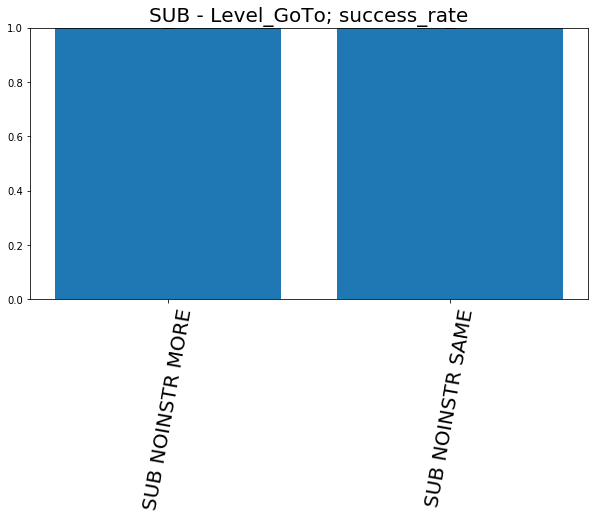

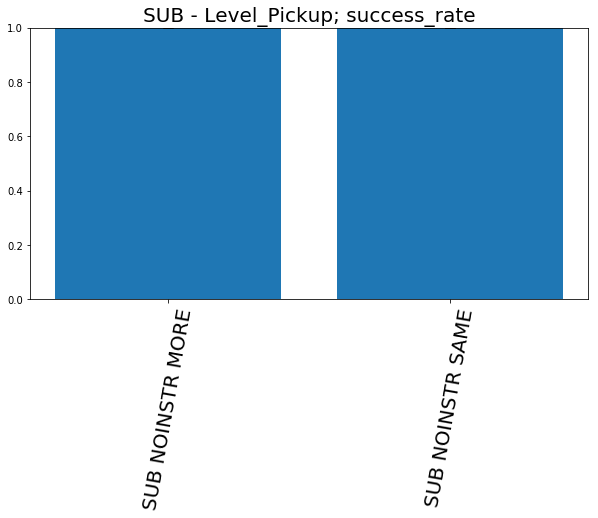

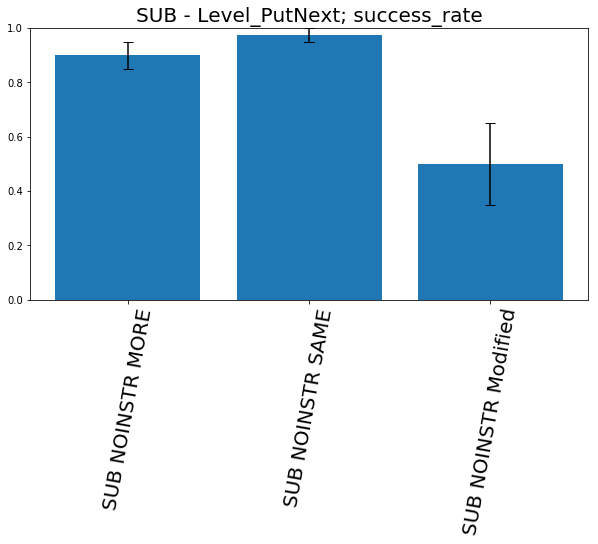

ENV DICT dict_keys(['Level_PutNextSameColor', 'Level_Unlock', 'Level_GoToHeldout', 'Level_GoToGreenBox', 'Level_GoToImpUnlock', 'Level_UnblockPickup', 'Level_Seek', 'Level_PutNextLocal', 'Level_Open', 'Level_GoTo', 'Level_Pickup', 'Level_PutNext'])


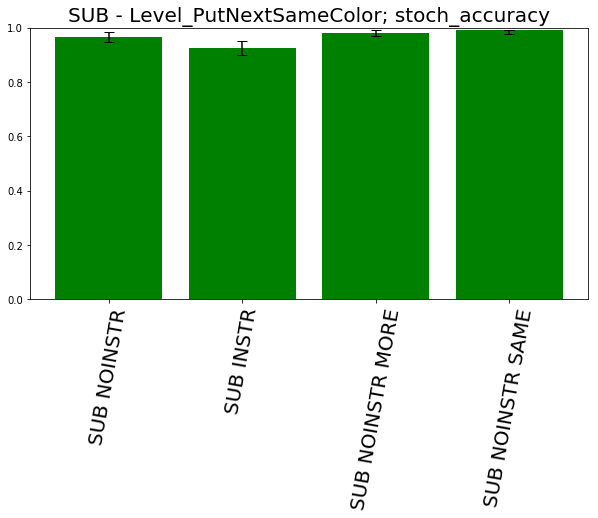

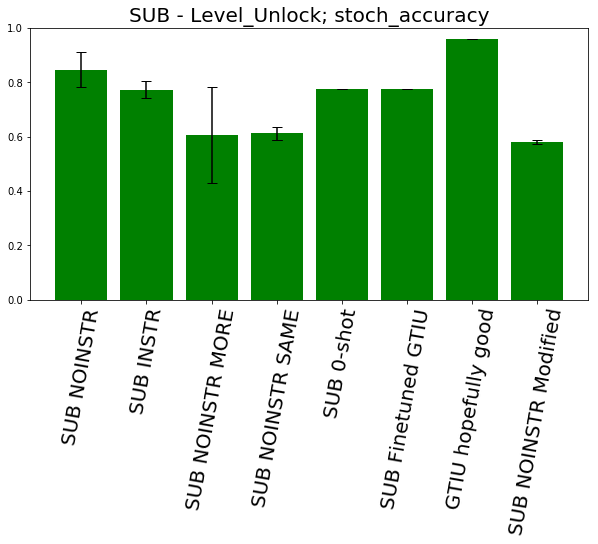

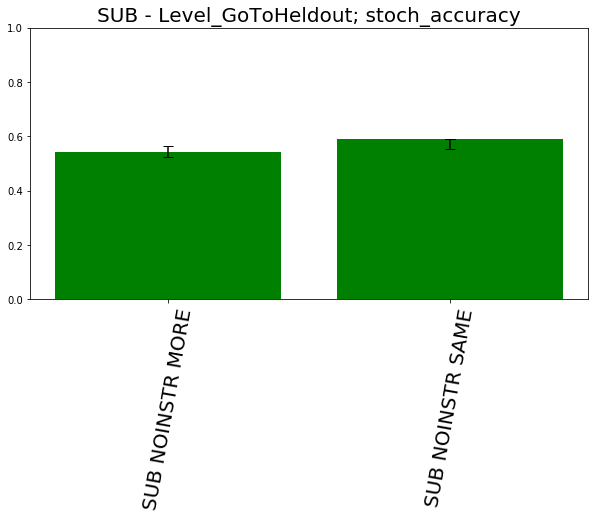

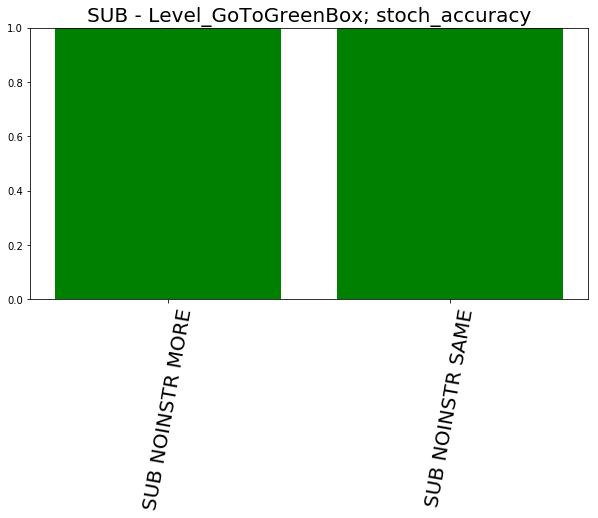

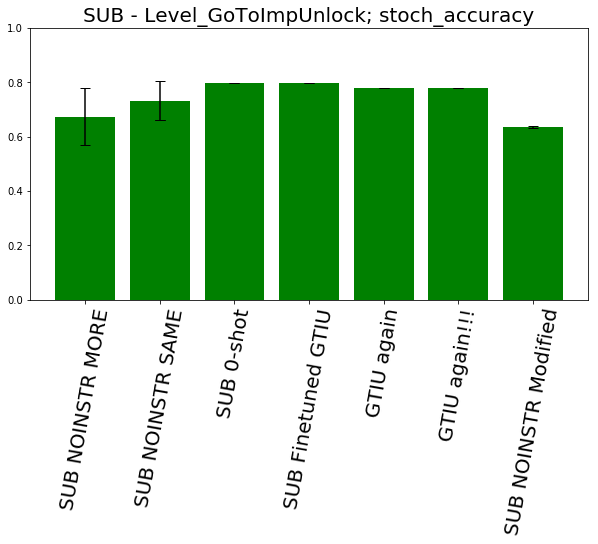

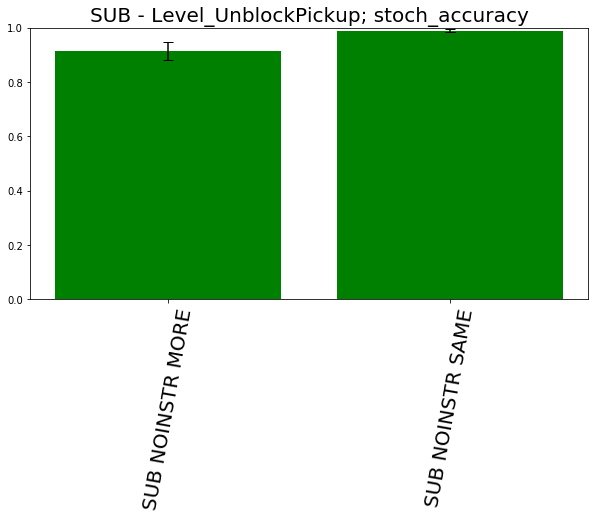

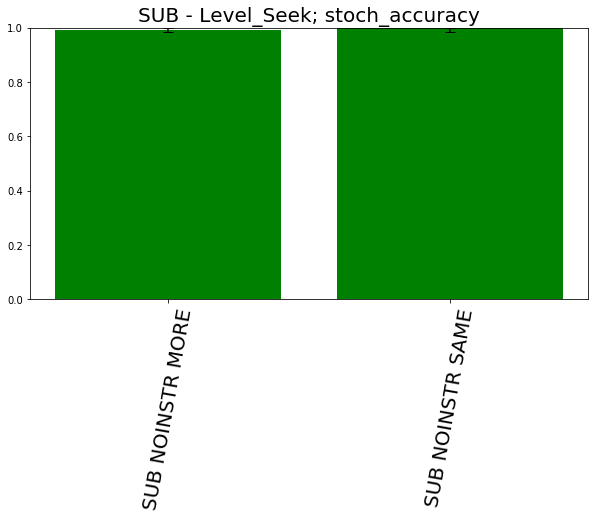

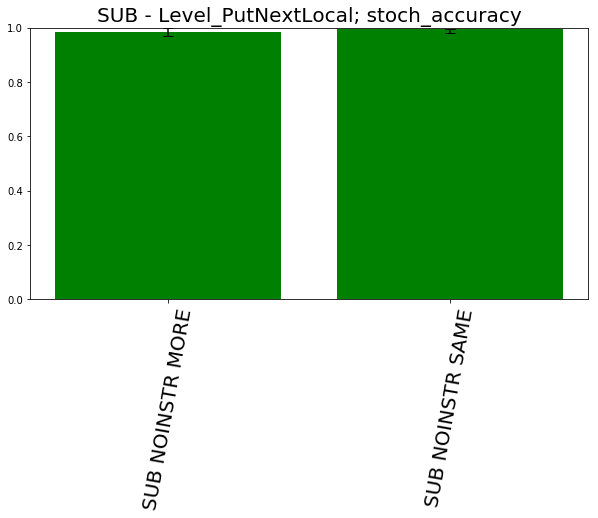

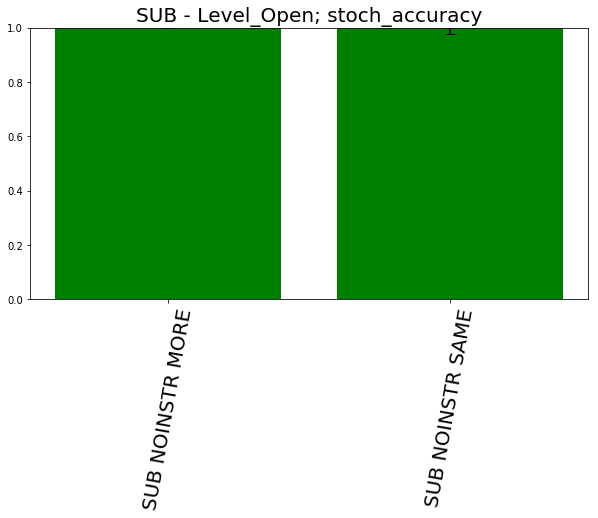

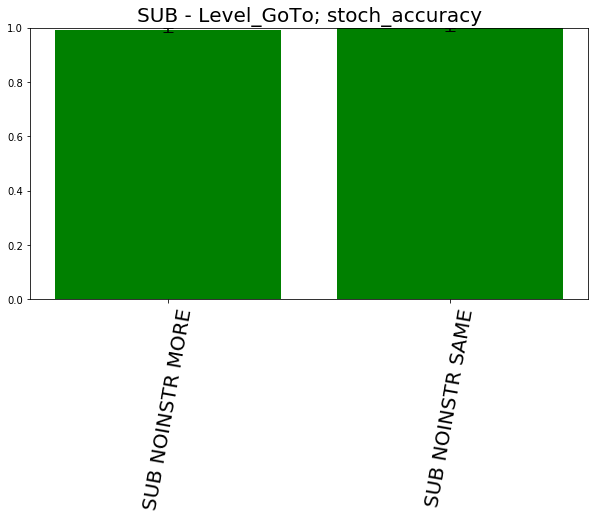

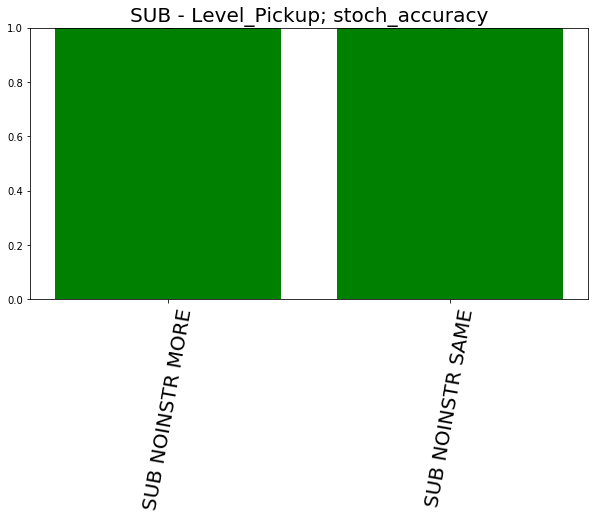

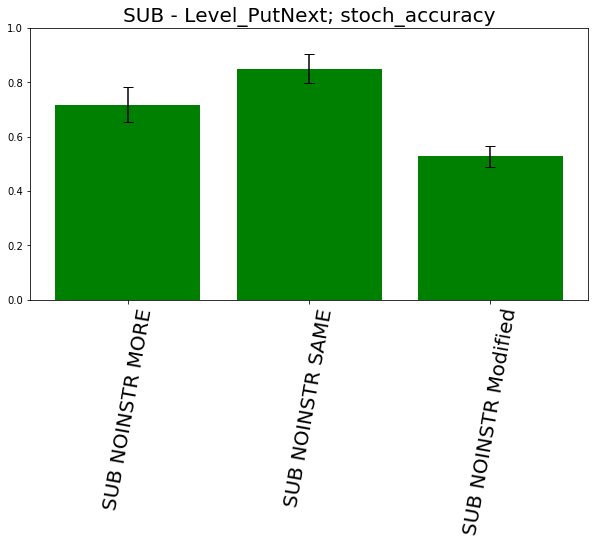

In [140]:

runs = [
    (['2397', '2398'], 'SUB NOINSTR'),
    (['2399', '2400'], 'SUB INSTR'),
    (['2415', '2416'], 'SUB NOINSTR MORE'),
    (['2435'], 'SUB NOINSTR SAME'),
    (['2441'], 'SUB 0-shot'),
    (['2441'], 'SUB Finetuned GTIU'),
    (['T2443'], 'GTIU again'),
    (['T2443'], 'GTIU again!!!'),
    (['T2452'], 'GTIU hopefully good'),
    (['2434', '2435'], 'SUB NOINSTR SAME'),
    (['2421', '2422'], 'SUB NOINSTR Modified'),
]
plot_final_generalization(runs, 'SUB',)
#                             all_run_names=['Level_Unlock', 'Level_GoToImpUnlock'])
plot_final_generalization(runs, 'SUB', 'stoch_accuracy',)
#                             all_run_names=['Level_Unlock', 'Level_GoToImpUnlock'])


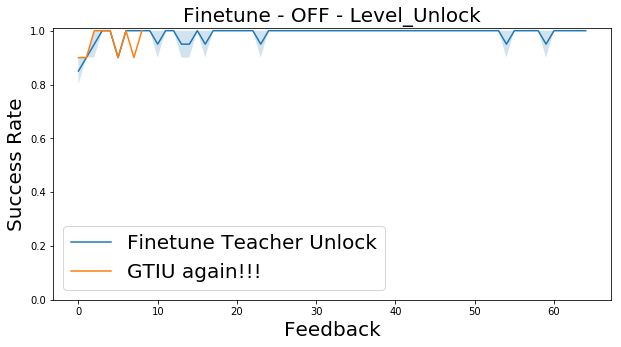

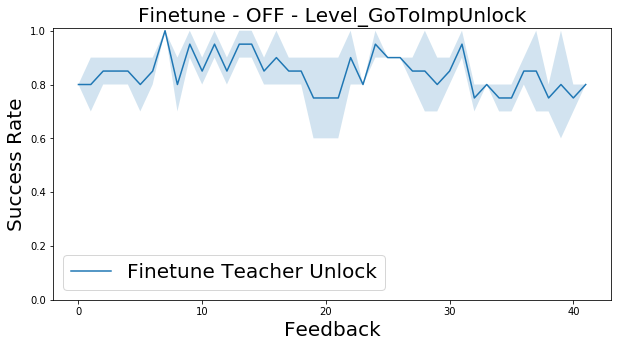

In [133]:
runs = [
    (['T2445', 'T2446', 'T2447', 'T2448'], 'Finetune Teacher Unlock', 1),
#     (['T2437', 'T2439'], 'Finetune Teacher Unlock', 1),
#     (['T2438', 'T2440'], 'Finetune Teacher GTIU', 1),
#     (['T2443'], 'GTIU again', 1),
    (['T2452'], 'GTIU again!!!'),
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - OFF', smooth=1, 
                             x_label='Feedback', y_label="Success Rate", 
                            all_run_names=['Level_Unlock', 'Level_GoToImpUnlock'])
print("=====================================")

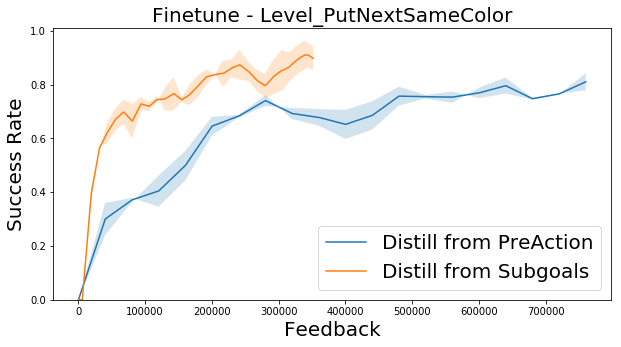

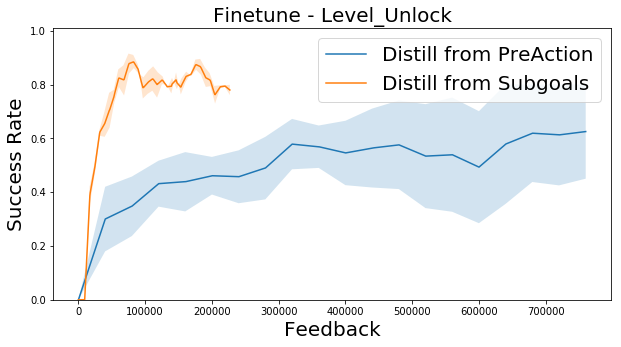

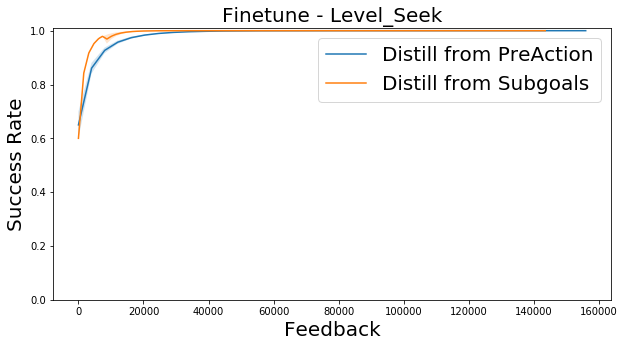

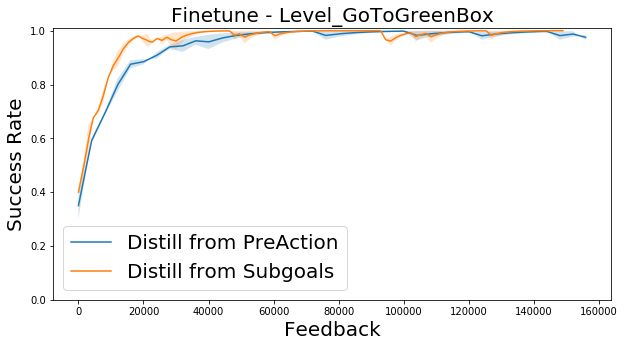

In [228]:
runs = [
    (['T2463', 'T2464', 'T2465', 'T2466', 'T2467', 'T2468'], 'Distill from PreAction', 1),
    (['T2461', 'T2462'], 'Distill from Subgoals', 1),
    (['T2455', 'T2456'], 'Distill from Subgoals', 1),
    (['T2459', 'T2460'], 'Distill from Subgoals', 1),
#     (['T2463', 'T2464', 'T2465', 'T2466', 'T2467', 'T2468'], 'SUB BCS', 1/5),
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune', smooth=5, x_label='Feedback', 
                             y_label="Success Rate")
print("=====================================")

X [  0.       16.605    33.4125   48.95375  65.03875  82.4      98.4725
 115.4475  131.445   147.965  ]
X [  0.       17.71375  33.4075   48.64625  65.4525   81.27125  98.3925
 115.01125 131.48125 146.52875]
X [ 0.       8.3775  16.63625 25.17625 33.405   41.8375  50.06375 58.38
 66.7125  75.40875]
X [ 0.       7.46625 15.33375 23.32    30.655   37.89625 45.6175  53.22
 60.825   67.77   ]
X [ 0.       1.87125  3.6875   5.63875  7.57125  9.4975  11.45375 13.32
 15.16375 17.18875]
X [ 0.       2.0475   4.00875  5.965    7.84625  9.66125 11.55125 13.45625
 15.32625 17.18125]
X [ 0.       1.95875  3.88875  5.84375  7.75625  9.62    11.46625 13.3575
 15.2275  17.1575 ]
X [ 0.       1.93625  3.81125  5.7175   7.42     9.17875 10.9125  12.6875
 14.3875  16.17   ]
X [  7.19125  23.81875  38.50625  52.98875  68.84     84.88375 100.88
 117.04125 132.81125 147.17   ]
X [  7.19125  23.54     39.19625  53.305    68.35625  84.46125 100.8575
 117.0475  132.12875 148.3525 ]
X [11.69875 21.69    31.141

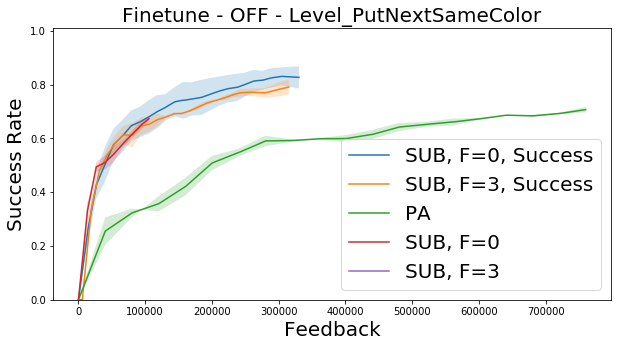

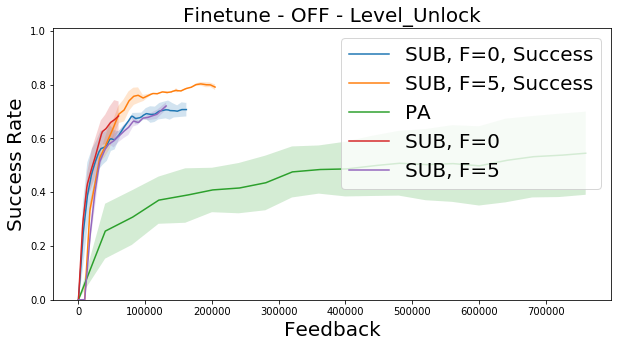

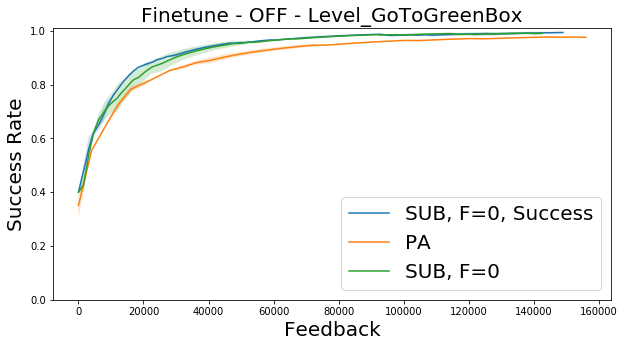

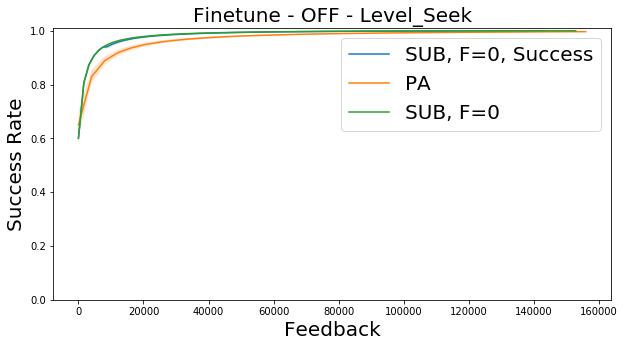

In [213]:
runs = [
    (['T2453', 'T2454', 'T2457', 'T2458', 'T2461', 'T2462'], 'SUB, F=0, Success', 1),
    (['T2455', 'T2456'], 'SUB, F=3, Success', 1),
    (['T2459', 'T2460'], 'SUB, F=5, Success', 1),
    (['T2463', 'T2464', 'T2465', 'T2466', 'T2467', 'T2468'], 'PA', 1),
    (['T2469', 'T2470', 'T2473', 'T2474', 'T2477', 'T2478'], 'SUB, F=0', 1),
    (['T2471', 'T2472'], 'SUB, F=3', 1),
    (['T2475', 'T2476'], 'SUB, F=5', 1),
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - OFF', smooth=50, x_label='Feedback', y_label="Success Rate")
print("=====================================")

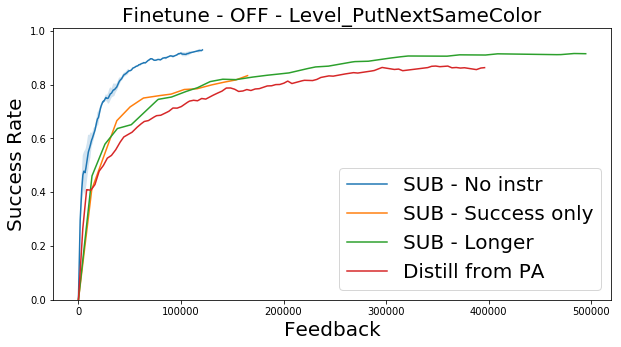

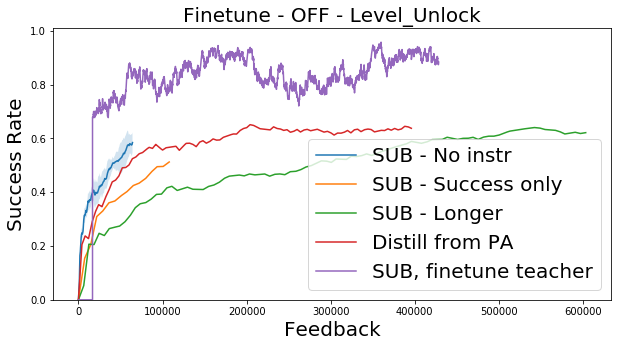

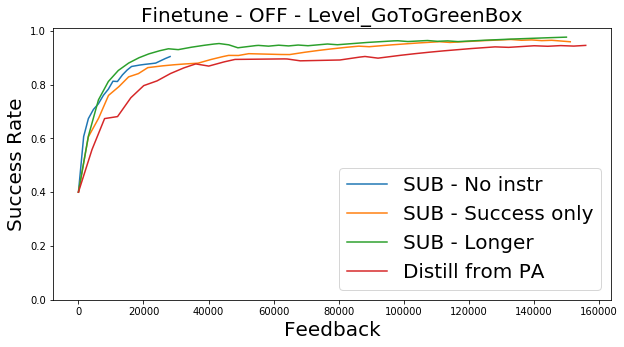

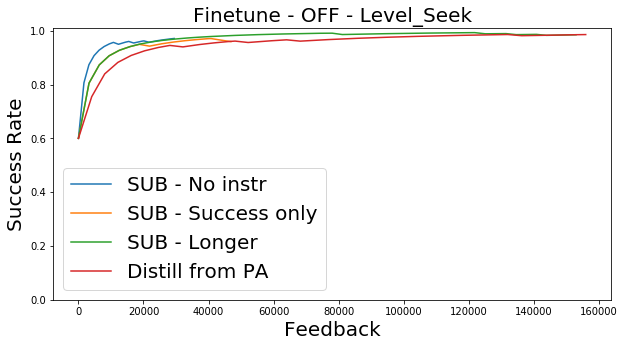

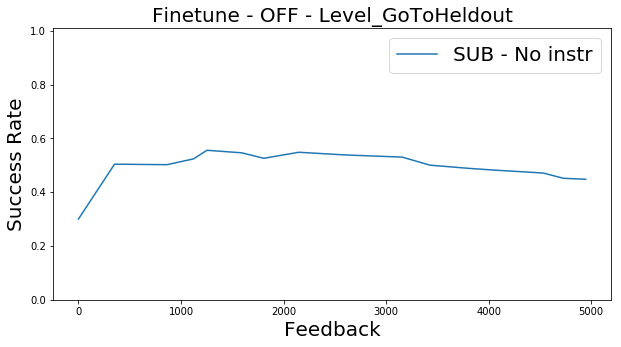

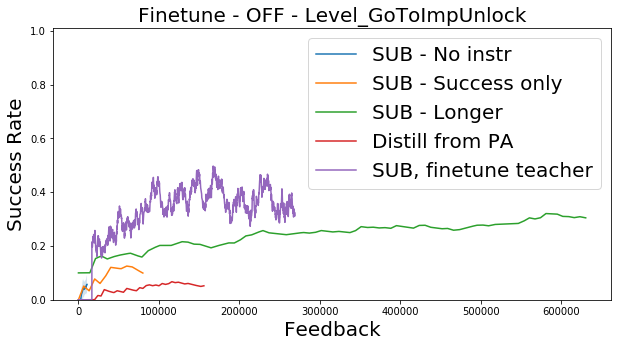

In [142]:
runs = [
#     (['T2328', 'T2329', 'T2330', 'T2333', 'T2334', 'T2335'], 'Distill from OFF5', 800),
    (['T2401', 'T2402', 'T2403', 'T2404', 'T2384', 'T2392', 'T2393'], 'SUB - No instr', 1),
    (['T2407', 'T2409', 'T2411', 'T2413'], 'SUB - Success only', 1),
    (['T2423', 'T2425', 'T2427', 'T2429'], 'SUB - Longer', 1),
    (['T2405', 'T2406', 'T2419', 'T2420'], 'Distill from PA', 1),
    (['T2432', 'T2433'], 'SUB, finetune teacher', 1),
#     (['T2270'], 'Distill from OFFS5 D=5', 800),
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - OFF', smooth=50, x_label='Feedback', y_label="Success Rate")
print("=====================================")

                              policy_env              policy           env  \
0  PolicyT2363_SUB_FROMPA_1-Level_Unlock  T2363_SUB_FROMPA_1  Level_Unlock   
1  PolicyT2363_SUB_FROMPA_1-Level_Unlock  T2363_SUB_FROMPA_1  Level_Unlock   
2  PolicyT2363_SUB_FROMPA_1-Level_Unlock  T2363_SUB_FROMPA_1  Level_Unlock   
3  PolicyT2363_SUB_FROMPA_1-Level_Unlock  T2363_SUB_FROMPA_1  Level_Unlock   
4  PolicyT2363_SUB_FROMPA_1-Level_Unlock  T2363_SUB_FROMPA_1  Level_Unlock   

   success_rate  stoch_accuracy  itr  num_feedback  
0           0.0        0.351852    0             0  
1           0.0        0.396991    1          1921  
2           0.0        0.222801    2          3766  
3           0.0        0.219907    3          5633  
4           0.0        0.354167    4          7508  
feedback [    0  1921  3766  5633  7508  9359 11196 13055 14898 16749     0   321
   557   818  1087  1338  1544  1774  1966  2144]
y [0.         0.         0.         0.         0.         0.
 0.         0.      

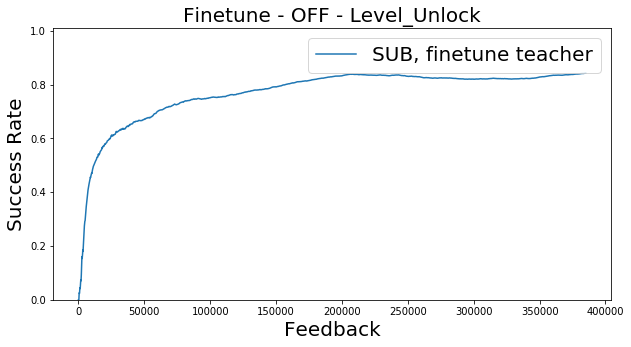

In [83]:
runs = [
    (['T2432'], 'SUB, finetune teacher', 1),
]

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - OFF', smooth=2500, x_label='Feedback', 
                             y_label="Success Rate")
print("=====================================") # kang

## Finetune

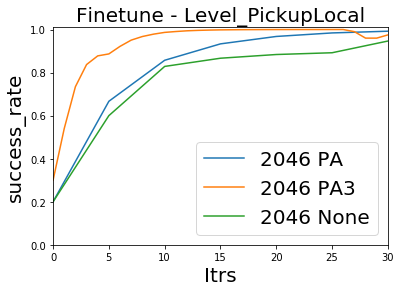

In [3]:
runs = [
    (['T2021'], '2046 PA', 5),
    (['T2022'], '2046 PA3', 5/3),
    (['T2023'], '2046 None', 5),
]
plt.xlim(0, 30)
plot_finetune_generalization(runs, 'Finetune', smooth=3)

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds
Error on  ['T2266'] single positional indexer is out-of-bounds
Error on  ['T2268'] single positional indexer is out-of-bounds
Error on  ['T2226', 'T2244'] single positional indexer is out-of-bounds


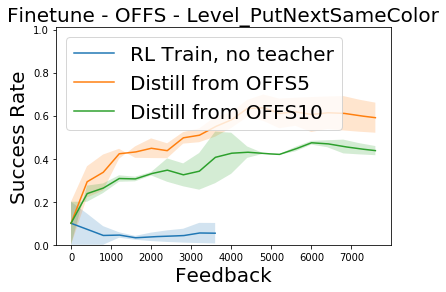

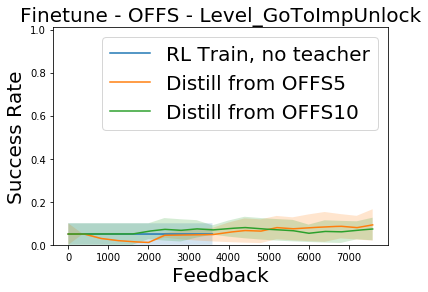

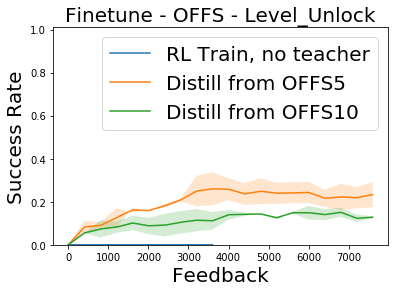

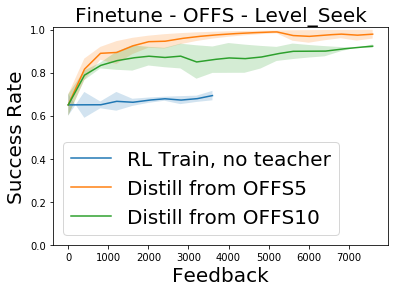

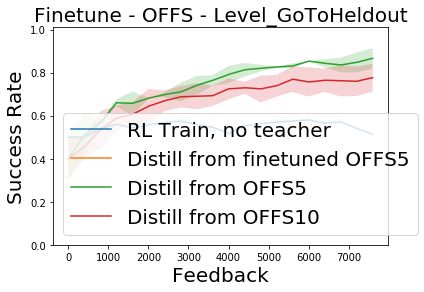

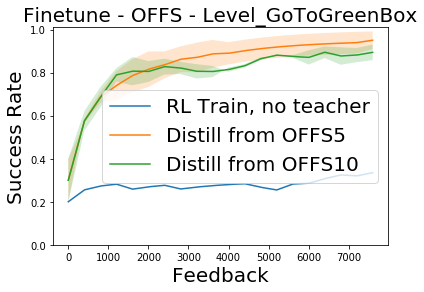

In [4]:
# DOES finetuning the teacher help?
runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2266'], 'Distill from finetuned OFFS3', 400),
    (['T2267'], 'Distill from finetuned OFFS5', 400),
    (['T2268'], 'Distill from finetuned OFFS10', 400),
    (['T2226', 'T2244'], 'Distill from OFFS3', 400),
    (['T2231', 'T2249'], 'Distill from OFFS5', 400),
    (['T2236', 'T2254'], 'Distill from OFFS10', 400),
]
plot_finetune_generalization(runs, 'Finetune - OFFS', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds
Error on  ['T2226', 'T2244'] single positional indexer is out-of-bounds


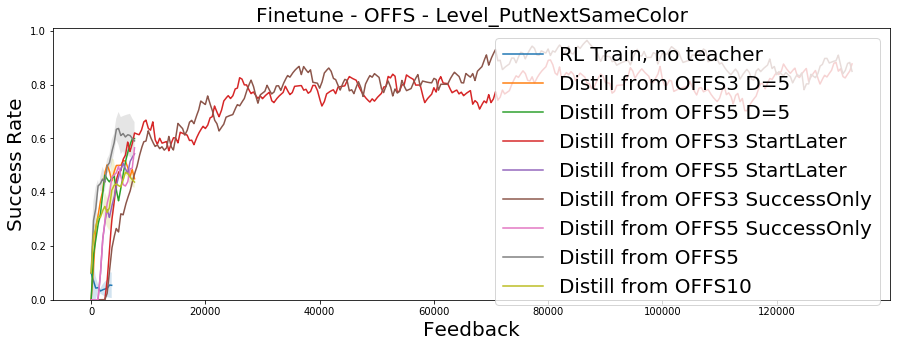

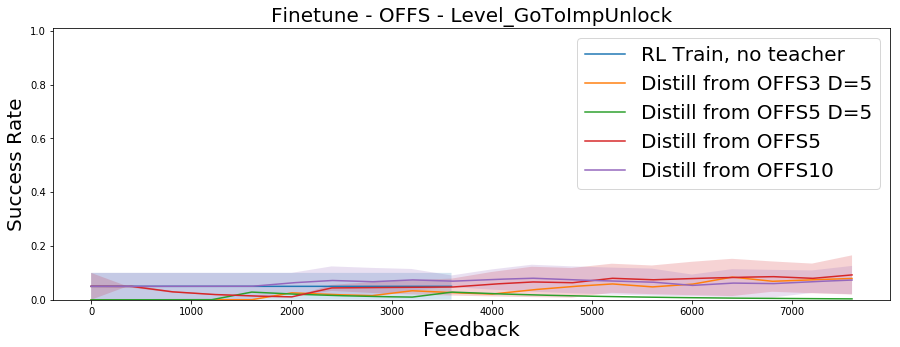

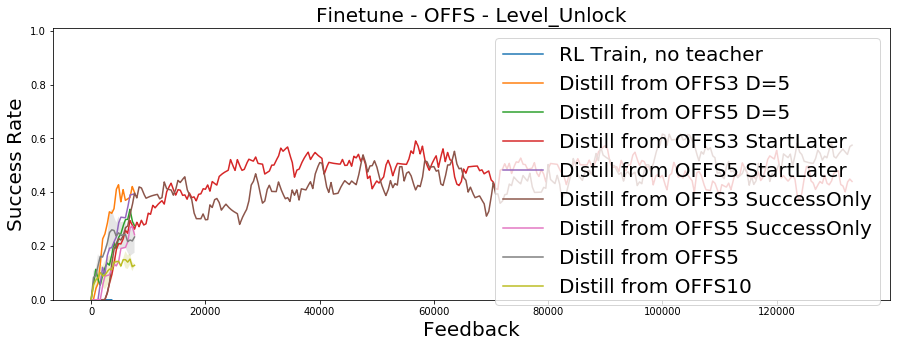

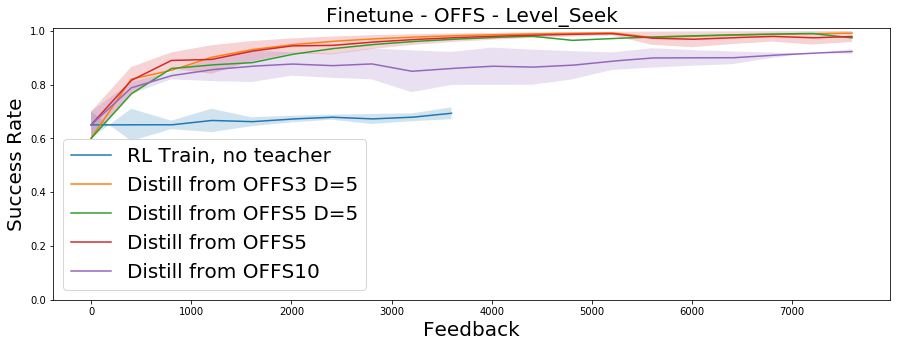

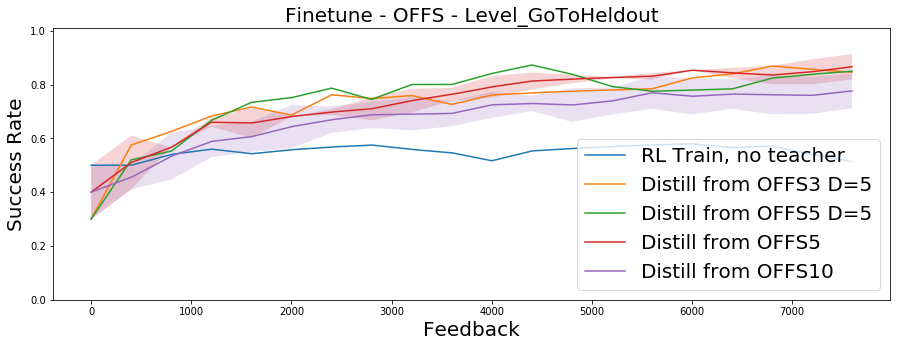

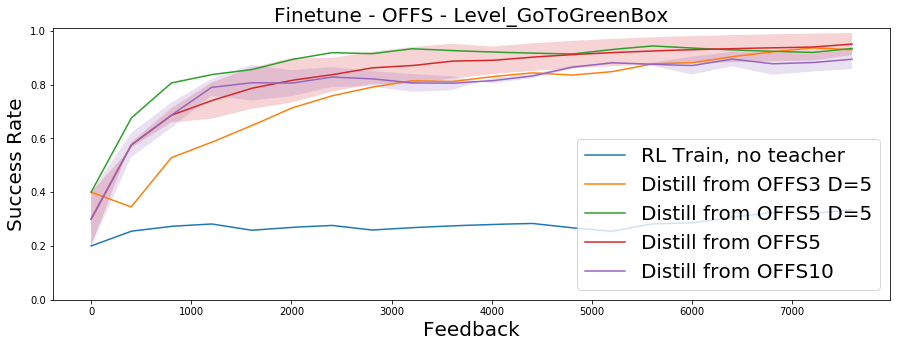

In [5]:
# DOES distilling less help?
runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2269'], 'Distill from OFFS3 D=5', 400),
    (['T2270'], 'Distill from OFFS5 D=5', 400),
    (['T2271'], 'Distill from OFFS3 StartLater', 400),
    (['T2272'], 'Distill from OFFS5 StartLater', 400),
    (['T2273'], 'Distill from OFFS3 SuccessOnly', 400),
    (['T2274'], 'Distill from OFFS5 SuccessOnly', 400),
    (['T2226', 'T2244'], 'Distill from OFFS3', 400),
    (['T2231', 'T2249'], 'Distill from OFFS5', 400),
    (['T2236', 'T2254'], 'Distill from OFFS10', 400),
]
# plt.xlim(0, 40000)

plt.rcParams['figure.figsize'] = [15, 5]
plot_finetune_generalization(runs, 'Finetune - OFFS', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")

In [ ]:
runs = [
#     (['T2326', 'T2327', 'T2325'], 'Distill from OFF3', 800),
    (['T2328', 'T2329', 'T2330'], 'Distill from OFF5', 800),
#     (['T2331', 'T2332', 'T2336'], 'Distill from OFF3', 400),
    (['T2333', 'T2334', 'T2335'], 'Distill from OFF5', 800),
#     (['T2224', 'T2242'], 'Distill from OFF3', 400),
#     (['T2230', 'T2248'], 'Distill from OFF5', 400),
#     (['T2257', 'T2261'], 'Distill from OFF5', 400),
#     (['T2221B', 'T2239'], 'Distill from PA', 400),
#     (['T2221_', 'T2239'], 'Distill from PA', 400),
    (['T2340', 'T2341'], 'Distill from PA', 800 * 3),
#     (['T2340', 'T2341'], 'Best case scenario OFF5', 800 * 3 / 5),
#     (['T2368', 'T2369'], 'SUB - instr', 1),
#     (['T2376', 'T2377'], 'SUB - instr', 1),
    (['T2401', 'T2402'], 'SUB - No instr', 1),
    (['T2403', 'T2404'], 'SUB - No instr', 1),
]

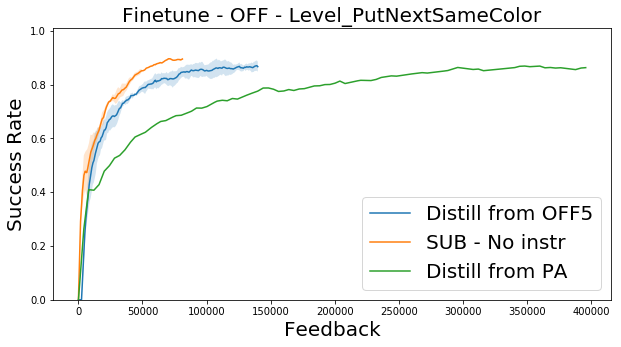

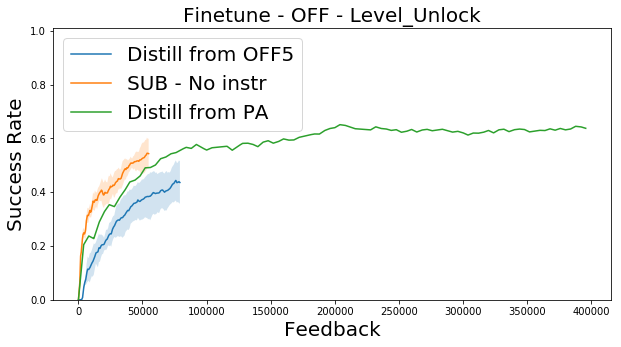

In [32]:
# DOES distilling less help?
runs = [
    (['T2328', 'T2329', 'T2330'], 'Distill from OFF5', 800),
    (['T2333', 'T2334', 'T2335'], 'Distill from OFF5', 800),
#     (['T2340', 'T2341'], 'Distill from PA', 800 * 3),
#     (['T2368', 'T2369'], 'SUB - instr', 1),
#     (['T2376', 'T2377'], 'SUB - instr', 1),
    (['T2401', 'T2402'], 'SUB - No instr', 1),
    (['T2403', 'T2404'], 'SUB - No instr', 1),
    (['T2405', 'T2406'], 'Distill from PA', 1),
]
# plt.xlim(0, 40000)

plt.rcParams['figure.figsize'] = [10, 5]
plot_finetune_generalization(runs, 'Finetune - OFF', smooth=50, x_label='Feedback', y_label="Success Rate")
print("=====================================")

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds
Error on  ['T2221_', 'T2239'] single positional indexer is out-of-bounds


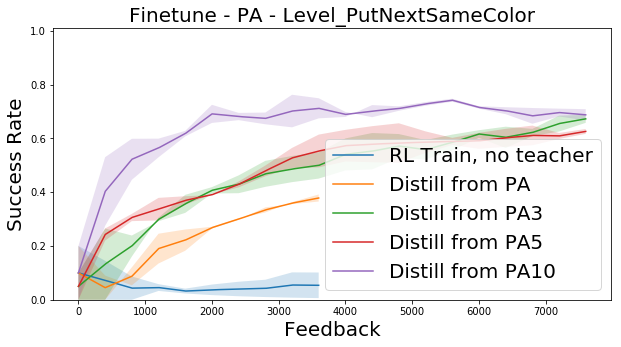

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds
Error on  ['T2223_', 'T2241'] single positional indexer is out-of-bounds


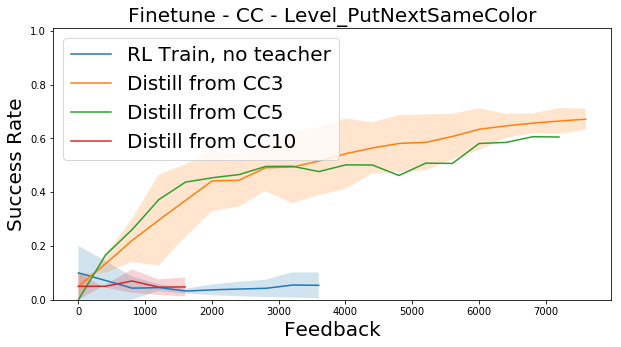

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds


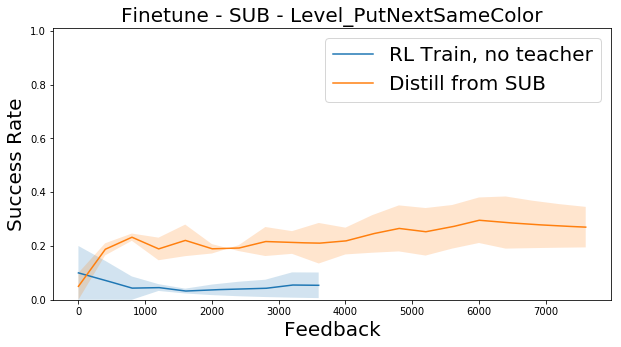

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds


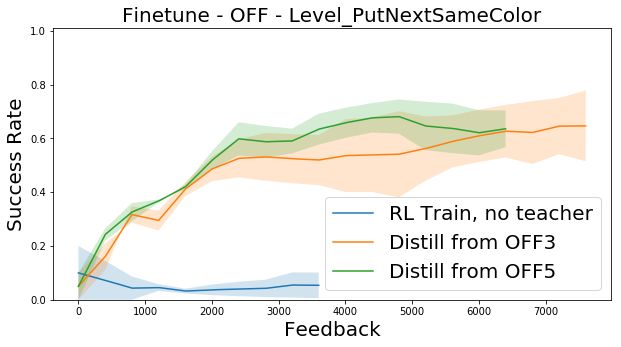

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds
Error on  ['T2226', 'T2244'] single positional indexer is out-of-bounds


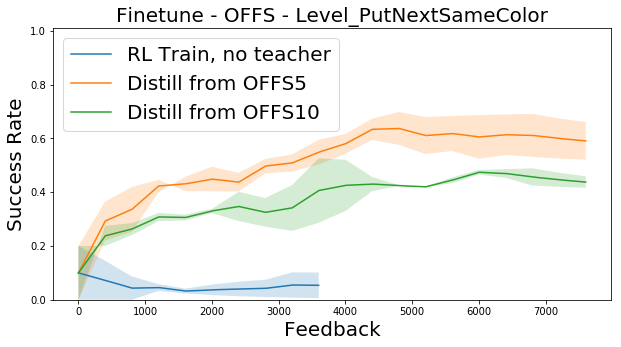

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds


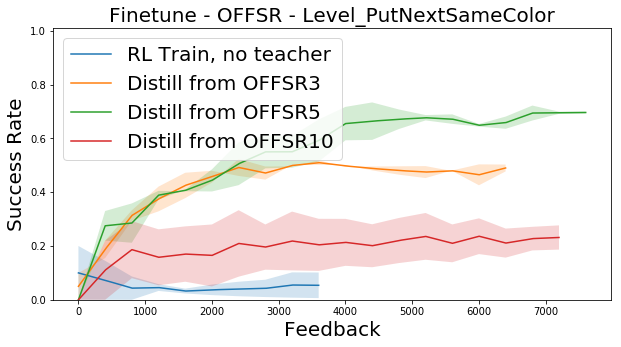

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds
Error on  ['T2223_', 'T2241'] single positional indexer is out-of-bounds
Error on  ['T2226', 'T2244'] single positional indexer is out-of-bounds


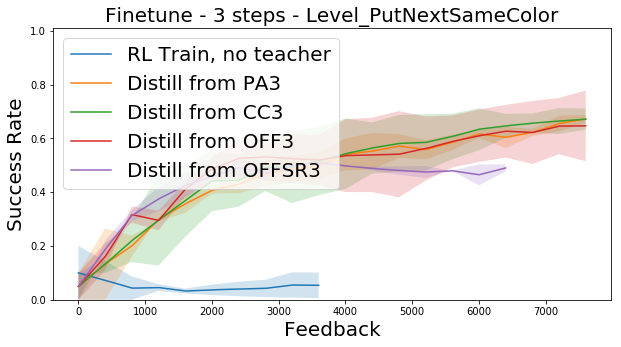

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds


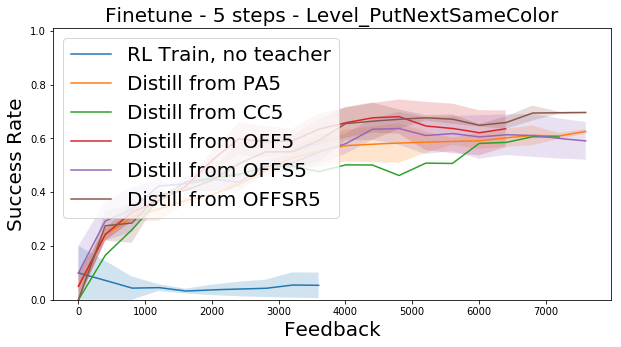

Error on  ['T2220_', 'T2238'] single positional indexer is out-of-bounds


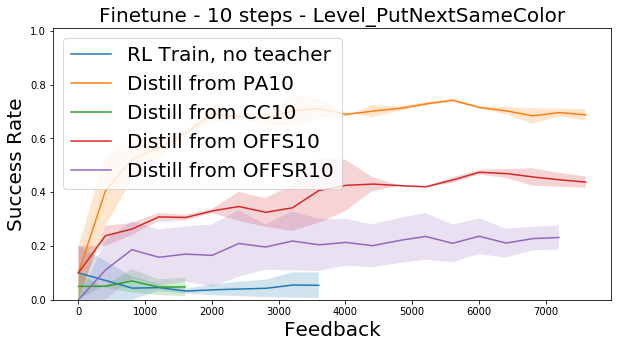

In [20]:


runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2221B', 'T2239'], 'Distill from PA', 400),
    (['T2221_', 'T2239'], 'Distill from PA', 400),
    (['T2222', 'T2240'], 'Distill from PA3', 400),
    (['T2228', 'T2246'], 'Distill from PA5', 400),
    (['T2233', 'T2251'], 'Distill from PA10', 400),
]
plot_finetune_generalization(runs, 'Finetune - PA', smooth=10, x_label='Feedback', y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2223B', 'T2241'], 'Distill from CC3', 400),
    (['T2223_', 'T2241'], 'Distill from CC3', 400),
    (['T2229', 'T2247'], 'Distill from CC5', 400),
    (['T2256', 'T2256'], 'Distill from CC5', 400),
    (['T2234', 'T2252'], 'Distill from CC10', 400),
    (['T2259', 'T2263'], 'Distill from CC10', 400),
]
plot_finetune_generalization(runs, 'Finetune - CC', smooth=10, x_label='Feedback', y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2225', 'T2243'], 'Distill from SUB', 400),
]
plot_finetune_generalization(runs, 'Finetune - SUB', smooth=10, x_label='Feedback', y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")
runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2224', 'T2242'], 'Distill from OFF3', 400),
    (['T2230', 'T2248'], 'Distill from OFF5', 400),
    (['T2257', 'T2261'], 'Distill from OFF5', 400),
    (['T2235', 'T2253'], 'Distill from OFF10', 400),
]
plot_finetune_generalization(runs, 'Finetune - OFF', smooth=10, x_label='Feedback', y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")
runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2226', 'T2244'], 'Distill from OFFS3', 400),
    (['T2231', 'T2249'], 'Distill from OFFS5', 400),
    (['T2236', 'T2254'], 'Distill from OFFS10', 400),
]
plot_finetune_generalization(runs, 'Finetune - OFFS', smooth=10, x_label='Feedback', y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2227', 'T2245'], 'Distill from OFFSR3', 400),
    (['T2232', 'T2250'], 'Distill from OFFSR5', 400),
    (['T2237', 'T2255'], 'Distill from OFFSR10', 400),
]
plot_finetune_generalization(runs, 'Finetune - OFFSR', smooth=10, x_label='Feedback', y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2222', 'T2240'], 'Distill from PA3', 400),
    (['T2223B', 'T2241'], 'Distill from CC3', 400),
    (['T2223_', 'T2241'], 'Distill from CC3', 400),
    (['T2224', 'T2242'], 'Distill from OFF3', 400),
    (['T2226', 'T2244'], 'Distill from OFFS3', 400),
    (['T2227', 'T2245'], 'Distill from OFFSR3', 400),
    (['T2264'], 'Distill from Oracle', 400),
]
plot_finetune_generalization(runs, 'Finetune - 3 steps', smooth=10, x_label='Feedback', 
                             y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")


runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2228', 'T2246'], 'Distill from PA5', 400),
    (['T2229', 'T2247'], 'Distill from CC5', 400),
    (['T2256', 'T2256'], 'Distill from CC5', 400),
    (['T2230', 'T2248'], 'Distill from OFF5', 400),
    (['T2257', 'T2261'], 'Distill from OFF5', 400),
    (['T2231', 'T2249'], 'Distill from OFFS5', 400),
    (['T2232', 'T2250'], 'Distill from OFFSR5', 400),
    (['T2264'], 'Distill from Oracle', 400),
]
plot_finetune_generalization(runs, 'Finetune - 5 steps', smooth=10, x_label='Feedback', 
                             y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")
runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2233', 'T2251'], 'Distill from PA10', 400),
    (['T2234', 'T2252'], 'Distill from CC10', 400),
    (['T2259', 'T2263'], 'Distill from CC10', 400),
    (['T2235', 'T2253'], 'Distill from OFF10', 400),
    (['T2236', 'T2254'], 'Distill from OFFS10', 400),
    (['T2237', 'T2255'], 'Distill from OFFSR10', 400),
    (['T2264'], 'Distill from Oracle', 400),
]
plot_finetune_generalization(runs, 'Finetune - 10 steps', smooth=10, x_label='Feedback', 
                             y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")

In [ ]:
runs = [
    (['T2264'], 'Distill from Oracle', 400),
]
plot_finetune_generalization(runs, 'Finetune - 10 steps', smooth=10, x_label='Feedback', 
                             y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")

In [ ]:
# ALL RUNS!

# runs = [
#     (['T2220B'], 'RL Train, no teacher', 400),
#     (['T2220_'], 'RL Train, no teacher', 400),
#     (['T2221B'], 'Distill from PA', 400),
#     (['T2221_'], 'Distill from PA', 400),
#     (['T2222'], 'Distill from PA3', 400),
#     (['T2223'], 'Distill from CC3', 400),
#     (['T2224'], 'Distill from OFF3', 400),
#     (['T2225'], 'Distill from SUB', 400),
#     (['T2226'], 'Distill from OFFS3', 400),
#     (['T2227'], 'Distill from OFFSR3', 400),
#     (['T2228'], 'Distill from PA5', 400),
#     (['T2229'], 'Distill from CC5', 400),
#     (['T2230'], 'Distill from OFF5', 400),
#     (['T2231'], 'Distill from OFFS5', 400),
#     (['T2232'], 'Distill from OFFSR5', 400),
#     (['T2233'], 'Distill from PA10', 400),
#     (['T2234'], 'Distill from CC10', 400),
#     (['T2235'], 'Distill from OFF10', 400),
#     (['T2236'], 'Distill from OFFS10', 400),
#     (['T2237'], 'Distill from OFFSR10', 400),
# ]



runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 1),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 1),
    (['T2221B', 'T2239'], 'Distill from PA', 1),
    (['T2221_', 'T2239'], 'Distill from PA', 1/3),
    (['T2222', 'T2240'], 'Distill from PA3', 1/ 3),
    (['T2228', 'T2246'], 'Distill from PA5', 1 / 10),
    (['T2233', 'T2251'], 'Distill from PA10', 1 / 10),
]
plot_finetune_generalization(runs, 'Finetune - PA UNALIGNED BAD BAD BAD', smooth=10, 
                             x_label='Feedback', y_label="Success Rate", 
                             all_run_names=['Level_PutNextSameColor'])
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 1),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 1),
    (['T2221B', 'T2239'], 'Distill from PA', 1),
    (['T2221_', 'T2239'], 'Distill from PA', 3),
    (['T2222', 'T2240'], 'Distill from PA3', 3),
    (['T2228', 'T2246'], 'Distill from PA5', 10),
    (['T2233', 'T2251'], 'Distill from PA10', 10),
]
plot_finetune_generalization(runs, 'Finetune - PA UNALIGNED BAD BAD BAD', smooth=10, x_label='Feedback', 
                             y_label="Success Rate", all_run_names=['Level_PutNextSameColor'])
print("=====================================")


runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2221B', 'T2239'], 'Distill from PA', 400),
    (['T2221_', 'T2239'], 'Distill from PA', 400),
    (['T2222', 'T2240'], 'Distill from PA3', 400),
    (['T2228', 'T2246'], 'Distill from PA5', 400),
    (['T2233', 'T2251'], 'Distill from PA10', 400),
]
plot_finetune_generalization(runs, 'Finetune - PA', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2223B', 'T2241'], 'Distill from CC3', 400),
    (['T2223_', 'T2241'], 'Distill from CC3', 400),
    (['T2229', 'T2247'], 'Distill from CC5', 400),
    (['T2234', 'T2252'], 'Distill from CC10', 400),
]
plot_finetune_generalization(runs, 'Finetune - CC', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2225', 'T2243'], 'Distill from SUB', 400),
]
plot_finetune_generalization(runs, 'Finetune - SUB', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")
runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2224', 'T2242'], 'Distill from OFF3', 400),
    (['T2230', 'T2248'], 'Distill from OFF5', 400),
    (['T2235', 'T2253'], 'Distill from OFF10', 400),
]
plot_finetune_generalization(runs, 'Finetune - OFF', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")
runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2226', 'T2244'], 'Distill from OFFS3', 400),
    (['T2231', 'T2249'], 'Distill from OFFS5', 400),
    (['T2236', 'T2254'], 'Distill from OFFS10', 400),
]
plot_finetune_generalization(runs, 'Finetune - OFFS', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2227', 'T2245'], 'Distill from OFFSR3', 400),
    (['T2232', 'T2250'], 'Distill from OFFSR5', 400),
    (['T2237', 'T2255'], 'Distill from OFFSR10', 400),
]
plot_finetune_generalization(runs, 'Finetune - OFFSR', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")

runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2222', 'T2240'], 'Distill from PA3', 400),
    (['T2223B', 'T2241'], 'Distill from CC3', 400),
    (['T2223_', 'T2241'], 'Distill from CC3', 400),
    (['T2224', 'T2242'], 'Distill from OFF3', 400),
    (['T2226', 'T2244'], 'Distill from OFFS3', 400),
    (['T2227', 'T2245'], 'Distill from OFFSR3', 400),
]
plot_finetune_generalization(runs, 'Finetune - 3 steps', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")


runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2228', 'T2246'], 'Distill from PA5', 400),
    (['T2229', 'T2247'], 'Distill from CC5', 400),
    (['T2230', 'T2248'], 'Distill from OFF5', 400),
    (['T2231', 'T2249'], 'Distill from OFFS5', 400),
    (['T2232', 'T2250'], 'Distill from OFFSR5', 400),
]
plot_finetune_generalization(runs, 'Finetune - 5 steps', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")
runs = [
    (['T2220B', 'T2238'], 'RL Train, no teacher', 400),
    (['T2220_', 'T2238'], 'RL Train, no teacher', 400),
    (['T2233', 'T2251'], 'Distill from PA10', 400),
    (['T2234', 'T2252'], 'Distill from CC10', 400),
    (['T2235', 'T2253'], 'Distill from OFF10', 400),
    (['T2236', 'T2254'], 'Distill from OFFS10', 400),
    (['T2237', 'T2255'], 'Distill from OFFSR10', 400),
]
plot_finetune_generalization(runs, 'Finetune - 10 steps', smooth=10, x_label='Feedback', y_label="Success Rate")
print("=====================================")

In [ ]:
# Trained on PutNext
# All from run 2046
runs = [
    (['T2054', 'T2057', 'T2060'], 'Distill from PA', 800),
    (['T2055', 'T2058', 'T2061'], 'Distill from PA3', 800),
    (['T2056', 'T2059', 'T2062'], 'RL Train, no teacher', 800),
]
plot_finetune_generalization(runs, 'Finetune', smooth=1, x_label='Feedback', y_label="Success Rate")


# Trained on four_levels
# runs = [
#     (['T2075', 'T2083', 'T2085'], '2047 PA (no PA3)', 1),
#     (['T2072', 'T2077', 'T2080'], '2048 PA', 1),
#     (['T2073', 'T2078', 'T2081'], '2048 PA3', 1),
#     (['T2074', 'T2079', 'T2082'], '2048 None', 1),
#     (['T2076', 'T2084', 'T2086'], '2048 None', 1),
# ]
runs = [
    (['T2072', 'T2077', 'T2080'], 'Distill from PA', 800),
    (['T2073', 'T2078', 'T2081'], 'Distill from PA3', 800),
    (['T2074', 'T2079', 'T2082'], 'RL Train, no teacher', 800),
]

plot_finetune_generalization(runs, 'Rollout with no teacher', smooth=1, x_label='Feedback', y_label="Success Rate")

In [ ]:
# Trained on four_levels, CC3 (run 2052)
runs = [
    (['T2087', 'T2089'], 'Distill from PA', 800),
    (['T2088', 'T2090'], 'Distill from CC3', 800),
]
plot_finetune_generalization(runs, 'Finetune, CC3', smooth=3, x_label='Feedback', y_label="Success Rate")

# Trained on four_levels, OFF3 (run 2053)
runs = [
    (['T2091'], 'Distill from PA', 800),
    (['T2092'], 'Distill From OFF3', 800),
]
plot_finetune_generalization(runs, 'Finetune, OFF', smooth=3, x_label='Feedback', y_label="Success Rate")

In [ ]:
# Diff acc thresholds, PA
runs = [
    (['T2109'], '2093 PA Near-Perfect', 800),
    (['T2098'], '2093 PA .98', 800),
    (['T2097'], '2093 PA .95', 800),
]
plot_finetune_generalization(runs, 'Finetune, PA', smooth=1, x_label='Feedback', y_label="Success Rate")


runs = [
    (['T2101'], '2094 PA3 .98', 800),
    (['T2100'], '2094 PA3 .95', 800),
    (['T2099'], '2094 PA3 .9', 800),
]
plot_finetune_generalization(runs, 'Finetune, PA3', smooth=1, x_label='Feedback', y_label="Success Rate")


runs = [
    (['T2100'], '2094 CC3 .95', 1),
    (['T2099'], '2094 CC3 .9', 1),
    (['T2097'], '2094 CC3 .8', 1),
]
plot_finetune_generalization(runs, 'Finetune, CC3', smooth=1, x_label='Feedback', y_label="Success Rate")


runs = [
    (['T2108'], '2094 CC3 .98', 1),
    (['T2107'], '2094 CC3 .95', 1),
    (['T2106'], '2094 CC3 .9', 1),
    (['T2105'], '2094 CC3 .8', 1),
]
plot_finetune_generalization(runs, 'Finetune, OFF3', smooth=1, x_label='Feedback', y_label="Success Rate")

## Distillation steps? [5 seems best, but no big difference]

In [ ]:
runs = [
    (['T2063'], '1', 1),
    (['T2064'], '5', 1),
    (['T2054'], '10', 1), # , 'T2057', 'T2060'
    (['T2065'], '20', 1),
    (['T2066'], '30', 1),
]
plot_finetune_generalization(runs, 'Finetune', smooth=3)

In [ ]:
runs = [
    (['T2054', 'T2057', 'T2060'], '2046 PA', 1),
    (['T2055', 'T2058', 'T2061'], '2046 PA3', 1),
    (['T2056', 'T2059', 'T2062'], '2046 None', 1),
]
plot_finetune_generalization(runs, 'Finetune', smooth=3)

# <font color='blue'> Claim 8: we can (largely) remove the reward during training once the first teacher is grounded.  </font> 

## <font color='blue'> [Status: Early results show it helps for PA, not SUB].  </font> 

Let's test this by taking PA (the easiest teacher to learn) and seeing at what point during training it can zero-shot solve the entire curriculum.

## <font color='blue'> [Helper] See how early through the curriculum we can remove the reward. </font>

Currently suggests there's no one point where the reward can be removed; we need to keep checking it it and training if needed.

In [ ]:
runs = [
    (['EVAL_ALL_LEVELS_627'], 'PA'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')

In [ ]:
runs = [
    (['EVAL_PA_EARLY_FINAL_455'], 'PA'),
    (['EVAL_PA_EARLY_455_mid'], 'PA'),
]
plot_curriculum_generalization(runs, 'Eval with Teacher')

## <font color='blue'> [Helper] See if we can zero-shot some levels. </font>

In [ ]:
data_names = [
    (['0540'], 'PA'),
    (['676'], 'PA No 10 Delay'),
#     (['677', '678'], "PA Don't train each level"),  # TODO: This one doesn't actually skip training on some levels
]
plot_curriculum(data_names, 'feedback')

## <font color='blue'> [Main] Remove reward during training when possible </font>

Tries reward periodically. If the agent succeeds, we skip training for the next few itrs.

NOTE: Would probably make more sense to separate sparse vs per-timestep rewards. Only provide per-timestep rewards if the agent is failing at getting the sparse rewards.

In [ ]:
data_names = [
    (['0729_PA', '0730'], 'PA Distill, Sometimes Reward'),
    (['0627', '0628'], 'PA Distill, Always reward'),
]
plot_curriculum(data_names, 'feedback')
plot_curriculum(data_names, 'samples')

In [ ]:
data_names = [
    (['735', '736'], 'PA -> Sub Distill, Sometimes Reward'),
    (['668', '669'], 'PA -> Sub Distill, Always reward'),
]
plot_curriculum(data_names, 'feedback')
plot_curriculum(data_names, 'samples')

# <font color='purple'> Leaderboard - Curriculum Learning  </font>

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

In [ ]:
methods = [
    (['0437'], "Distill from PA, Default", "Standard HParams, train PA, distill to powerset"), # TODO: placeholder; hasn't actually succeeded yet
]

plot_leaderboard(methods)


# <font color='green'> Leaderboard - Curriculum Learning (no distillation)  </font>

Keep track of the current best methods of learning a curriculum (ranked by feedback-efficiency).

In [ ]:
methods = [
    (['0539', '0540'], "Train PA, Default", "Standard HParams, train PA"),
    (['0577', '0578'], "Train PA, Sparse", "Standard HParams, train PA"),
]

plot_leaderboard(methods)


# <font color='blue'> Leaderboard - Few-Shot Generalization </font>


Keep track of the current best methods of few-shot learning heldout levels (ranked by feedback-efficiency).

TODO

# <font color='purple'> Miscellaneous Other Plots </font> <font color='red'> [TODO: plot sweeps] </font>

## <font color='purple'> Does bigger batch size help? </font>

Conclusion: It helps when subgoals not distilling, but doesn't help when distilling. We should check whether this holds for other teachers.

In [ ]:
data_names = [
    (['0547', '0548'], 'SUB Nodistill, Small batch'),
    (['0722', '0723', '688'], 'SUB Nodistill, Big batch'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['718', '719', '636', '0635'], 'SUB Distill, Small batch'),
    (['690'], 'SUB Distill, Big batch'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB Distill, Small batch'),
    (['726', '725', '724'], 'PA->SUB Distill, Big batch'),
]
plot_curriculum(data_names, 'feedback')



### No distillation

In [ ]:
# NO DISTILLATION

data_names = [
    (['0540'], 'PA'),
    (['692', '693'], 'PA - BIG'),
]
plot_curriculum(data_names, 'samples')  # WORSE

data_names = [
    (['0543', '0544'], 'CC2'),
    (['694', '695'], 'CC2 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0545', '0546'], 'CC3'),
    (['696', '697'], 'CC3 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0547', '0548'], 'SUB'),
    (['688'], 'SUB - BIG'),
]
plot_curriculum(data_names, 'samples')


### Distillation

In [ ]:
data_names = [  # TODO: re-run these 
    (['0627', '0628'], 'PA'),
    (['698', '699'], 'PA - BIG')
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0631', '0632'], 'CC2'),
    (['700', '701'], 'CC2 - BIG'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0633', '0634'], 'CC3'),
    (['702', '703'], 'CC3 - BIG')
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0635', '0636'], 'SUB'),
    (['690'], 'SUB - BIG')
]
plot_curriculum(data_names, 'samples')

## <font color='purple'> Does a bigger model help? </font>

Helps a little bit...

In [ ]:
# data_names = [
#     (['0547', '0548'], 'SUB Nodistill, Small model'),
#     (['0722', '0723', '688'], 'SUB Nodistill, Big model'),
# ]
# plot_curriculum(data_names, 'feedback')

data_names = [
    (['718', '719', '636', '0635'], 'SUB Distill, Small model'),
    (['714', '715', '664'], 'SUB Distill, Big model'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB Distill, Small model'),
    (['716', '717'], 'PA->SUB Distill, Big model'),
]
plot_curriculum(data_names, 'feedback')


## <font color='purple'> Does self-distillation help? </font>

In [ ]:
data_names = [
    (['692', '693'], 'PA Normal'),
    (['0706', '0707'], 'PA Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0543', '0544'], 'CC2 Normal'),
    (['0704', '0705'], 'CC2 Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0545', '0546'], 'CC3 Normal'),
    (['682', '683'], 'CC3 Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0722', '0723', '688'], 'SUB Normal'),
    (['684', '685'], 'SUB Self-Distill'),
]
plot_curriculum(data_names, 'feedback')

## <font color='purple'> Does buffer size help?  </font>

## <font color='purple'> Does raising the RL accuracy threshold size help?  </font>

In [ ]:
data_names = [
    (['0627', '0628'], 'PA Distill, Normal Acc'),
    (['0737', '0738'], 'PA Distill, High Acc'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['0666', '0667'], 'PA->CC3 Distill, Normal Acc'),
    (['0739', '0740'], 'PA->CC3 Distill, High Acc'),
]
plot_curriculum(data_names, 'feedback')

data_names = [
    (['720', '721', '668', '669'], 'PA->SUB, Normal Acc'),
    (['0741', '0742'], 'PA->SUB, High Acc'),
]
plot_curriculum(data_names, 'feedback')


## <font color='purple'> Does lowering the discount help?  </font>

In [ ]:
data_names = [
    (['720', '721', '668', '669'], 'PA->SUB, Normal Discount'),
    (['743', '744'], 'PA->SUB, Discount .1'),
]
plot_curriculum(data_names, 'feedback')

## <font color='purple'> Does the way we collect labels matter?  </font>

In [ ]:
data_names = [
    (['0821', '0822'], 'PA->CC3 Default'),
#     (['0825', '0826'], 'PA->CC3 Big Batch'),
    (['833', '834'], 'PA->CC3 Argmax'),
    (['835', '836'], 'PA->CC3 Agent dist'),
    (['837', '838'], 'PA->CC3 Teacher'),
]
plot_curriculum(data_names, 'samples')

## <font color='purple'> Does DAgger help?  </font>

In [ ]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0943', '0944'], 'PA->CC3 Normal'),
    (['0993', '0994'], 'PA->CC3 DAgger'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Success', smooth=100, 
                level_start=0, level_end=12, title="PA RL Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

## <font color='purple'> Does using a separate model help?  </font>

In [ ]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['839', '840'], 'PA->CC3 Separate'),
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Does re-weighting help?  </font>

In [ ]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0825', '0826'], 'PA->CC3 NEW3'),
    (['817', '180'], 'PA->CC3 Re-Weight'),
    (['813', '814'], 'PA->CC3 Re-Weight Pretrained'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['827', '828'], 'PA->SUB NEW3'),
    (['819', '820'], 'PA->SUB Re-Weight'),
    (['815', '816'], 'PA->SUB Re-Weight Pretrained'),
]
plot_curriculum(data_names, 'samples')


## <font color='purple'> Hyperparameter tuning (included dropout and pretrained)  </font>

In [ ]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [
    (['0627', '0628'], 'PA'),
#     (['0753', '0754'], 'PA NEW'),
    (['0787', '0788'], 'PA NEW2'),
    (['867', '868'], 'PA NEW3 - no argmax no bigbatch'),
    (['801', '802'], 'PA Dropout 2'),
]
plot_curriculum(data_names, 'samples')

data_names = [
    (['0666', '0667'], 'PA->CC3'),
#     (['0755', '0756'], 'PA->CC3 NEW'),
    (['0789', '0790'], 'PA->CC3 NEW2'),
    (['0825', '0826'], 'PA->CC3 NEW3 - no argmax'),
    (['0821', '0822'], 'PA->CC3 NEW3 - no argmax no bigbatch'),
    (['803', '804'], 'PA->CC3 Dropout 2'),
    (['859', '860'], 'Pretrained CC3 -> None'),
]
plot_curriculum(data_names, 'samples')
data_names = [
    (['0668', '0669'], 'PA->SUB'),
#     (['0757', '0758'], 'PA->SUB NEW'),
    (['0791', '0792'], 'PA->SUB NEW2'),
    (['827', '828'], 'PA->SUB NEW3 - no argmax'),
    (['0823', '0824'], 'PA->SUB NEW3 - no argmax no bigbatch'),
    (['805', '806'], 'PA->SUB Dropout 2'),
]
plot_curriculum(data_names, 'samples')
data_names = [
    (['0481'], 'None'),
    (['0751', '0752'], 'None NEW'),
    (['0785', '0786'], 'None NEW2'),
]
plot_curriculum(data_names, 'samples')




In [ ]:
# COMPARING NEW HPARAMS TO OLD ONES

data_names = [  # TODO: re-run these 
    (['0779', '0780'], 'PA (nodistill)'),
    (['0627', '0628'], 'PA'),
    (['0753', '0754'], 'PA NEW'),
    (['0787', '0788'], 'PA NEW2'),
    (['0759', '0760'], 'PA PRETRAINED'),
    (['0793', '0794'], 'PA PRETRAINED2'),
    (['801', '802'], 'PA Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [  # TODO: re-run these 
    (['0781', '0782'], 'PA->CC3 (nodistill)'),
    (['0666', '0667'], 'PA->CC3'),
    (['0755', '0756'], 'PA->CC3 NEW'),
    (['0789', '0790'], 'PA->CC3 NEW2'),
    (['0761', '0762'], 'CC3 PRETRAINED'),
    (['0795', '0796'], 'CC3 PRETRAINED2'),
    (['803', '804'], 'PA->CC3 Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [  # TODO: re-run these 
    (['0783', '0784'], 'PA->SUB (nodistill)'),
    (['0668', '0669'], 'PA->SUB'),
    (['0757', '0758'], 'PA->SUB NEW'),
    (['0791', '0792'], 'PA->SUB NEW2'),
    (['0763_SUB_teacherSub', '0764_SUB_teacherSub'], 'SUB PRETRAINED'),
    (['0797', '0798'], 'SUB PRETRAINED2'),
    (['805', '806'], 'PA->SUB Dropout'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')

data_names = [
    (['799', '800'], 'None Oracle'),
    (['0481'], 'None'),
    (['0751', '0752'], 'None NEW'),
    (['0785', '0786'], 'None NEW2'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'feedback')




## <font color='purple'> Trying to get high accuracy  </font>

Distill to no teacher from BCS model

In [ ]:
data_names = [ 
    (['845', '846'], 'PA'),
    (['847', '848'], 'CC3'),
    (['849', '850'], 'SUB'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['847', '848'], 'BCS CC3 -> None'),
    (['859', '860'], 'Pretrained CC3 -> None'),
    (['821', '822'], 'PA -> CC3 -> None'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['849', '850'], 'BCS SUB -> None'),
    (['861', '862'], 'Pretrained SUB -> None'),
    (['823', '824'], 'PA -> SUB -> None'),
]
plot_curriculum(data_names, 'samples')

BCS (oracle -> teacher) vs Pseudo-BCS (Pretrained PA --> Teacher) vs Bootstrap (PA --> Teacher)

Takeaway: bootstrapping from PA is almost as good as bootstrapping from the oracle~

In [ ]:
data_names = [ 
    (['659'], 'Oracle -> CC3'),
    (['851'], 'Pretrained PA -> CC3'),
    (['855', '856'], 'PA -> CC3'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['661'], 'Oracle -> SUB'),
    (['853', '854'], 'Pretrained PA -> SUB'),
    (['857', '858'], 'PA -> SUB'),
]
plot_curriculum(data_names, 'samples')


Distill with distribution less biased toward current level

In [ ]:

data_names = [ 
    (['863', '864'], 'CC3 .2 current'),
    (['821', '822'], 'CC3 .5 current'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['865', '866'], 'SUB .2 current'),
    (['823', '824'], 'SUB .5 current'),
]
plot_curriculum(data_names, 'samples')

Way more distillation itrs

In [ ]:

data_names = [ 
    (['821', '822'], 'CC3 Normal'),
    (['869', '870'], 'CC3 More Itrs'),
    (['899', '900'], 'CC3 Even More Itrs'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'SUB Normal'),
    (['871', '872'], 'SUB More Itrs'),
    (['901', '902'], 'SUB Even More Itrs'),
]
plot_curriculum(data_names, 'samples')

High accuracy + run forever (goal is to see if generalization improves)

In [ ]:
data_names = [ 
    (['0821', '0822'], 'PA -> CC3 Normal'),
    (['0873', '0874'], 'PA -> CC3 High Acc'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['875', '876'], 'PA -> SUB High Acc'),
]
plot_curriculum(data_names, 'samples')

Does increasing the acc threshold when we're using PA help?

In [ ]:
data_names = [ 
    (['821', '822'], 'PA -> CC3 Normal'),
    (['0903', '0904'], 'PA -> CC3 High Acc'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['0905', '0906'], 'PA -> SUB High Acc'),
]
plot_curriculum(data_names, 'samples')

Does increasing LR help?

In [ ]:
data_names = [ 
    (['821', '822'], 'PA -> CC3 Normal'),
    (['0907', '0908'], 'PA -> CC3 High LR'),
    (['0911', '0912'], 'PA -> CC3 High LR2'),
]
plot_curriculum(data_names, 'samples')

data_names = [ 
    (['823', '824'], 'PA -> SUB Normal'),
    (['0909', '0910'], 'PA -> SUB High LR'),
    (['0913', '0914'], 'PA -> SUB High LR2'),
]
plot_curriculum(data_names, 'samples')

Does high acc + low entropy help?

In [ ]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0931', '0932'], 'PA -> CC3 Help'), # Third best; cheats by using PA a lot
#     (['0933', '0934'], 'PA -> CC3 Help + RL Acc .9'), # Second Best; cheats by using PA a lot
#     (['0935', '0936'], 'PA -> CC3 -> None'), # Not great; stoppable
#     (['0937', '0938'], 'PA -> CC3 -> None + RL Acc .9'), # Best; cheats by using PA a lot
#     (['0939', '0940'], 'PA -> CC3 -> None + High PA Acc'), # Not great; stoppable
    (['0955', '0956'], 'PA -> CC3  Ent /10'),
#     (['0963', '0964'], 'PA -> CC3 -> None + RL Acc .9 Ent /10'), # Bad; stoppable, but we should analyze
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

In [ ]:
data_names = [ 
    (['867', '868'], 'PA Normal'),
    (['0953', '0954'], 'PA Ent /10, RL Acc .9'),
    (['0957', '0958'], 'PA Ent /100, RL Acc .9'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

Combining argmax, sample, logits

In [ ]:
data_names = [ # TODO: GENERALIZATION!!!
#     (['0967', '0968'], 'PA -> CC3 Argmax'), # BAD; all others are basically the same
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0973', '0974'], 'PA -> CC3 Argmax + no self-distill'),
    (['0975', '976'], 'PA -> CC3 Logits + no self-distill'),
    (['977', '978'], 'PA -> CC3 Logits'),
]
plot_curriculum(data_names, 'samples')

Higher entropy first 10 itrs

In [ ]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
    (['0983', '0984'], 'PA -> CC3 Argmax'),
]
plot_curriculum(data_names, 'samples')
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
]

plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="RL Train Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

In [ ]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
    (['0983', '0984'], 'PA -> CC3 Argmax'),
]
plot_curriculum(data_names, 'samples')
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0951', '0952'], 'CC3 Normal'),
    (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
]

plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="RL Train Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

Fake CC3 labels

In [ ]:
data_names = [ 
    (['0943', '0944'], 'PA -> CC3 Normal'),
    (['0985', '0986'], 'PA -> CC3 Fake CC3 labels + self-distill'),
    (['0986', '0987'], 'PA -> CC3 Fake CC3 labels no self-distill'),
    (['0995', '0996'], 'PA -> CC3 Fake CC3 labels logits'),
]
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy Through Bootstrapping")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy Through Bootstrapping")

In [ ]:
data_names = [ 
    (['979', '980'], 'PA -> CC3 logits'),
#     (['967', '968'], 'PA -> CC3 Argmax'),
#     (['977', '978'], 'PA -> CC3 Normal (logits, no self-distill)'),
    (['0975', '0976'], 'PA -> CC3 sampling'),
    (['0991', '0992'], 'PA -> CC3 Source Teacher'),
    (['0985', '0986'], 'PA -> CC3 Fake CC3 Feedback sampling'),
    (['0995', '0996'], 'PA -> CC3 Fake CC3 labels logits'),
#     (['867', '868'], 'PA'),
    (['0997', '0998', '1033'], 'Distill from  oracle'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

In [ ]:
data_names = [ 
    (['1033'], 'Distill from  oracle'),
]

for i in range(3, 12):
    plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=1, 
                level_start=i, level_end=i, title=f"Level {i}")

In [ ]:
data_names = [ 
#     (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
    (['1072'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8'),
    (['1073'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9'),
    (['0997', '0998'], 'Distill from  oracle'),
    (['1145'], 'PA -> CC3 easy_swap_harder logits threshold_distill .9'),
    (['1146'], 'PA -> Distill from  oracle threshold_distill .9'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DRollout/AvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="No Teacher Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DRollout/AverageSuccess', smooth=10, 
                level_start=0, level_end=12, title="NoTeacher Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

In [ ]:
data_names = [ 
#     (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
    (['1072'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .8'),
    (['1073'], 'PA -> CC3 easy_swap_harder logits DAgger threshold_distill .9'),
    (['0997', '0998'], 'Distill from  oracle'),
]


# self-dsitill is good!

plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAverageSuccess', smooth=100, 
                level_start=0, level_end=12, title="CC3 Rollout Success on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Train")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="Label Accuracy Val")

## How can we get good PA accuracy?

In [ ]:
data_names = [ 
#     (['867', '868'], 'PA Normal'),
    (['0953', '0954'], 'PA Ent /10, RL Acc .9'),
#     (['0957', '0958'], 'PA Ent /100, RL Acc .9'),
#     (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0931', '0932'], 'PA -> CC3 Help'), # Third best; cheats by using PA a lot
#     (['0933', '0934'], 'PA -> CC3 Help + RL Acc .9'), # Second Best; cheats by using PA a lot
#     (['0935', '0936'], 'PA -> CC3 -> None'), # Not great; stoppable
#     (['0937', '0938'], 'PA -> CC3 -> None + RL Acc .9'), # Best; cheats by using PA a lot
#     (['0939', '0940'], 'PA -> CC3 -> None + High PA Acc'), # Not great; stoppable
#     (['0955', '0956'], 'PA -> CC3  Ent /10'),
#     (['0963', '0964'], 'PA -> CC3 -> None + RL Acc .9 Ent /10'), # Bad; stoppable, but we should analyze
    (['0895', '0896'], 'PA -> CC3 Nodistill'), # Bad; stoppable, but we should analyze
#     (['0943', '0944'], 'PA -> CC3 Normal'),
#     (['0951', '0952'], 'CC3 Normal'),
#     (['0967', '0968'], 'PA -> CC3 Argmax Normal'),
#     (['0981', '0982'], 'PA -> CC3 Sample ent / 10'),
#     (['0983', '0984'], 'PA -> CC3 Argmax'),
    (['979', '980'], 'PA -> CC3 logits'),
#     (['967', '968'], 'PA -> CC3 Argmax'),
#     (['977', '978'], 'PA -> CC3 Normal (logits, no self-distill)'),
#     (['0975', '0976'], 'PA -> CC3 sampling'),
#     (['0991', '0992'], 'PA -> CC3 Source Teacher'),
#     (['0985', '0986'], 'PA -> CC3 Fake CC3 Feedback sampling'),
    (['867', '868'], 'PA distill sample'),
    
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['0877', '0878'], 'PA Nodistill'),
#     (['0919', '0920'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")

 Can we get good PA Acc?

In [ ]:
data_names = [ 
    (['0999'], 'PA -> PA logits'),
    (['1000'], 'PA -> PA distill logits'),
    (['1003'], 'PA -> CC3 easy_swap_harder_noselfdistill logits'),
    (['1006'], 'PA -> CC3 easy_swap_harder logits nodistill'),
    (['1007'], 'PA -> CC3 easy_swap_harder logits ent / 10'),
    (['1008'], 'PA -> CC3 easy_swap_harder logits ent / 100'),
    (['1009'], 'PA -> CC3 easy_swap_harder logits ent 0'),
    (['1001'], 'PA -> CC3 easy_swap_harder logits'),
    (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', level_start=0, level_end=12)
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
# plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
#                 level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

print("/" * 200)

data_names = [ 
    (['1004'], 'PA -> CC3 easy_swap_harder logits, half distillation itrs'),
    (['1010'], 'PA -> CC3 easy_swap_harder logits ent / 10 sep models'),
    (['1011'], 'PA -> CC3 easy_swap_harder logits ent / 100 sep models'),
    (['1012'], 'PA -> CC3 easy_swap_harder logits ent 0 sep models'),
    (['0971', '0972'], 'PA -> CC3 Sample + Sep Models'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['1067'], 'PA -> CC3 easy_swap_harder logits threshold_distill .6'),
    (['1068'], 'PA -> CC3 easy_swap_harder logits threshold_distill .8'),
#     (['0877', '0878'], 'PA Nodistill'),
#     (['867', '868'], 'PA distill sample'),
#     (['0895', '0896'], 'PA -> CC3 Nodistill sample'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', level_start=0, level_end=12)
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
# plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Val', smooth=100, 
#                 level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Val on Bootstrapping Levels")

How many distillation steps should we use?

In [ ]:
data_names = [ 
    (['1001'], 'PA -> CC3 easy_swap_harder logits'),
    (['1004'], 'PA -> CC3 easy_swap_harder logits, half distillation itrs'),
    (['0969', '0970'], 'PA -> CC3 Argmax + Sep Models'),
    (['1012'], 'PA -> CC3 easy_swap_harder logits ent 0 sep models'),
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


Best entropy rate?

In [ ]:
data_names = [ 
    (['T1004'], 'PA -> CC3 Ent / 1'),
    (['T1022'], 'PA -> CC3 Ent / 10'),
    (['T1023'], 'PA -> CC3  Ent / 100'),
    (['T1024'], 'Pa -> CC3 Ent 0'),
    (['T1025'], 'PA -> CC3  Ent / -100'),
    (['T1026'], 'PA -> CC3 Ent / -10'),
    (['T1027'], 'PA -> CC3 Ent / -1'),
    
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


Best distillation steps?

In [ ]:
data_names = [ 
    (['T1015'], 'PA -> CC3 D1'),
    (['T1016'], 'PA -> CC3 D5'),
    (['T1017'], 'PA -> CC3 D10'),
    (['T1004'], 'PA -> CC3 D15'),
    (['T1018'], 'Pa -> CC3 D20'),
    (['T1019'], 'PA -> CC3 D30'),
    (['T1020'], 'PA -> CC3 D40'),
    (['T1021'], 'PA -> CC3 D50'),
    
    (['0997', '0998'], 'Distill from  oracle'),
]
plot_curriculum(data_names, 'samples', y='Train/Accuracy', smooth=100, 
                level_start=0, level_end=12, title="PA RL Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples')
plot_curriculum(data_names, 'samples', y='Distill/PreActionAdviceLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="PreActionAdviceLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsLabel_Accuracy_Train', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsLabel_Accuracy_Train on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CartesianCorrectionsAccuracy_Val on Bootstrapping Levels")


# End

In [ ]:
data_names = [ 
    (['1022'], 'PA -> CC3 Normal'),
    (['1032'], 'DAgger'),
]

plot_curriculum(data_names, 'samples', y=f'Train/Accuracy', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5 Accuracy")
plot_curriculum(data_names, 'samples', y=f'Train/Success', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5 Success")


for i in range(5):
    plot_curriculum(data_names, 'samples', y=f'Train/Accuracy{i}', smooth=100, 
                level_start=5, level_end=5, title=f"Level 5, token {i}")

In [ ]:
data_names = [ 
    (['1146'], 'PA -> Distill from  oracle threshold_distill .9'),
]

plot_curriculum(data_names, 'samples', y='Distill/CartesianCorrectionsAccuracy_Val', smooth=100, 
                level_start=0, level_end=12, title="CC3 Per-timestep Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='Rollout/CartesianCorrectionsAvgAccuracy', smooth=10, 
                level_start=0, level_end=12, title="CC3 Rollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='DVidRollout/StochAcc', smooth=10, 
                level_start=0, level_end=12, title="CC3 DVidRollout Accuracy on Bootstrapping Levels")
plot_curriculum(data_names, 'samples', y='VidRollout/OracleCCAcc', smooth=10, 
                level_start=0, level_end=12, title="CC3 VidRollout Oracle Accuracy on Bootstrapping Levels")

In [ ]:
# Unlock
runs = [
    (['T1769'], 'Temp = 1.5'),
    (['T1779'], 'Temp = 1, again'),
    (['T1770'], 'Temp = .75'),
    (['T1771'], 'Temp = .5'),
    (['T1780'], 'Deterministic'),
    (['T1685'], 'Temp = 1, original'),
]
plot_final_generalization(runs, 'Eval with Teacher - None')
print("=" * 100)
plot_final_generalization(runs, 'Eval with Teacher - None', 'stoch_accuracy')


In [ ]:
runs = [
    (['T1760'], '1637 Instr Finetuned'), # PA3 finetuned
    (['T1781'], '1637 Instr Finetuned again'), # PA3 finetuned
    (['T1685'], '1637 Instr'), # PA -> PA, PA3, None
]

plot_final_generalization(runs, 'Eval with Teacher - PA3')
plot_final_generalization(runs, 'Eval with Teacher - PA3', 'stoch_accuracy')

print("=" * 100)

runs = [
    (['T1761'], '1637 Instr Finetuned'), # PA3 finetuned
    (['T1685'], '1637 Instr'), # PA -> PA, PA3, None
]

plot_final_generalization(runs, 'Eval with Teacher - PA3')
plot_final_generalization(runs, 'Eval with Teacher - PA3', 'stoch_accuracy')

print("=" * 100)

runs = [
    (['T1762'], '1637 Instr Finetuned'), # PA3 finetuned
    (['T1685'], '1637 Instr'), # PA -> PA, PA3, None
]

plot_final_generalization(runs, 'Eval with Teacher - PA3')
plot_final_generalization(runs, 'Eval with Teacher - PA3', 'stoch_accuracy')

print("=" * 100)

# ====================

runs = [
    (['T1760'], 'Unlock finetune'),
    (['T1761'], 'ImpUnlock finetune'),
    (['T1762'], 'GoToHeldout finetune'),
]
plot_finetune_generalization(runs, '')
plot_finetune_generalization(runs, '', 'stoch_accuracy')


In [ ]:
runs = [
    (['T1791'], '1637 Finetuned'),
    (['T1792'], '1637 Finetuned'),
    (['T1793'], '1637 Finetuned'),
    (['T1685'], '1637 Instr OG'),
]

plot_final_generalization(runs, 'Eval with Teacher - PA3')
plot_final_generalization(runs, 'Eval with Teacher - PA3', 'stoch_accuracy')

In [ ]:
metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]
data_names = [
        (['T1868'], 'PAI'),
        (['T1869'], 'PAIO'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='PAI vs PAIO when distilling from PA?',
               y_lower=.95)


In [ ]:
metrics = [
    'Distill/PreActionAdviceMultipleAccuracy_Val',
]
data_names = [
        (['T1863'], 'Yes indicator'), 
        (['T1867'], 'No indicator'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='Does adding the indicator help?',
               y_lower=.95, y_upper=1)

metrics = [
    'Distill/PreActionAdviceMultipleAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]
data_names = [
        (['T1863'], 'No obs each time'), 
        (['T1864'], 'Yes obs each time'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='Does showing obs each time help?',
               y_lower=.95, y_upper=1)

data_names = [
        (['T1865'], 'No obs each time'), # These also distill to PA
        (['T1866'], 'Yes obs each time'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='Does showing obs each time help?',
               y_lower=.95, y_upper=1)


metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]

data_names = [
        (['T1866'], 'Yes obs each time'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='1866: Is there a gap between PAIO3 and PA?',
               y_lower=.95, y_upper=1)

data_names = [
        (['T1866_ORACLE_to_PA3_1'], 'Yes obs each time'),
        (['T1866_ORACLE_to_PA3_2'], 'Yes obs each time'),
        (['T1866_ORACLE_to_PA3_3'], 'Yes obs each time'),
        (['T1866_ORACLE_to_PA3_4'], 'Yes obs each time'),
    ]

plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=False, title='Is there a gap between PA3I and PA?',
               y_lower=.95, y_upper=1)



data_names = [
        (['T1866'], 'Yes obs each time'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=False, title='1866: Is PA3I hurting PA?',
               y_lower=.95, y_upper=1)


metrics = [
    'Distill/PreActionAdviceMultipleAccuracy_Val',
]
data_names = [
        (['T1865'], 'Yes distill to PA'), 
        (['T1863'], 'No distill to PA'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='Does distilling to PA hurt PA3?',
               y_lower=.95, y_upper=1)


In [ ]:
metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]
data_names = [#(['T1858'], 'PA2 distill_pa2'),
#               (['T1862'], 'PA2 all_teachers'),
              (['T1864'], 'PA3 distill_pa3'),
#               (['T1866'], 'PA3 all_teachers'),
             
             
             ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='Abstract + Indicator + EachTime',
               y_lower=.95)


In [ ]:
metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleAccuracy_Val',
]
data_names = [
        (['T1857'], 'PA2 distill_pa2'), 
              (['T1861'], 'PA2 all_teachers'),
             ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='Abstract + Indicator',
               y_lower=.95)

data_names = [
              (['T1863'], 'PA3 distill_pa3'), 
              (['T1865'], 'PA3 all_teachers'),
             ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='Abstract + Indicator',
               y_lower=.95)

metrics = [
    'Distill/PreActionAdviceMultipleAccuracy_Val',
]

data_names = [
                (['T1783'], 'PA3 no indicator again'),
              (['T1863'], 'PA3 indicator'), 
              (['T1867'], 'PA3 no indicator'), 
             ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='PA3!',
               y_lower=.95)




metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleAccuracy_Val',
]

data_names = [
                (['T1783'], 'PA3 no indicator again'),
#               (['T1865'], 'PA3 all_teachers'),
#               (['T1861'], 'PA2 all_teachers'),
             ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=20, error_bars=True, title='OG',
               y_lower=.95)

data_names = [
              (['T1865'], 'PA3 all_teachers'),
#     (['T1867'], 'PA3 no indicator'),
#               (['T1865'], 'PA3 all_teachers'),
#               (['T1861'], 'PA2 all_teachers'),
             ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=20, error_bars=True, title='OG AGAIN + indicator',
               y_lower=.95)


metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]
data_names = [(['T1858'], 'PA2 distill_pa2'),
              (['T1862'], 'PA2 all_teachers'),
              (['T1864'], 'PA3 distill_pa3'),
              (['T1866'], 'PA3 all_teachers'),
             
             
             ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='Abstract + Indicator + EachTime',
               y_lower=.95)

metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleAccuracy_Val',
]
data_names = [(['T1859'], '')]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='PA2 + Indicator + FF1',
               y_lower=.95)

data_names = [(['T1860'], '')]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='PA2 + Indicator + Obs masked out',
               y_lower=.95)


### Does distilling to multiple teachers hurt?

In [ ]:
metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]

data_names = [
        (['T1874'], 'Distill to 3 teachers'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='1866: Can we learn 3 teachers? Looks like when we add PA3, PAIO3 becomes bad.',
               y_lower=.95, y_upper=1)


metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]

data_names = [
        (['T1866'], 'Distill to 2'),
        (['T1874'], 'Distill to 3'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='1866: PAIO3 is way worse when youre learning another teacher at the same time.',
               y_lower=.95, y_upper=1)

### Val Acc

In [ ]:
metrics = [
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]

data_names = [
        (['T1866'], 'Yes obs each time'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='1866: Is there a gap between PAIO3 and PA? Seems like PAIO3 learns slowly, then matches PA.',
               y_lower=.95, y_upper=1)

### Train acc

In [ ]:
metrics = [
    'Distill/PreActionAdviceAccuracy_Train',
    'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Train',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]

data_names = [
        (['T1866'], 'Yes obs each time'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='1866: Are we overfitting? Seems like not much.',
               y_lower=.95, y_upper=1)

### Rollout acc

In [ ]:
metrics = [
    'Rollout/PreActionAdviceAvgAccuracy',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'
]
data_names = [
        (['T1866'], ''),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='1866: can we rollout well? Seems like both PA and PA3 are lower than I would like.',
               y_lower=.5, plot_advancement=True)

### Rollout success

In [ ]:
metrics = [
    'Rollout/PreActionAdviceAvgSuccess',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgSuccess',
    'Rollout/AvgSuccess'
]
data_names = [
        (['T1866'], ''),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='1866: can we rollout well? Seems like both PA and PA3 are lower than I would like. At least theyre about the same.',
               y_lower=.5)

### From PA - Distillation Acc

In [ ]:
metrics = [
#     'Distill/PreActionAdviceAccuracy_Val',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Train',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]

data_names = [
        (['T1866'], 'From oracle'),
        (['T1869'], 'From PA'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='1866: PA is way worse than Oracle. Minimal overfitting. May just be that PA is slower?',
               y_lower=.95, y_upper=1, plot_advancement=True)

### From PA - Rollout Acc

In [ ]:
metrics = [
    'Rollout/PreActionAdviceAvgAccuracy',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'
]
data_names = [
        (['T1869'], 'From PA'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='1869:PA rollout is way better than PAIO3. Unclear if this is b/c its an easier teacher or b/c we RL trained from it.',
               y_lower=.5, plot_advancement=True)

metrics = [
    'Rollout/PreActionAdviceAvgAccuracy',
]
data_names = [
        (['T1866'], 'From oracle'),
        (['T1869'], 'From PA'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='1869: PA rollout acc outperforms distilling from the oracle',
               y_lower=.5)


metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'
]
data_names = [
        (['T1866'], 'From oracle'),
        (['T1869'], 'From PA'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='1869: PA rollout acc matches distilling from the oracle.',
               y_lower=.5)

### From PA Success

In [ ]:
metrics = [
    'Rollout/PreActionAdviceAvgSuccess',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgSuccess',
    'Rollout/AvgSuccess'
]
data_names = [
        (['T1869'], 'From PA'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, title='1866:.',
               y_lower=0)


## From PA New Hparams

In [ ]:
metrics = [
#     'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Train',
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]

data_names = [
        (['T1869'], 'Sanity Hparams'),
        (['T1876'], 'Current HParams'),
        (['T1878'], 'More Distillation'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='',
               y_lower=.95, y_upper=1)

metrics = [
    'Rollout/PreActionAdviceAvgAccuracy',
]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='1869:PA rollout is way better than PAIO3. Unclear if this is b/c its an easier teacher or b/c we RL trained from it.',
               y_lower=.5)


metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'
]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='1869:PA rollout is way better than PAIO3. Unclear if this is b/c its an easier teacher or b/c we RL trained from it.',
               y_lower=.5)

## Is the PA/PA3 gap due to RL or something else?

In [ ]:
metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
    'Distill/PreActionAdvice2Accuracy_Val',
]

data_names = [
        (['T1877'], 'PA -> (PA, PA_again)'),
        (['T1869'], 'PA -> (PA, PAIO3)'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='Distill Accuracy: PAIO is significantly harder to learn than PA_again',
               y_lower=.95, y_upper=1)

metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
    'Rollout/PreActionAdvice2AvgAccuracy',
]
plot_curriculum(data_names, 'samples', y=metrics, smooth=10, error_bars=True, 
                title='1869:PA rollout is way better than PAIO3. Unclear if this is b/c its an easier teacher or b/c we RL trained from it.',
               y_lower=.5)

## Does CIO3 work?

In [ ]:

for run_id in list(range(1895, 1899)) + list(range(1916, 1920)):
    runs = [([f'T{run_id}'], '')]
    
    metrics = [
        'Distill/PreActionAdviceAccuracy_Val',
        'Distill/CCIOAccuracy_Val',
    ]

    plot_curriculum(runs, 'samples', y=metrics, smooth=10, error_bars=True, title=f'Run {run_id}; Distillation Accuracy',
               y_lower=.5)
    
    metrics = [
    'Rollout/PreActionAdviceAvgAccuracy',
    'Rollout/CCIOAvgAccuracy',
]

    
    plot_curriculum(runs, 'samples', y=metrics, smooth=10, error_bars=True, title=f'Run {run_id}; Rollout Accuracy',
               y_lower=.5)
    print("=" * 200)
 

In [ ]:
## Does more distillation help?

In [ ]:
metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
]

data_names = [
        (['T1876'], 'D5'),
        (['T1878'], 'D15'),
    ]
plot_curriculum(data_names, 'samples', y=metrics, smooth=50, error_bars=True, 
                title="Distilling more doesn't seem to help",
               y_lower=.95, y_upper=1)
metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Train',
]

plot_curriculum(data_names, 'samples', y=metrics, smooth=50, error_bars=True, 
                title='Distilling more only leads to a bit of early overfitting',
               y_lower=.95, y_upper=1)

metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
]
plot_curriculum(data_names, 'samples', y=metrics, smooth=50, error_bars=True, 
                title="Distilling more doesn't change rollout acc",
               y_lower=.5)

## Does the new curriculum learn well?

In [ ]:
data_names = [
#         (['T1935'], 'PA -> PAIO3, old branch, no None'),
        (['T1939'], 'PA -> None'),
#         (['T1940'], 'PA -> (PAIO3, None)'),
        (['T1941'], 'PA -> (PAIO3, None) Swap on Level 13'),
        (['T1942'], 'PA -> (PAIO3, None) Swap on Each Level'),
    ]

plot_curriculum(data_names, 'samples', smooth=1, error_bars=True, 
                title="How many samples does it take to learn the curriculum?",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', smooth=1, error_bars=True, 
                title="How much feedback does it take?",
               y_lower=-.1, y_upper=1)


plot_curriculum(data_names, 'samples', smooth=1, error_bars=True, 
                title="How many samples does it take to learn the curriculum?",
               y_lower=0, y_upper=1, level_end=12)

plot_curriculum(data_names, 'feedback', smooth=1, error_bars=True, 
                title="How much feedback does it take?",
               y_lower=-.1, y_upper=1, level_end=12)

In [ ]:
data_names = [
        (['T1946'], 'PA -> None'),
        (['T1947'], 'PA -> (PAIO3, None) Swap on Level 13'),
#         (['T1948'], 'PA -> None, easier threshold'),
    ]

plot_curriculum(data_names, 'samples', smooth=1, error_bars=True, 
                title="How many samples does it take to learn the curriculum?",
               y_lower=0, y_upper=1, level_end=12)

plot_curriculum(data_names, 'feedback', smooth=1, error_bars=True, 
                title="How much feedback does it take?",
               y_lower=-.1, y_upper=1, level_end=12)

## Why is PA -> PAIO3 doing worse?

In [ ]:
metrics = [
    'Advance',
    'Distill/Advance_Overall',
    'Rollout/Advance',
    'Rollout/PreActionAdviceAdvance',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAdvance',
    'Train/Advance'
]

data_names = [
    (['T1946'], 'PA -> None'),
    (['T1947'], 'PA -> (PAIO3, None) Swap on Level 13'),
]
data_names = [
#         (['T1935'], 'PA -> PAIO3, old branch, no None'),
        (['T1939'], 'PA -> None'),
#         (['T1940'], 'PA -> (PAIO3, None)'),
        (['T1941'], 'PA -> (PAIO3, None) Swap on Level 13'),
        (['T1942'], 'PA -> (PAIO3, None) Swap on Each Level'),
    ]

for metric in metrics:


    plot_curriculum(data_names, 'samples', smooth=10, error_bars=True, y=[metric],
                    title=metric,
                   y_lower=0, y_upper=1, level_end=12)


In [ ]:
data_names = [
        (['T1945'], 'PA -> None DropRew'),
        (['T1943'], 'PA -> (PAIO3, None) ESH DropRew'),
        (['T1944'], 'PA -> (PAIO3, None) ESHET DropRew'),
    ]

plot_curriculum(data_names, 'samples', smooth=1, error_bars=True, 
                title="How many samples does it take to learn the curriculum?",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', smooth=1, error_bars=True, 
                title="How much feedback does it take?",
               y_lower=-.1, y_upper=1)

In [ ]:
data_names = [
        (['T1939'], 'PA -> None'),
        (['T1941'], 'PA -> (PAIO3, None) ESH DropRew'),
        (['T1944'], 'PA -> (PAIO3, None) ESHET DropRew'),
    ]

plot_curriculum(data_names, 'samples', smooth=1, error_bars=True, 
                title="How many samples does it take to learn the curriculum?",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', smooth=1, error_bars=True, 
                title="How much feedback does it take?",
               y_lower=-.1, y_upper=1)

## Can we drop reward?

In [ ]:
data_names = [
        (['T1943'], 'PA -> (PAIO3, None) ESH DropRew'),
        (['T1944'], 'PA -> (PAIO3, None) ESHET DropRew'),
        (['T1945'], 'PA -> None DropRew'),
    ]

plot_curriculum(data_names, 'samples', y=['Train/SkipTrainRL'], smooth=10, error_bars=True, 
                title="How often do we drop reward?",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', y=['Rollout/last_success'], smooth=10, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=0, y_upper=1)
plot_curriculum(data_names, 'feedback', y=['Rollout/last_accuracy'], smooth=10, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=0, y_upper=1)

## Can we swap in PAIO3?

In [ ]:
data_names = [
        (['T1942'], 'PA -> (PAIO3, None) ESHET'),
        (['T1944'], 'PA -> (PAIO3, None) ESHET DropRew'),
    ]

plot_curriculum(data_names, 'samples', y=['Feedback/gave_PreActionAdvice'], smooth=10, error_bars=True, 
                title="How often do we drop give PA?",
               y_lower=0, y_upper=810)

plot_curriculum(data_names, 'feedback', y=['Rollout/last_success'], smooth=10, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=0, y_upper=1)
plot_curriculum(data_names, 'feedback', y=['Rollout/last_accuracy'], smooth=10, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=0, y_upper=1)

## Can we ground PIAO3 well on PutNext?

In [ ]:
data_names = [
        (['T1974'], 'From Oracle, Partially Observed'),
        (['T1975'], 'From PA, Partially Observed'),
        (['T1986'], 'From Oracle, Fully Observed'),
        (['T1987'], 'From PA, Fully Observed'),
        (['T1992'], 'From Oracle, Fully Observed, No Mem'),
        (['T1993'], 'From PA, Fully Observed, No Mem'),
    
    
        (['T1997'], 'From Oracle, Fully Observed'),
        (['T1998'], 'From PA, Fully Observed'),
        (['T1999'], 'From Oracle, Fully Observed, No Mem'),
        (['T2000'], 'From PA, Fully Observed, No Mem'),
    ]

# Keep these runs going!

plot_curriculum(data_names, 'samples', 
                y=['Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="Rollout Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val'], 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

# # RL, for comparison
# data_names = [
#         (['T1976'], 'PA, Partially Observed'),
#         (['T1973'], 'PAIO3, Partially Observed'),
#         (['T1985'], 'PAIO3, Fully Observed'),
#         (['T1991'], 'PAIO3, Fully Observed, no Mem'),
#     ]

# plot_curriculum(data_names, 'samples', 
#                 y=[
#                    'Train/Accuracy',
#                   ], 
#                 smooth=10, error_bars=True, 
#                 title="Rollout Acc: Can RL train with PA?",
#                y_lower=0, y_upper=1)
# plot_curriculum(data_names, 'samples', 
#                 y=[
#                     'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
#                   ], 
#                 smooth=10, error_bars=True, 
#                 title="Rollout Acc: Can RL train with PA?",
#                y_lower=0, y_upper=1)


# # Combine the two sets of data above
data_names = [
#         (['T1974'], 'From Oracle, Partially Observed'),
        (['T1975'], 'From PA, Partially Observed'),
#         (['T1986'], 'From Oracle, Fully Observed'),
        (['T1987'], 'From PA, Fully Observed'),
#         (['T1992'], 'From Oracle, Fully Observed, No Mem'),
        (['T1993'], 'From PA, Fully Observed, No Mem'),
        (['T1976'], 'PA, Partially Observed'),
        (['T1973'], 'PAIO3, Partially Observed'),
        (['T1985'], 'PAIO3, Fully Observed'),
        (['T1991'], 'PAIO3, Fully Observed, no Mem'),
    
#     (['T1997'], 'From Oracle, Fully Observed'),
        (['T1998'], 'From PA, Fully Observed'),
#         (['T1999'], 'From Oracle, Fully Observed, No Mem'),
        (['T2000'], 'From PA, Fully Observed, No Mem'),
    ]

plot_curriculum(data_names, 'samples', 
                y=[
                   'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
                  ], 
                smooth=100, error_bars=True, 
                title="Rollout Acc: Which method is best?",
               y_lower=.9, y_upper=1)


data_names = [
        (['T1975'], 'From PA, Partially Observed'),
        (['T1987'], 'From PA, Fully Observed'),
        (['T1993'], 'From PA, Fully Observed, No Mem'),
        (['T1976'], 'PA, Partially Observed'),
        (['T1973'], 'PAIO3, Partially Observed'),
        (['T1985'], 'PAIO3, Fully Observed'),
        (['T1991'], 'PAIO3, Fully Observed, no Mem'),
    
        (['T1998'], 'From PA, Fully Observed'),
        (['T2000'], 'From PA, Fully Observed, No Mem'),
    ]

plot_curriculum(data_names, 'samples', 
                y=[
                   'Rollout/PreActionAdviceAvgAccuracy',
                  ], 
                smooth=100, error_bars=True, 
                title="PA rollout Acc?",
               y_lower=.98, y_upper=1)

# Can we swap on a single level?

In [ ]:
data_names = [
        (['T2001'], 'ESHET, Mem'),
        (['T2009'], 'ESHET, Mem, Big LR'),
        (['T2005'], 'PA -> None, Mem'),
        (['T2002'], 'ESHET, No Mem'),
        (['T2006'], 'PA -> None, No Mem'),
#         (['T2010'], 'PA -> None, No Mem, Big LR'),

    ]

# Keep these runs going!

plot_curriculum(data_names, 'samples', 
                y=['Distill/Label_A_Train'], 
                smooth=50, error_bars=True, 
                title="Label Accuracy",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="Rollout Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val'], 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)



plot_curriculum(data_names, 'samples', 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Train/Argmax_Accuracy', 'Train/Accuracy'], 
                smooth=50, error_bars=True, 
                title="Train Acc",
               y_lower=.5, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Advance'], 
                smooth=1, error_bars=True, 
                title="Advancement",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Are we actually swapping?",
               y_lower=0, y_upper=900)

plot_curriculum(data_names, 'feedback', y=['Rollout/last_success'], smooth=50, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=.99, y_upper=1.001)
plot_curriculum(data_names, 'feedback', y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.95, y_upper=1.001)

# Should we use partial or full observability?
## Current takeaway: Partial is slower, but they converge to similar places. Also, PA3 isn't providing much benefit b/c None is doing (relatively) well compared to PA3.

In [ ]:
data_names = [
        (['T2026'], 'ESHET, Partial Mem'),
        (['T2024'], 'PA -> None, Partial Mem'),
#         (['T2034'], 'None RL, Partial Mem'),
#         (['T2031'], 'ESHET, Full No Mem'),
#         (['T2030'], 'PA -> None, Full No Mem'),
    
#         (['T2035'], 'None RL, Full No Mem'),
    
    ]

# Keep these runs going!

plot_curriculum(data_names, 'samples', 
                y=['Distill/Label_A_Train'], 
                smooth=50, error_bars=True, 
                title="Label Accuracy",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="Rollout Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val'], 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)



plot_curriculum(data_names, 'samples', 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Train/Argmax_Accuracy', 'Train/Accuracy'], 
                smooth=50, error_bars=True, 
                title="Train Acc",
               y_lower=.5, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Advance'], 
                smooth=1, error_bars=True, 
                title="Advancement",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Are we actually swapping?",
               y_lower=0, y_upper=900)

plot_curriculum(data_names, 'feedback', y=['Rollout/last_success'], smooth=50, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=.99, y_upper=1.001)
plot_curriculum(data_names, 'feedback', y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.95, y_upper=1.001)

# Can we drop rew? [Yes. Signficantly hurts sample efficiency, but generally more feedback efficient.]

In [ ]:
data_names = [
    # PARTIAL
        (['T2026'], 'ESHET, Partial Mem'),
        (['T2024'], 'PA -> None, Partial Mem'),
    
        (['T2038'], 'ESHET, Partial Mem RewDrop'),
        (['T2037'], 'PA -> None, Partial Mem RewDrop'),
    
    
        (['T2046'], 'ESHET, Partial Mem RewDrop, NEW'),
        (['T2045'], 'PA -> None, Partial Mem RewDrop, NEW'),
    
#         (['T2034'], 'None RL, Partial Mem'),
    
    # FULL
#         (['T2031'], 'ESHET, Full No Mem'),
#         (['T2030'], 'PA -> None, Full No Mem'),
    
#         (['T2040'], 'ESHET, Full No Mem RewDrop'),
#         (['T2039'], 'PA -> None, Full No Mem RewDrop'),
    
#         (['T2035'], 'None RL, Full No Mem'),
    ]

# Keep these runs going!

plot_curriculum(data_names, 'feedback', 
                y=['Distill/Label_A_Train'], 
                smooth=50, error_bars=True, 
                title="Label Accuracy",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="Rollout Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val'], 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)



plot_curriculum(data_names, 'feedback', 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Train/Argmax_Accuracy',], 
                smooth=50, error_bars=True, 
                title="Train Acc",
               y_lower=.5, y_upper=1)
plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)
plt.xlim(0, 1000000)
plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'samples', y=['Train/SkipTrainRL'], smooth=50, error_bars=True, 
                title="How often do we drop reward?",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Advance'], 
                smooth=1, error_bars=True, 
                title="Advancement",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Are we actually swapping?",
               y_lower=0, y_upper=900)

plot_curriculum(data_names, 'feedback', y=['Rollout/last_success'], smooth=50, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=.99, y_upper=1.001)
plot_curriculum(data_names, 'feedback', y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.95, y_upper=1.001)

# Why does PAIO3 take so long to learn compared to PA?

In [ ]:
data_names = [
        (['T1993'], 'PAIO3'),
        (['T2011'], 'PABad1'),
        (['T2012'], 'PACopy3'),
        (['T2013'], 'PA_again'),
    ]
metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy', 
                  'Rollout/PreActionAdviceBad1AvgAccuracy', 
                  'Rollout/PreActionAdviceMultipleCopyAvgAccuracy',
                  'Rollout/PreActionAdvice2AvgAccuracy',
#                   'Rollout/PreActionAdviceAvgAccuracy'
]

plot_curriculum(data_names, 'samples', y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val', 
    'Distill/PreActionAdviceBad1Accuracy_Val',
    'Distill/PreActionAdviceMultipleCopyAccuracy_Val',
    'Distill/PreActionAdvice2Accuracy_Val',
]

plot_curriculum(data_names, 'samples', y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Train/Argmax_Accuracy',], 
                smooth=50, error_bars=True, 
                title="Train Acc",
               y_lower=.9, y_upper=1)


# Can we learn MixedCurriculum?

In [ ]:

plt.rcParams['figure.figsize'] = [10, 5]
data_names = [
    # Full curriculum
#         (['T2032'], 'PA -> None RewDrop'),
#         (['T2033'], 'PA, PA3 -> None RewDrop'),
#         (['T2036'], 'None RL'),
    # Four levels
#         (['T2047'], 'PA only'),
        (['T2048'], 'PA, swap to PA3'),
#         (['T2052'], 'PA, swap to CC3'),
#         (['T2053'], 'PA, swap to OFF3'),
#         (['T2110', 'T2111', 'T2112'], 'PA, swap to low-threshold OFF3'),
#         (['T2144'], 'PA, swap to OFF3'), # 'PA, swap to low-threshold OFF3'
#         (['T2119', 'T2120', 'T2121'], 'PA, swap to CCIO3'),
#         (['T2148'], 'PA, swap to OFFSparse'),
#         (['T2149'], 'PA, swap to OFFSparseRandom'),
    
    
#         (['T2153'], 'PA, swap to PA5'),
#         (['T2152'], 'PA, swap to OFF5'),
    
#         (['T2154_PA_to_OFFIO3_2', 'T2154_PA_to_OFFIO3_3'], 'PA, swap to OFF3 best hparams'), # 'PA, swap to OFF3, D=25'
#         (['T2155'], 'PA, swap to PA3, best hparams'), # 'PA, swap to OFF3, D=50'
    
#         (['T2164'], 'PA, swap to OFF3 BCS 25'), # 'PA, swap to OFF3, D=25'
#         (['T2165'], 'PA, swap to OFF3, BCS 50'), # 'PA, swap to OFF3, D=50'
    
#         (['T2166'], 'PA, swap to OFF3 BCS 25 200itrs'),
#         (['T2167'], 'PA, swap to OFF3, BCS 50 200itrs'),
    
#         (['T2168'], 'PA, swap to OFF3 BCS 25 200swap'),
#         (['T2169'], 'PA, swap to OFF3, BCS 50 200swap'),
    
    
        (['T2172_PA_to_OFFIO3_1', 'T2172_PA_to_OFFIO3_3'], 'PA, swap to OFF3, .99 thresh'),
        (['T2173_PA_to_OFFIO3_2', 'T2173_PA_to_OFFIO3_3'], 'PA, swap to OFF3, .98 thresh'),
    
        ([ 'T2174_PA_to_PA3_2', 'T2174_PA_to_PA3_3'], 'PA, swap to PA3, .99 thresh'),
        (['T2175_PA_to_PA3_1','T2175_PA_to_PA3_2', 'T2175_PA_to_PA3_3'], 'PA, swap to PA3, .98 thresh'),
    
    
    ]

x_axis = 'samples'
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Distill/Label_A_Train'], 
                smooth=50, error_bars=True, 
                title="Label Accuracy",
               y_lower=.9, y_upper=1)

metrics = [
#     'Rollout/PreActionAdviceAvgAccuracy',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
     'Rollout/OFFIOAvgAccuracy',
#     'Rollout/CCIOAvgAccuracy',
#     'Rollout/CartesianCorrectionsAvgAccuracy',
#     'Rollout/OffsetCorrectionsAvgAccuracy',
   
#     'Rollout/OFFSparseAvgAccuracy',
#     'Rollout/OFFSparseRandomAvgAccuracy',
]
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Accuracy with the Abstract Teacher",
               y_lower=.7, y_upper=1, y_label="Rollout Accuracy")



metrics = [
#     'Rollout/PreActionAdviceAvgAccuracy',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgSuccess',
     'Rollout/OFFIOAvgSuccess',
]
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Success with the Abstract Teacher",
               y_lower=.7, y_upper=1, y_label="Rollout Success")




metrics = [
    'VidRollout/PreActionAdviceMultipleRepeatedIndex_StochStoch_Acc',
    'VidRollout/OFFIO_StochStoch_Acc',
#     'VidRollout/OFFSparse_StochStoch_Acc',
#     'VidRollout/OFFSparseRandom_StochStoch_Acc',
]
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Stoch VidRollout Accuracy with the Abstract Teacher",
               y_lower=.7, y_upper=1, y_label="Rollout Accuracy")

metrics = [
#     'Rollout/PreActionAdviceAvgAccuracy',
    'VidRollout/PreActionAdviceMultipleRepeatedIndex_StochDet_Acc',
#     'Rollout/CCIOAvgAccuracy',
#     'Rollout/CartesianCorrectionsAvgAccuracy',
#     'Rollout/OffsetCorrectionsAvgAccuracy',
    'VidRollout/OFFIO_StochDet_Acc',
#     'VidRollout/OFFSparse_StochDet_Acc',
#     'VidRollout/OFFSparseRandom_StochDet_Acc',
]
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Det (Per-timestep) VidRollout Accuracy with the Abstract Teacher",
               y_lower=.7, y_upper=1, y_label="Rollout Accuracy")


metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
#     'Distill/CCIOAccuracy_Val',
#     'Distill/CartesianCorrectionsAccuracy_Val',
#     'Distill/OffsetCorrectionsAccuracy_Val',
    'Distill/OFFIOAccuracy_Val',
#     'Distill/OFFSparseAccuracy_Val',
#     'Distill/OFFSparseRandomAccuracy_Val',
]
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to abstract teacher?",
               y_lower=.5, y_upper=1)


plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Train/Argmax_Accuracy',], 
                smooth=50, error_bars=True, 
                title="Train Acc",
               y_lower=.9, y_upper=1)
plt.xlim(0, 2000)
plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Samples",
               y_lower=0, y_upper=1)
plt.xlim(0, 2000000)
plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Advance'], 
                smooth=1, error_bars=True, 
                title="Advancement",
               y_lower=0, y_upper=1)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Amount of low-level teacher (PA) given",
               y_lower=0, y_upper=1.01, y_transform=lambda x: x / 800, y_label='PA Present')
plt.xlim(0, 2000)
plot_curriculum(data_names, 'samples', y=['Train/SkipTrainRL'], 
                smooth=50, error_bars=True, 
                title="How often do we need reward?",
               y_lower=0, y_upper=1, y_label="Trained on Itr", y_transform=lambda x: 1 - x)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, y=['Rollout/last_success'], smooth=50, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=0, y_upper=1.001)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.75, y_upper=1.001)

# Level Difficulty

In [ ]:

plt.rcParams['figure.figsize'] = [10, 5]
data_names = [
        (['T2179'], 'PA'),
        (['T2180_PA_to_OFFIO3_1'], 'PA swap OFF3'),
    ]

x_axis = 'samples'
plot_curriculum(data_names, x_axis, 
                y=['Distill/Label_A_Train'], 
                smooth=50, error_bars=True, 
                title="Label Accuracy",
               y_lower=.9, y_upper=1.01)

metrics = [
#     'Rollout/PreActionAdviceAvgAccuracy',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
     'Rollout/OFFIOAvgAccuracy',
#     'Rollout/CCIOAvgAccuracy',
#     'Rollout/CartesianCorrectionsAvgAccuracy',
#     'Rollout/OffsetCorrectionsAvgAccuracy',
   
#     'Rollout/OFFSparseAvgAccuracy',
#     'Rollout/OFFSparseRandomAvgAccuracy',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Accuracy with the Abstract Teacher",
               y_lower=.7, y_upper=1, y_label="Rollout Accuracy")



metrics = [
#     'Rollout/PreActionAdviceAvgAccuracy',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgSuccess',
     'Rollout/OFFIOAvgSuccess',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=1, error_bars=True, 
                title="Rollout Success with the Abstract Teacher",
               y_lower=.7, y_upper=1.01, y_label="Rollout Success")

metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
#     'Distill/CCIOAccuracy_Val',
#     'Distill/CartesianCorrectionsAccuracy_Val',
#     'Distill/OffsetCorrectionsAccuracy_Val',
    'Distill/OFFIOAccuracy_Val',
#     'Distill/OFFSparseAccuracy_Val',
#     'Distill/OFFSparseRandomAccuracy_Val',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to abstract teacher?",
               y_lower=.5, y_upper=1)

plot_curriculum(data_names, x_axis, 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)
plot_curriculum(data_names, x_axis, 
                y=['Train/Argmax_Accuracy',], 
                smooth=50, error_bars=True, 
                title="Train Acc",
               y_lower=.9, y_upper=1)
plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Samples",
               y_lower=0, y_upper=1)
plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)
plot_curriculum(data_names, x_axis, 
                y=['Advance'], 
                smooth=1, error_bars=True, 
                title="Advancement",
               y_lower=0, y_upper=1)
plot_curriculum(data_names, x_axis, 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Amount of low-level teacher (PA) given",
               y_lower=0, y_upper=1.01, y_transform=lambda x: x / 800, y_label='PA Present')
plot_curriculum(data_names, 'samples', y=['Train/SkipTrainRL'], 
                smooth=50, error_bars=True, 
                title="How often do we need reward?",
               y_lower=0, y_upper=1, y_label="Trained on Itr", y_transform=lambda x: 1 - x)
plot_curriculum(data_names, x_axis, y=['Rollout/last_success'], smooth=1, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=0, y_upper=1.001)
plot_curriculum(data_names, x_axis, y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.75, y_upper=1.001)

# Do PA learn more slowly when there's a second teacher to learn? [yes, a bit]

In [ ]:
data_names = [
        (['T2026'], 'ESHET, Partial Mem'),
        (['T2024'], 'PA -> None, Partial Mem'),
#         (['T2031'], 'ESHET, Full No Mem'),
#         (['T2030'], 'PA -> None, Full No Mem'),
    ]

plot_curriculum(data_names, x_axis, 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=5, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.5, y_upper=1)


plot_curriculum(data_names, x_axis, 
                y=['Train/Argmax_Accuracy'], 
                smooth=5, error_bars=True, 
                title="Train/Argmax_Acc",
               y_lower=.5, y_upper=1)

plot_curriculum(data_names, x_axis, 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=5, error_bars=True, 
                title="Gave PA",
               y_lower=0, y_upper=900)



# Leaderboard

In [ ]:
data_names = [
#         (['T2040'], 'ESHET, Full No Mem RewDrop'),
#         (['T2039'], 'PA -> None, Full No Mem RewDrop'),
    (['T2045'], 'PA only'), # Pa -> None
        (['T2046'], 'PA, swap to PA3'), # ESHET, Partial Mem RewDrop, NEW
        
    
#         (['T2044'], 'ESHET PA, PA3 -> None, *2 Rew'),
#         (['T2043'], 'PA -> None, *2 Rew'),
    ]
plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)
plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)


plot_curriculum(data_names, 'feedback', 
                y=['Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="Rollout w abstract teacher",
               y_lower=.9, y_upper=1)


plot_curriculum(data_names, 'feedback', 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Gave PA",
               y_lower=0, y_upper=810)

# How well does pure RL work? [not well at all]

In [ ]:
data_names = [
        (['T2034'], 'None RL, Partial Mem'),
        (['T2035'], 'None RL, Full No Mem'),
        (['T2036'], 'MixedCurriculum'),
    ]

plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Train/Success'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)


# Sweep over LR [hurts teacher learning, helps rollout learning]

In [ ]:
data_names = [
        (['T2038'], 'LR 5e-4'),
        (['T2041'], 'LR 1e-3'),

    ]
plot_curriculum(data_names, 'samples', 
                y=['Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="Rollout Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)


plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

# Sweep over distillation [hurts teacher learning, helps rollout learning]

In [ ]:
data_names = [
#         (['T2038'], 'D=5'),
#         (['T2042'], 'D=10'),
        (['T2053'], 'D=5'),
        (['T2113', 'T2114'], 'D=10'),
        (['T2115', 'T2116'], 'D=20'),

    ]
plot_curriculum(data_names, 'samples', 
                y=['Rollout/OffsetCorrectionsAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="Rollout Acc: Can we distill to PAIO3 on PutNext?",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)


plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

# Multiple different teacher types [generally learning, but not enough to outperform]

In [ ]:
data_names = [
        (['T2045'], 'PA -> None'),
        (['T2046'], 'ESHET PA3'),
        (['T2049'], 'ESHET CC3'),
        (['T2050'], 'ESHET OFF3'),
#         (['T2051'], 'ESHET SUB3'),
    ]


plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'samples', y=['Train/SkipTrainRL'], 
                smooth=50, error_bars=True, 
                title="How often do we drop reward?",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, x_axis, 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Gave PA",
               y_lower=0, y_upper=900)

metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
    'Distill/CartesianCorrectionsAccuracy_Val',
    'Distill/OffsetCorrectionsAccuracy_Val',
    'Distill/SubgoalCorrectionsAccuracy_Val',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc",
               y_lower=.9, y_upper=1)

metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
    'Rollout/CartesianCorrectionsAvgAccuracy',
    'Rollout/OffsetCorrectionsAvgAccuracy',
    'Rollout/SubgoalCorrectionsAvgAccuracy',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Acc",
               y_lower=.8, y_upper=1)

metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgSuccess',
    'Rollout/CartesianCorrectionsAvgSuccess',
    'Rollout/OffsetCorrectionsAvgSuccess',
    'Rollout/SubgoalCorrectionsAvgSuccess',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Success",
               y_lower=.8, y_upper=1)


# Does geometric reward help?

In [ ]:
data_names = [
        (['T2046'], 'ESHET PA, PA3 -> None, +5 Rew'),
        (['T2045'], 'PA -> None, +5 Rew'),
    
        (['T2044'], 'ESHET PA, PA3 -> None, *2 Rew'),
        (['T2043'], 'PA -> None, *2 Rew'),
    ]


plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'samples', y=['Train/SkipTrainRL'], 
                smooth=5, error_bars=True, 
                title="How often do we drop reward?",
               y_lower=0, y_upper=1)

# What accuracy level do we need?

In [ ]:
data_names = [
    # Four levels
        (['T2093'], 'PA -> None RewDrop'),
        (['T2094'], 'PA, PA3 -> None RewDrop'),
        (['T2095'], 'PA, CC3 -> None RewDrop'),
        (['T2096'], 'PA, OFF3 -> None RewDrop'),
    
    ]

x_axis = 'samples'

plot_curriculum(data_names, x_axis, 
                y=['Distill/Label_A_Train'], 
                smooth=50, error_bars=True, 
                title="Label Accuracy",
               y_lower=.9, y_upper=1)

metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
    'Rollout/CartesianCorrectionsAvgAccuracy',
    'Rollout/OffsetCorrectionsAvgAccuracy',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Acc: Can we distill to abstract teacher?",
               y_lower=.5, y_upper=1)


metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgSuccess',
    'Rollout/CartesianCorrectionsAvgSuccess',
    'Rollout/OffsetCorrectionsAvgSuccess',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Success: Can we distill to abstract teacher?",
               y_lower=.5, y_upper=1)
metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
    'Distill/CartesianCorrectionsAccuracy_Val',
    'Distill/OffsetCorrectionsAccuracy_Val',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to abstract teacher?",
               y_lower=.5, y_upper=1)


plt.xlim(0, 300)
plot_curriculum(data_names, x_axis, 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, x_axis, 
                y=['Train/Argmax_Accuracy',], 
                smooth=50, error_bars=True, 
                title="Train Acc",
               y_lower=.9, y_upper=1)

plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Samples",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, x_axis, 
                y=['Advance'], 
                smooth=1, error_bars=True, 
                title="Advancement",
               y_lower=0, y_upper=1)

plot_curriculum(data_names, x_axis, 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Are we actually swapping?",
               y_lower=0, y_upper=900)

plot_curriculum(data_names, x_axis, y=['Rollout/last_success'], smooth=50, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=.99, y_upper=1.001)
plot_curriculum(data_names, x_axis, y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.95, y_upper=1.001)

# Supervised Exps

In [ ]:

plt.rcParams['figure.figsize'] = [10, 5]
data_names = [
    # Four levels
        (['T2122'], 'From oracle'),
#         (['T2123'], 'From PA'),
        (['T2124'], 'From oracle, smaller'),
        (['T2125'], 'From oracle, no memory'),
        (['T2126'], 'From oracle, no mem, no obs'),
    ]

x_axis = 'samples'

metrics = [
    'Rollout/OFFIOAvgAccuracy',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Accuracy with the Abstract Teacher",
               y_lower=.7, y_upper=1, y_label="Rollout Accuracy")
metrics = [
    'Distill/OFFIOAccuracy_Val',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to abstract teacher?",
               y_lower=.5, y_upper=1)

metrics = [
    'Distill/OFFIOAccuracy_Train',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc (Train): Can we distill to abstract teacher?",
               y_lower=.5, y_upper=1)

plot_curriculum(data_names, x_axis, y=['Rollout/last_success'], smooth=50, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=.99, y_upper=1.001)
plot_curriculum(data_names, x_axis, y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.95, y_upper=1.001)

In [ ]:

plt.rcParams['figure.figsize'] = [10, 5]
data_names = [
        (['T2132'], 'Threshold .95, 100 itrs'),
        (['T2129'], 'Threshold .99, 100 itrs'),
        (['T2130'], 'Threshold 1, 100 itrs'),
        (['T2122'], 'Distill from Oracle, 100 itrs'),
    ]

data_names = [
        (['T2132'], 'Threshold .95, 100 itrs'),
        (['T2142'], 'Threshold .95, 200 itrs'),
        (['T2131'], 'Threshold .95, 1000 itrs'),
    ]

data_names = [
        (['T2129'], 'Threshold .99, num_modules 2, 100 itrs'),
        (['T2146'], 'Threshold .99, num_modules 3, 100 itrs'),
        (['T2147'], 'Threshold .99, num_modules 4, 100 itrs'),
    ]

x_axis = 'samples'

metrics = [
    'Rollout/OFFIOAvgAccuracy',
]
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=200, error_bars=True, 
                title="Rollout Accuracy with the Abstract Teacher",
               y_lower=.7, y_upper=1, y_label="Rollout Accuracy")
metrics = [
    'Distill/OFFIOAccuracy_Val',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to abstract teacher?",
               y_lower=.8, y_upper=1)

metrics = [
    'Distill/OFFIOAccuracy_Train',
]
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc (Train): Can we distill to abstract teacher?",
               y_lower=.8, y_upper=1)

plot_curriculum(data_names, x_axis, y=['Rollout/last_success'], smooth=50, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=.9, y_upper=1.001)
plot_curriculum(data_names, x_axis, y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.95, y_upper=1.001)

# Hint Reconstruction

In [ ]:

plt.rcParams['figure.figsize'] = [10, 5]
data_names = [
    # Four levels
    # OG params
#         (['T2047'], 'PA only'),
#         (['T2048'], 'PA, swap to PA3'),
#         (['T2144'], 'PA, swap to OFF3'),
    
    # BCS params
        (['T2174_PA_to_PA3_2', 'T2174_PA_to_PA3_3'], 'PA, swap to PA3'),
        (['T2172_PA_to_OFFIO3_1', 'T2172_PA_to_OFFIO3_3'], 'PA, swap to OFF3'),
    
#         (['T2156'], 'PA, swap to PA3, Reconstruct'),
#         (['T2157'], 'PA, swap to OFF3, Reconstruct'),
    
    # Gaussian loss
#         (['T2160'], 'PA, swap to PA3, Reconstruct'),
#         (['T2161'], 'PA, swap to OFF3, Reconstruct'),
    
    # Gaussian loss, bigger eps
#         (['T2162'], 'PA, swap to PA3, Reconstruct'),
#         (['T2163'], 'PA, swap to OFF3, Reconstruct'),
    
    # L2 loss
        (['T2171'], 'PA, swap to PA3, Reconstruct'),
#         (['T2170'], 'PA, swap to OFF3, Reconstruct'),
    
    # L2, improved threshold
        (['T2177'], 'PA, swap to OFF3, BCS'),
        (['T2178'], 'PA, swap to OFF3, Reconstruct'),
    
    
    ]

x_axis = 'samples'

metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexLoss_Val', 
    'Distill/OFFIOLoss_Val'
]

plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Policy Loss",
               y_lower=0, y_upper=.2)


metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexReconstruction_Loss_Val', 
    'Distill/OFFIOReconstruction_Loss_Val'
]

plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Reconstruction Loss",
               y_lower=0, y_upper=.1)


plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Distill/Label_A_Train'], 
                smooth=50, error_bars=True, 
                title="Label Accuracy",
               y_lower=.9, y_upper=1)

metrics = [
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
    'Rollout/OFFIOAvgAccuracy',
]
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Rollout Accuracy with the Abstract Teacher",
               y_lower=.7, y_upper=1, y_label="Rollout Accuracy")
metrics = [
    'Distill/PreActionAdviceMultipleRepeatedIndexAccuracy_Val',
    'Distill/OFFIOAccuracy_Val',
]
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=metrics, 
                smooth=50, error_bars=True, 
                title="Distillation Acc: Can we distill to abstract teacher?",
               y_lower=.5, y_upper=1)


plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Rollout/PreActionAdviceAvgAccuracy'], 
                smooth=50, error_bars=True, 
                title="PA Rollout Acc",
               y_lower=.9, y_upper=1)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Train/Argmax_Accuracy',], 
                smooth=50, error_bars=True, 
                title="Train Acc",
               y_lower=.9, y_upper=1)
plt.xlim(0, 2000)
plot_curriculum(data_names, 'samples', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Samples",
               y_lower=0, y_upper=1)
plt.xlim(0, 2000000)
plot_curriculum(data_names, 'feedback', 
                y=['Rollout/AvgSuccess'], 
                smooth=50, error_bars=True, 
                title="Rollout w/o Teachers - Feedback",
               y_lower=0, y_upper=1)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Advance'], 
                smooth=1, error_bars=True, 
                title="Advancement",
               y_lower=0, y_upper=1)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, 
                y=['Feedback/gave_PreActionAdvice'], 
                smooth=50, error_bars=True, 
                title="Amount of low-level teacher (PA) given",
               y_lower=0, y_upper=1.01, y_transform=lambda x: x / 800, y_label='PA Present')
plt.xlim(0, 2000)
plot_curriculum(data_names, 'samples', y=['Train/SkipTrainRL'], 
                smooth=50, error_bars=True, 
                title="How often do we need reward?",
               y_lower=0, y_upper=1, y_label="Trained on Itr", y_transform=lambda x: 1 - x)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, y=['Rollout/last_success'], smooth=50, error_bars=True, 
                title="Is the success threshold high enough?",
               y_lower=.99, y_upper=1.001)
plt.xlim(0, 2000)
plot_curriculum(data_names, x_axis, y=['Rollout/last_accuracy'], smooth=50, error_bars=True, 
                title="Is the accuracy threshold high enough?",
               y_lower=.95, y_upper=1.001)

# Distill loss weirdness

In [ ]:
runs = [
        (['T2172_PA_to_OFFIO3_1', 'T2172_PA_to_OFFIO3_3'], 'PA, swap to OFF3'),
        (['T2177'], 'PA, swap to OFF3, BCS'),
        (['T2178'], 'PA, swap to OFF3, Reconstruct'),
        (['T2173'], 'SKETCHY'),
]
for run in runs:
    plot_curriculum([run], x_axis, y=['Distill/OFFIOLoss_Train', 'Distill/OFFIOLoss_Val'], 
                    smooth=5, error_bars=True, 
                title="Weirdness",
               y_lower=.03, y_upper=.2)

# Grounding teachers as well as possible

In [ ]:
metrics_acc = [
    'Rollout/AvgAccuracy',
    'Rollout/PreActionAdviceAvgAccuracy',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgAccuracy',
    'Rollout/CCIOAvgAccuracy',
    'Rollout/OFFIOAvgAccuracy',
    'Rollout/SubgoalCorrectionsAvgAccuracy',
    'Rollout/OFFSparseAvgAccuracy',
    'Rollout/OFFSparseRandomAvgAccuracy'
]

metrics_success = [
    'Rollout/AvgSuccess',
    'Rollout/PreActionAdviceAvgSuccess',
    'Rollout/PreActionAdviceMultipleRepeatedIndexAvgSuccess',
    'Rollout/CCIOAvgSuccess',
    'Rollout/OFFIOAvgSuccess',
    'Rollout/SubgoalCorrectionsAvgSuccess',
    'Rollout/OFFSparseAvgSuccess',
    'Rollout/OFFSparseRandomAvgSuccess'
]

for run in range(2184, 2201):
    run = ([f'T{run}'], f'T{run}')
    plot_curriculum([run], x_axis, y=metrics_acc, 
                    smooth=5, error_bars=True, 
                title=f"Accuracy - {run[1]}",
               y_lower=0, y_upper=1)
    plot_curriculum([run], x_axis, y=metrics_success, 
                    smooth=5, error_bars=True, 
                title=f"Success - {run[1]}",
               y_lower=0, y_upper=1)

'Rollout/OFFSparseRandomAvgAccuracy'
couldn't plot newestSub 3 - Rollout/OFFSparseRandomAvgAccuracy
'Rollout/OFFSparseRandomAvgAccuracy'
couldn't plot Simpler SUB - Rollout/OFFSparseRandomAvgAccuracy
LENGTHS [2012, 1956, 2010]
LENGTHS [2301]
'Rollout/SubgoalCorrectionsAvgAccuracy'
couldn't plot Simpler SUB - Rollout/SubgoalCorrectionsAvgAccuracy
'Rollout/SubgoalCorrectionsAvgAccuracy'
couldn't plot OFFSR - Rollout/SubgoalCorrectionsAvgAccuracy
'Rollout/SubgoalSimpleAvgAccuracy'
couldn't plot newestSub 3 - Rollout/SubgoalSimpleAvgAccuracy
LENGTHS [2290, 2249, 2349]
'Rollout/SubgoalSimpleAvgAccuracy'
couldn't plot OFFSR - Rollout/SubgoalSimpleAvgAccuracy


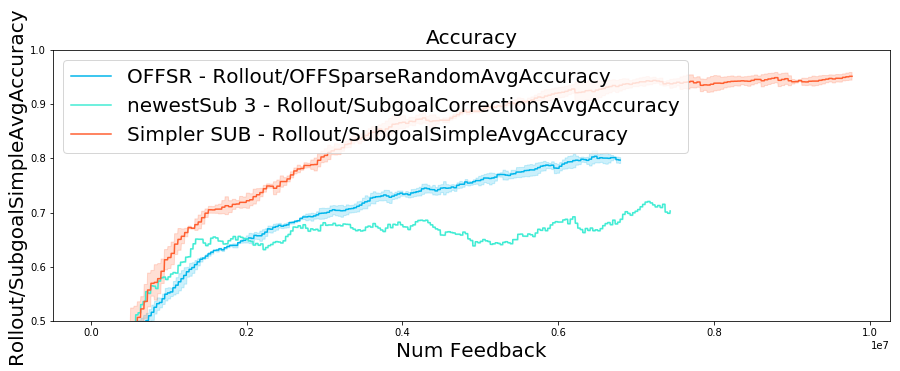

'Rollout/OFFSparseRandomAvgSuccess'
couldn't plot newestSub 3 - Rollout/OFFSparseRandomAvgSuccess
'Rollout/OFFSparseRandomAvgSuccess'
couldn't plot Simpler SUB - Rollout/OFFSparseRandomAvgSuccess
LENGTHS [2012, 1956, 2010]
LENGTHS [2301]
'Rollout/SubgoalCorrectionsAvgSuccess'
couldn't plot Simpler SUB - Rollout/SubgoalCorrectionsAvgSuccess
'Rollout/SubgoalCorrectionsAvgSuccess'
couldn't plot OFFSR - Rollout/SubgoalCorrectionsAvgSuccess
'Rollout/SubgoalSimpleAvgSuccess'
couldn't plot newestSub 3 - Rollout/SubgoalSimpleAvgSuccess
LENGTHS [2290, 2249, 2349]
'Rollout/SubgoalSimpleAvgSuccess'
couldn't plot OFFSR - Rollout/SubgoalSimpleAvgSuccess


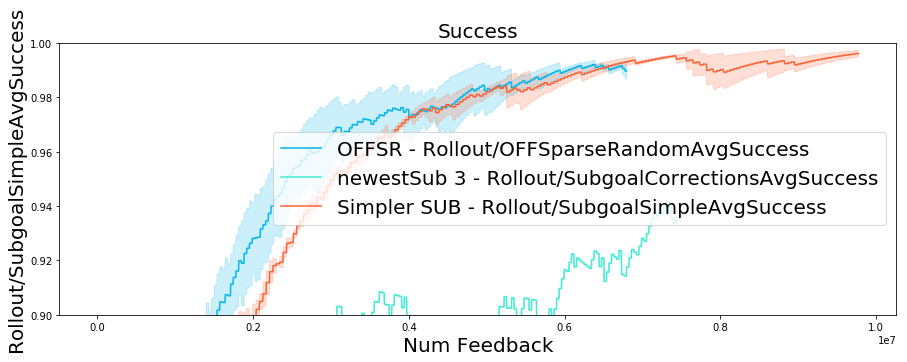

In [244]:
metrics_acc = [
    'Rollout/OFFSparseRandomAvgAccuracy',
    'Rollout/SubgoalCorrectionsAvgAccuracy',
    'Rollout/SubgoalSimpleAvgAccuracy',
]

metrics_success = [
    'Rollout/OFFSparseRandomAvgSuccess',
    'Rollout/SubgoalCorrectionsAvgSuccess',
    'Rollout/SubgoalSimpleAvgSuccess',
]

plt.rcParams['figure.figsize'] = [15, 5]
runs = [
#     (['T2293', 'T2187'], 'Distill OFF3 from oracle'),
#     (['T2294', 'T2193'], 'Distill OFF5 from oracle'),
#     (['T2299'], 'Distill OFF3 from PA'),
#     (['T2300'], 'Distill OFF5 from PA'),
#     (['T2318'], 'Distill OFF10 from PA'), # OK
#     (['T2317'], 'Distill SUB from PA'),
    
#     (['T2343'], 'Distill OFF10 from PA - 5 Levels'), # OK
#     (['T2342'], 'SUB'),
    
    
    
#     (['T2358'], 'newSub'),
#     (['T2359'], 'newSub, long'),
#     (['T2360'], 'newSub, long + big'),
#     (['T2362'], 'newerSub'),
#     (['T2363_SUB_FROMPA_1', 'T2363_SUB_FROMPA_3'], 'newerSub, long + big'),
#     (['T2364'], 'FullyObserved BEST'),
#     (['T2431_SUB_FROMPA_2', 'T2431_SUB_FROMPA_3'], 'newestSub'),
#     (['T2431_SUB_FROMPA_2'], 'newestSub 2'),
    (['T2431_SUB_FROMPA_3'], 'newestSub 3'),
#     (['T2436'], 'newestSub 3'),
    (['T2511'], 'Simpler SUB'),
    (['T2512'], 'OFFSR'),
    
    
#     (['T2345'], 'Distill OFF10 from PA - 5 Levels, FullyObserved'),
#     (['T2344'], 'Distill SUB from PA - 5 Levels, FullyObserved'),
#     (['T2295'], 'RL Train OFF3'),
#     (['T2296'], 'RL Train OFF5'),
]

x_axis = 'feedback'
plot_curriculum(runs, x_axis, y=metrics_acc, 
                smooth=500, error_bars=True, 
            title=f"Accuracy",
           y_lower=.5, y_upper=1)
plot_curriculum(runs, x_axis, y=metrics_success, 
                smooth=500, error_bars=True, 
            title=f"Success",
           y_lower=.9, y_upper=1)

# Fully Observed

In [ ]:
metrics_acc = [
    'Rollout/SubgoalCorrectionsAvgAccuracy',
]

metrics_success = [
    'Rollout/SubgoalCorrectionsAvgSuccess',
]

plt.rcParams['figure.figsize'] = [15, 5]
runs = [

    (['T2360'], 'Distill SUB from PA, newSub, long + big'),
    
    
    (['T2344'], 'Distill SUB from PA - 5 Levels, FullyObserved'),
    (['T2361_SUB_FROMPA_1'], 'Distill SUB from PA - 5 Levels, FullyObserved BETTER'),
    (['T2364_SUB_FROMPA_1'], 'Distill SUB from PA - 5 Levels, FullyObserved BEST'),
]

x_axis = 'samples'
plot_curriculum(runs, x_axis, y=metrics_acc, 
                smooth=500, error_bars=True, 
            title=f"Accuracy",
           y_lower=0, y_upper=1)
plot_curriculum(runs, x_axis, y=metrics_success, 
                smooth=500, error_bars=True, 
            title=f"Success",
           y_lower=0, y_upper=1)

In [ ]:
runs = [
    (['TEMP', 'TEMP'], 'Temp', 5),
]
plot_finetune_generalization(runs, 'Finetune', smooth=3) # kangaroo